# **Fundacion Sadosky - Meta Data - YPF**

# **Inteligencia Artificial para la Predicción de Incremental de Presiones por Interferencia**

*   Objetivo: *El concurso propone el desarrollo de un algoritmo de predicción del incremental de persión por interferencia durante la estimulación de pozos no convencionales de petróleo y gas.*

## **Introduccion**

Una de las características asociadas a la producción de petróleo y gas no convencional es la necesidad de estimular los pozos productores antes del comienzo de la producción. La estimulación consiste en la generación de fisuras en la roca productora a través de la inyección de un fluido a alta presión.
El avance sistemático de los desarrollos no convencionales en la Fm. Vaca Muerta implica la perforación de pozos horizontales distribuidos espacialmente con el objetivo de maximizar la recuperación de petróleo y gas. Con ese objetivo, la distancia entre pozos vecino ha ido disminuyendo a lo largo del tiempo y, como consecuencia, se han registrado interferencias entre los pozos en producción (pozos padres) y los pozos nuevos en estimulación (pozos hijos) denominados frac-hits.

Los frac-hits consisten en una anomalía de presión, corte de agua y/o temperatura en un pozo productor vecino a un pozo que está siendo fracturado. Este suceso de denomina "golpe de fractura" o "frac-hit" debido a que las fracturas hidráulicas del pozo hijo "golpean" el volumen de reservorio estimulado por el pozo padre y generan la interconexión.

Este fenómeno, se ha convertido en una importante preocupación debido a que constituye un riesgo para las operaciones, debido a las condiciones de integridad del pozo padre como colapso de casing, fugas de fluido por el cabezal de pozo, aprisionamiento de instalaciones de producción.

La pérdida de integridad de un pozo padre trae aparejado un importante costo debido a los riesgos de seguridad que conlleva, la posible detención de sets de fractura, costos de remediación y costo de oportunidad de equipos que se destinan a asegurar pozos padres. Por lo tanto, se requiere desarrollar un modelo predictivo que permita identificar los pozos con riesgo a ser interferidos y la magnitud de los frac-hits asociados.

En este contexto, el objetivo del concurso actual es el desarrollo de un algoritmo de predicción de incremento de presión como consecuencia de todos los frac-hits que pueda recibir un pozo padre a raíz de la estimulación de un conjunto de pozos hijos cercanos.

Se busca optimizar los pozos que ingresan al protocolo de aseguramiento, minimizando dos tipos de pozos: los pozos no asegurados que son interferidos y los pozos asegurados que no son interferidos. El resultado mejora la gestión de los riesgos que se asume y optimizando los costos de lifting asociados. El alcance del modelo es para pozos productores en Yacimientos No Convencionales de Petróleo y Gas.

## **Evaluacion**

La métrica que se usará para evaluar será la minimización del MSE como se presenta en la siguiente ecuación:

ε = Σ (ΔP - ΔPest)² (1)

donde ΔP es el incremental de presión luego de la interferencia y ΔPest es el valor de incremental estimado por el modelo.


## **Datos**

La tabla contiene las columnas que se describen en la siguiente lista:

*   **ID_FILA**: Identificador usado para subir la solución.
*   **ID_EVENTO**: Identificador único de la línea.
*   **CAMPO**: Nombre del Bloque al que pertenece el PAD Hijo.
*   **FLUIDO**: Fluido que produce el PAD (Gas o Petróleo).
*   **PAD_HIJO**: Nombre del PAD Hijo 
*   **HIJO**: Nombre del Pozo Hijo.
*   **ETAPA_HIJO**: Número de Etapa de Fractura del pozo Hijo.
*   **PADRE**: Nombre del Pozo Padre.
*   **D3D**: Distancia tridimensional entre la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre (DX^2+DY^2+DZ^2)/2.
*   **D2D**: Distancia en planta (vista de pajaro - sin considerar distancia vertical) entre la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre (DX^2+DY^2)*(1/2).
*   **DZ**: Distancia vertical (diferencia de altura) entre la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre.
*   **AZ**: Angulo respecto al norte que forma la linea recta que une la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre.
*   **#_BARRERAS**: Cantidad de pozos padre entre el Pozo Hijo y el Pozo Padre considerado. Se consideran todos los pozos atravesados por la linea considerada en la D2D, y dentro de un espacio vertical que abarca toda la distancia vertical entre Pozo Hijo y Pozo Padre más 40m por encima y por debajo.
*   **LINEAMIENTO**: Anomalías geológicas que atraviesan al Pozo Hijo y Pozo Padre.
*   **WHP_i**: Presión al inicio de la interferencia.
*   **delta_WHP**: Salto de presión generado por la interferencia. Desde la presión inicial al punto máximo o mínimo del salto.
*   **ESTADO**: Estado del pozo al momento de la interferencia. Cerrado/Abierto.

## **Autor**: Claudio Collado

## **Observacion:** Para la ejecucion de esta Notebook es necesario el **uso de GPU** para el **entrenamiento de los modelos de Regresion y Clasificacion**

# **Modulos y Datasets**

In [ ]:
#Importo los modulos que utilizare durante el desarrollo de la solucion

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split

import warnings
warnings.filterwarnings('ignore')

*   La lectura de los datasets **participantes** y **evaluacion** se realiza directamente desde mi repositorio de acceso publico en Github: https://github.com/ccollado7/metadata_ypf. Los mismos corresponden al ultimo envio realizado por los organizadores de la competencia

In [ ]:
#Direcciones
url_train = 'https://raw.githubusercontent.com/ccollado7/metadata_ypf/main/Dataset%20participantes%20(corregido).csv'
url_test = 'https://raw.githubusercontent.com/ccollado7/metadata_ypf/main/Dataset%20evaluaci%C3%B3n%20(corregido).csv'

#Lectura de los datasets

#Participantes (train)
df_train = pd.read_csv(url_train)

#Evaluacion (test)
df_test = pd.read_csv(url_test)

# **1. Analisis Exploratorio - Train y Test**

In [ ]:
# Train - 5 primeros registros

df_train.head()

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
0,1,Pozo 81-Pozo 22-37,Campo D,OIL,PAD-47,Pozo 81,37,Pozo 22,1323.623144,1323.212672,32.961374,199.623188,0.0,NO,-0.2,0.0,Abierto
1,2,Pozo 132-Pozo 112-10,Campo C,GAS,PAD-19,Pozo 132,10,Pozo 112,1184.248919,1184.233308,6.080755,345.025732,0.0,NO,-0.1,0.0,Abierto
2,3,Pozo 133-Pozo 112-21,Campo C,GAS,PAD-19,Pozo 133,21,Pozo 112,847.811857,847.771101,8.312941,342.171963,0.0,NO,-0.1,0.0,Abierto
3,4,Pozo 478-Pozo 122-6,Campo C,GAS,PAD-21,Pozo 478,6,Pozo 122,625.328398,625.314697,4.139460,259.131395,1.0,NO,-0.1,0.0,Abierto
4,5,Pozo 405-Pozo 242-19,Campo F,OIL,PAD-60,Pozo 405,19,Pozo 242,1118.214531,1118.074170,17.716903,90.993004,3.0,NO,-0.1,0.0,Abierto




*   El Traget corresponde a **delta_WHP**



In [ ]:
# Test - 5 primeros registros

df_test.head()

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
0,26179,Pozo 27-Pozo 54-38,Campo B,OIL,PAD-13,Pozo 27,38,Pozo 54,1583.887656,1583.666853,-26.446264,143.640741,1.0,NO,-0.3,Cerrado
1,26180,Pozo 29-Pozo 54-39,Campo B,OIL,PAD-13,Pozo 29,39,Pozo 54,1477.040698,1476.930670,18.028312,147.363305,1.0,NO,-0.3,Cerrado
2,26181,Pozo 27-Pozo 54-41,Campo B,OIL,PAD-13,Pozo 27,41,Pozo 54,1445.963183,1445.750399,-24.805432,139.270555,1.0,NO,-0.3,Cerrado
3,26182,Pozo 555-Pozo 69-4,Campo E,OIL,PAD-85,Pozo 555,4,Pozo 69,672.288788,672.248439,7.365507,232.229747,0.0,NO,-0.3,Cerrado
4,26183,Pozo 555-Pozo 69-5,Campo E,OIL,PAD-85,Pozo 555,5,Pozo 69,642.817440,642.776548,7.250530,236.785609,0.0,NO,-0.3,Cerrado


In [ ]:
#Train - Dimensiones

num_registros_train = df_train.shape[0]
num_columnas_train = df_train.shape[1]

print(f'La cantidad de registros de train es: {num_registros_train}')
print(f'La cantidad de columnas de train es: {num_columnas_train}')

La cantidad de registros de train es: 26178
La cantidad de columnas de train es: 17


In [ ]:
# Test - Dimensiones

num_registros_test = df_test.shape[0]
num_columnas_test = df_test.shape[1]

print(f'La cantidad de registros de test es: {num_registros_test}')
print(f'La cantidad de columnas de test es: {num_columnas_test}')

La cantidad de registros de test es: 6537
La cantidad de columnas de test es: 16


In [ ]:
# Train - Columnas

df_train.columns

Index(['ID_FILA', 'ID_EVENTO', 'CAMPO', 'FLUIDO', 'PAD_HIJO', 'HIJO',
       'ETAPA_HIJO', 'PADRE', 'D3D', 'D2D', 'DZ', 'AZ', '#_BARRERAS',
       'LINEAMIENTO', 'WHP_i', 'delta_WHP', 'ESTADO'],
      dtype='object')

In [ ]:
#Test - Columnas

df_test.columns

Index(['ID_FILA', 'ID_EVENTO', 'CAMPO', 'FLUIDO', 'PAD_HIJO', 'HIJO',
       'ETAPA_HIJO', 'PADRE', 'D3D', 'D2D', 'DZ', 'AZ', '#_BARRERAS',
       'LINEAMIENTO', 'WHP_i', 'ESTADO'],
      dtype='object')

In [ ]:
#Train - Resumen

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26178 entries, 0 to 26177
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID_FILA      26178 non-null  int64  
 1   ID_EVENTO    26178 non-null  object 
 2   CAMPO        26178 non-null  object 
 3   FLUIDO       26178 non-null  object 
 4   PAD_HIJO     26178 non-null  object 
 5   HIJO         26178 non-null  object 
 6   ETAPA_HIJO   26178 non-null  int64  
 7   PADRE        26178 non-null  object 
 8   D3D          26178 non-null  float64
 9   D2D          26178 non-null  float64
 10  DZ           26178 non-null  float64
 11  AZ           26178 non-null  float64
 12  #_BARRERAS   26178 non-null  float64
 13  LINEAMIENTO  26178 non-null  object 
 14  WHP_i        26178 non-null  float64
 15  delta_WHP    26178 non-null  float64
 16  ESTADO       26178 non-null  object 
dtypes: float64(7), int64(2), object(8)
memory usage: 3.4+ MB


In [ ]:
#Test - Resumen

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6537 entries, 0 to 6536
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID_FILA      6537 non-null   int64  
 1   ID_EVENTO    6537 non-null   object 
 2   CAMPO        6537 non-null   object 
 3   FLUIDO       6537 non-null   object 
 4   PAD_HIJO     6537 non-null   object 
 5   HIJO         6537 non-null   object 
 6   ETAPA_HIJO   6537 non-null   int64  
 7   PADRE        6537 non-null   object 
 8   D3D          6537 non-null   float64
 9   D2D          6537 non-null   float64
 10  DZ           6537 non-null   float64
 11  AZ           6537 non-null   float64
 12  #_BARRERAS   6537 non-null   float64
 13  LINEAMIENTO  6537 non-null   object 
 14  WHP_i        6537 non-null   float64
 15  ESTADO       6537 non-null   object 
dtypes: float64(6), int64(2), object(8)
memory usage: 817.2+ KB


In [ ]:
#Train - Cantidad de NaN por variable

df_train.isna().sum()

ID_FILA        0
ID_EVENTO      0
CAMPO          0
FLUIDO         0
PAD_HIJO       0
HIJO           0
ETAPA_HIJO     0
PADRE          0
D3D            0
D2D            0
DZ             0
AZ             0
#_BARRERAS     0
LINEAMIENTO    0
WHP_i          0
delta_WHP      0
ESTADO         0
dtype: int64

In [ ]:
#Test - Cantidad de NaN por variable

df_test.isna().sum()

ID_FILA        0
ID_EVENTO      0
CAMPO          0
FLUIDO         0
PAD_HIJO       0
HIJO           0
ETAPA_HIJO     0
PADRE          0
D3D            0
D2D            0
DZ             0
AZ             0
#_BARRERAS     0
LINEAMIENTO    0
WHP_i          0
ESTADO         0
dtype: int64

In [ ]:
#Train - Registros duplicados

df_train.duplicated().sum()

0

In [ ]:
#Train - Registros duplicados

df_test.duplicated().sum()

0

## **1.1 Analisis Univariado**

### **1.1.1** Feature **ID_EVENTO**: *Identificador único de la línea*

*   No corresponde a una variable relevante ya que es un identificador del registro



In [ ]:
#Train - Cantidad de 'ID_EVENTO' unicos

len(df_train['ID_EVENTO'].unique())

26178

In [ ]:
#Test - Cantidad de 'ID_EVENTO' unicos

len(df_test['ID_EVENTO'].unique())

6537

*   Los valores que surjen del conteo se corresponden con la cantidad de filas en train y test

### **1.1.2** Feature **CAMPO**: Nombre del Bloque al que pertenece el PAD Hijo

In [ ]:
#Train - Tipo de dato de la variable

df_train['CAMPO'].dtype

dtype('O')

In [ ]:
#Test - Tipo de dato de la variable

df_test['CAMPO'].dtype

dtype('O')


*   En ambos casos el tipo de datos corresponde a **object**



In [ ]:
#Train - Categorias y cantidad de registros por categoria

df_train['CAMPO'].value_counts()

Campo F    10918
Campo C     5686
Campo E     4613
Campo D     2483
Campo B     1936
Campo G      283
Campo I      127
Campo A      108
Campo H       24
Name: CAMPO, dtype: int64

In [ ]:
#Test -Categorias y cantidad de registros por categoria

df_test['CAMPO'].value_counts()

Campo F    2718
Campo C    1414
Campo E    1166
Campo D     623
Campo B     501
Campo G      48
Campo I      39
Campo A      22
Campo H       6
Name: CAMPO, dtype: int64

*   Existen 9 campos diferentes 

*   En train y test se encuentran las mismas categorias (campos). A su vez el conteo de cantidades mantiene el mismo orden en ambos datasets 

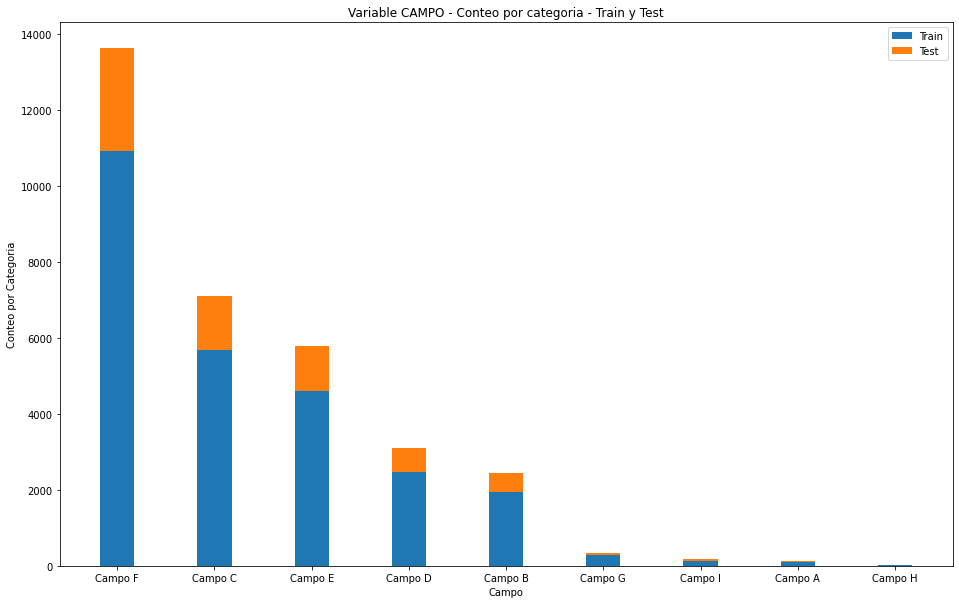

In [ ]:
#Grafico de conteo por categoria en Train y Test

labels = ['Campo F','Campo C','Campo E','Campo D','Campo B','Campo G','Campo I','Campo A','Campo H']
campo_train = df_train['CAMPO'].value_counts().values
campo_test = df_test['CAMPO'].value_counts().values
width = 0.35

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

ax.bar(labels, campo_train, width,label='Train')
ax.bar(labels, campo_test, width, bottom=campo_train,label='Test')

ax.set_xlabel('Campo')
ax.set_ylabel('Conteo por Categoria')
ax.set_title('Variable CAMPO - Conteo por categoria - Train y Test')
ax.legend()

plt.show()

In [ ]:
#Proporciones entre Train y Test por conteo de categoria

campo_proporciones = df_train['CAMPO'].value_counts() / df_test['CAMPO'].value_counts()
campo_proporciones.sort_values(ascending=False)

Campo G    5.895833
Campo A    4.909091
Campo C    4.021216
Campo F    4.016924
Campo H    4.000000
Campo D    3.985554
Campo E    3.956261
Campo B    3.864271
Campo I    3.256410
Name: CAMPO, dtype: float64

### **1.1.3** Feature **FLUIDO**: *Fluido que produce el PAD (Gas o Petróleo)*

In [ ]:
#Train - Tipo de dato de la variable

df_train['FLUIDO'].dtype

dtype('O')

In [ ]:
#Test - Tipo de dato de la variable en test

df_test['FLUIDO'].dtype

dtype('O')




*   En ambos casos el tipo de datos corresponde a **object**

In [ ]:
#Train - Categorias y cantidad de registros por categoria

df_train['FLUIDO'].value_counts()

OIL    19974
GAS     6204
Name: FLUIDO, dtype: int64

In [ ]:
#Test - Categorias y cantidad de registros por categoria

df_test['FLUIDO'].value_counts()

OIL    5014
GAS    1523
Name: FLUIDO, dtype: int64

*     Se producen 2 fluidos: GAS y OIL (petroleo)


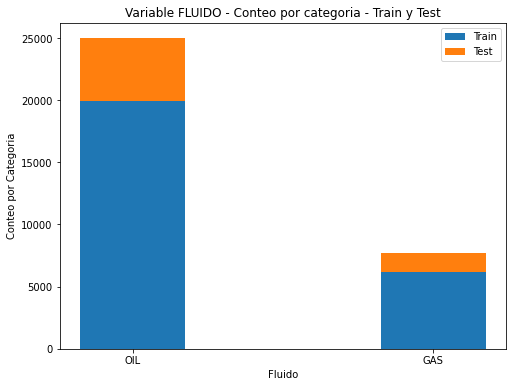

In [ ]:
#Grafico de conteo por categoria en Train y Test

labels = ['OIL','GAS']
fluido_train = df_train['FLUIDO'].value_counts().values
fluido_test = df_test['FLUIDO'].value_counts().values
width = 0.35

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(8)

ax.bar(labels, fluido_train, width,label='Train')
ax.bar(labels, fluido_test, width, bottom=fluido_train,label='Test')

ax.set_xlabel('Fluido')
ax.set_ylabel('Conteo por Categoria')
ax.set_title('Variable FLUIDO - Conteo por categoria - Train y Test')
ax.legend()

plt.show()

In [ ]:
#Proporciones entre Train y Test por conteo de categoria

fluido_proporciones = df_train['FLUIDO'].value_counts() / df_test['FLUIDO'].value_counts()
fluido_proporciones.sort_values(ascending=False)

GAS    4.073539
OIL    3.983646
Name: FLUIDO, dtype: float64

### **1.1.4** Feature **PAD_HIJO**: *Nombre del PAD Hijo*

In [ ]:
#Train - Tipo de dato de la variable

df_train['PAD_HIJO'].dtype

dtype('O')

In [ ]:
#Test - Tipo de dato de la variable

df_test['PAD_HIJO'].dtype

dtype('O')



*   En ambos casos el tipo de datos corresponde a **object**

In [ ]:
#Train - Cantidad de PAD_HIJO distintos

pad_hijo_train = pd.Series(df_train['PAD_HIJO'].unique())
len(pad_hijo_train)

81

In [ ]:
#Train - Listado de PAD_HIJO distintos

print(list(pad_hijo_train))

['PAD-47', 'PAD-19', 'PAD-21', 'PAD-60', 'PAD-61', 'PAD-57', 'PAD-58', 'PAD-72', 'PAD-76', 'PAD-80', 'PAD-23', 'PAD-59', 'PAD-85', 'PAD-82', 'PAD-84', 'PAD-86', 'PAD-6', 'PAD-81', 'PAD-67', 'PAD-75', 'PAD-49', 'PAD-69', 'PAD-74', 'PAD-78', 'PAD-26', 'PAD-48', 'PAD-25', 'PAD-63', 'PAD-77', 'PAD-24', 'PAD-73', 'PAD-13', 'PAD-50', 'PAD-9', 'PAD-7', 'PAD-41', 'PAD-68', 'PAD-65', 'PAD-71', 'PAD-43', 'PAD-66', 'PAD-11', 'PAD-5', 'PAD-20', 'PAD-17', 'PAD-33', 'PAD-4', 'PAD-52', 'PAD-64', 'PAD-12', 'PAD-10', 'PAD-44', 'PAD-45', 'PAD-62', 'PAD-95', 'PAD-39', 'PAD-28', 'PAD-98', 'PAD-79', 'PAD-1', 'PAD-70', 'PAD-54', 'PAD-92', 'PAD-91', 'PAD-83', 'PAD-3', 'PAD-93', 'PAD-55', 'PAD-87', 'PAD-56', 'PAD-88', 'PAD-38', 'PAD-53', 'PAD-46', 'PAD-31', 'PAD-32', 'PAD-36', 'PAD-89', 'PAD-35', 'PAD-40', 'PAD-90']


In [ ]:
#Test - Cantidad de PAD_HIJO distintos

pad_hijo_test = pd.Series(df_test['PAD_HIJO'].unique())
len(pad_hijo_test)

78

In [ ]:
#Test - Listado de PAD_HIJO distintos

print(list(pad_hijo_test))

['PAD-13', 'PAD-85', 'PAD-19', 'PAD-60', 'PAD-76', 'PAD-80', 'PAD-47', 'PAD-72', 'PAD-75', 'PAD-84', 'PAD-23', 'PAD-82', 'PAD-81', 'PAD-44', 'PAD-45', 'PAD-86', 'PAD-64', 'PAD-6', 'PAD-67', 'PAD-65', 'PAD-9', 'PAD-57', 'PAD-63', 'PAD-7', 'PAD-54', 'PAD-50', 'PAD-77', 'PAD-69', 'PAD-68', 'PAD-74', 'PAD-78', 'PAD-61', 'PAD-24', 'PAD-25', 'PAD-73', 'PAD-58', 'PAD-71', 'PAD-4', 'PAD-70', 'PAD-41', 'PAD-56', 'PAD-43', 'PAD-20', 'PAD-62', 'PAD-11', 'PAD-49', 'PAD-66', 'PAD-83', 'PAD-17', 'PAD-10', 'PAD-33', 'PAD-48', 'PAD-52', 'PAD-53', 'PAD-26', 'PAD-5', 'PAD-28', 'PAD-39', 'PAD-59', 'PAD-88', 'PAD-21', 'PAD-98', 'PAD-1', 'PAD-46', 'PAD-31', 'PAD-92', 'PAD-91', 'PAD-95', 'PAD-79', 'PAD-32', 'PAD-36', 'PAD-40', 'PAD-38', 'PAD-3', 'PAD-55', 'PAD-93', 'PAD-35', 'PAD-90']


In [ ]:
#PAD que se encuentran en Train y no se encuentran en Test

pad_hijo_train[~pad_hijo_train.isin(pad_hijo_test)]

49    PAD-12
68    PAD-87
77    PAD-89
dtype: object



*   Existen 3 PAD_HIJO que que se encuentran en Train y no en Test

In [ ]:
#PAD que se encuentran en Test y no se encuentran en train

pad_hijo_test[~pad_hijo_test.isin(pad_hijo_train)]

Series([], dtype: object)



*   Todos los PAD's de Test se encuentran en Train

In [ ]:
#Train - Categorias y cantidad de registros por categoria

df_train['PAD_HIJO'].value_counts()

PAD-85    1769
PAD-60    1672
PAD-80    1467
PAD-82    1204
PAD-6     1058
          ... 
PAD-87       7
PAD-12       7
PAD-93       4
PAD-89       2
PAD-31       1
Name: PAD_HIJO, Length: 81, dtype: int64

In [ ]:
#Test - Categorias y cantidad de registros por categoria

df_test['PAD_HIJO'].value_counts()

PAD-85    464
PAD-60    421
PAD-80    378
PAD-82    299
PAD-6     274
         ... 
PAD-93      2
PAD-41      2
PAD-31      1
PAD-88      1
PAD-35      1
Name: PAD_HIJO, Length: 78, dtype: int64

In [ ]:
#Proporciones entre Train y Test por conteo de categoria

pad_hijo_proporciones = pd.DataFrame(data={'proporciones':df_train['PAD_HIJO'].value_counts() / df_test['PAD_HIJO'].value_counts()})

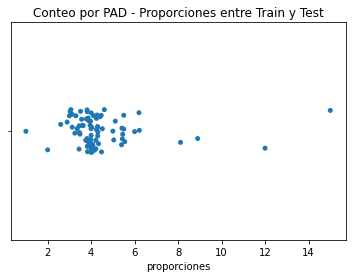

In [ ]:
#Grafico STRIPPLOT de proporciones - Train y test

sns.stripplot(data=pad_hijo_proporciones,x='proporciones')
plt.title('Conteo por PAD - Proporciones entre Train y Test')
plt.show()

### **1.1.5** Feature **HIJO**: Nombre del Pozo Hijo

In [ ]:
#Train - Tipo de dato de la variable

df_train['HIJO'].dtype

dtype('O')

In [ ]:
#Test - Tipo de dato de la variable

df_test['HIJO'].dtype

dtype('O')



*   En ambos casos el tipo de datos corresponde a **object**

In [ ]:
#Train - Cantidad de HIJO distintos

hijo_train = pd.Series(df_train['HIJO'].unique())
len(hijo_train)

293

In [ ]:
#Test - Cantidad de HIJO distintos

hijo_test = pd.Series(df_test['HIJO'].unique())
len(hijo_test)

269

In [ ]:
#HIJO que se encuentran en Train y no se encuentra en Test

hijo_train[~hijo_train.isin(hijo_test)]

17     Pozo 537
98      Pozo 40
124    Pozo 467
129    Pozo 497
134    Pozo 512
140     Pozo 41
142    Pozo 474
163    Pozo 188
172    Pozo 443
207    Pozo 464
236    Pozo 475
237    Pozo 476
239    Pozo 558
244    Pozo 563
258    Pozo 566
262    Pozo 532
263    Pozo 388
270    Pozo 165
271    Pozo 444
275    Pozo 559
276    Pozo 562
278    Pozo 163
281    Pozo 569
289    Pozo 522
290    Pozo 530
dtype: object

In [ ]:
#HIJO que se encuentran en train y no se encuentra en test - Cantidad

len(hijo_train[~hijo_train.isin(hijo_test)])

25

*   Existen 25 HIJO que se encuentran en train y no en test



In [ ]:
#HIJO que se encuentran en test y no se encuentra en train - Cantidad

hijo_test[~hijo_test.isin(hijo_train)]

220    Pozo 164
dtype: object



*   Existen 1 HIJO que se encuentra en test y no se encuentra en train

In [ ]:
df_test[df_test['HIJO'] == 'Pozo 164']

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
3953,30132,Pozo 164-Pozo 156-8,Campo D,OIL,PAD-31,Pozo 164,8,Pozo 156,712.142944,712.085396,-9.053256,283.374615,0.0,NO,133.3,Cerrado




*   El HIJO que se encuentra en test y no en train tiene asociado 1 registro

In [ ]:
#Train - Categorias y cantidad de registros por categoria

df_train['HIJO'].value_counts()

Pozo 407    488
Pozo 405    440
Pozo 30     415
Pozo 555    390
Pozo 556    362
           ... 
Pozo 165      1
Pozo 474      1
Pozo 522      1
Pozo 530      1
Pozo 558      1
Name: HIJO, Length: 293, dtype: int64

In [ ]:
#Test - Categorias y cantidad de registros por categoria

df_test['HIJO'].value_counts()

Pozo 407    119
Pozo 405    112
Pozo 555    110
Pozo 245    104
Pozo 557     91
           ... 
Pozo 511      1
Pozo 143      1
Pozo 142      1
Pozo 61       1
Pozo 164      1
Name: HIJO, Length: 269, dtype: int64

In [ ]:
#Proporciones entre Train y Test por conteo de categoria

hijo_proporciones = pd.DataFrame(data={'proporciones':df_train['HIJO'].value_counts() / df_test['HIJO'].value_counts()})

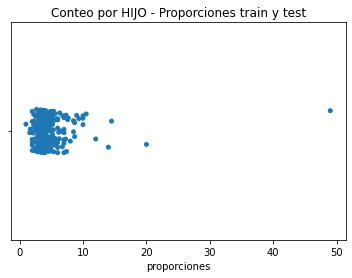

In [ ]:
#Grafico STRIPPLOT de proporciones - Train y test

sns.stripplot(data=hijo_proporciones,x='proporciones')
plt.title('Conteo por HIJO - Proporciones train y test')
plt.show()

### **1.1.6** Feature **ETAPA_HIJO**: Número de Etapa de Fractura del pozo Hijo

In [ ]:
#Train - Tipo de dato de la variable

df_train['ETAPA_HIJO'].dtype

dtype('int64')

In [ ]:
# Test - Tipo de dato de la variable

df_test['ETAPA_HIJO'].dtype

dtype('int64')



*   En ambos casos el tipo de datos corresponde a **int64**

In [ ]:
#Train - Valores de estadistica descriptiva

df_train['ETAPA_HIJO'].describe()

count    26178.00000
mean        17.15960
std         11.22884
min          1.00000
25%          8.00000
50%         16.00000
75%         24.00000
max         68.00000
Name: ETAPA_HIJO, dtype: float64

In [ ]:
#Test - Valores de estadistica descriptiva

df_test['ETAPA_HIJO'].describe()

count    6537.000000
mean       17.400031
std        11.366804
min         1.000000
25%         8.000000
50%        16.000000
75%        25.000000
max        66.000000
Name: ETAPA_HIJO, dtype: float64

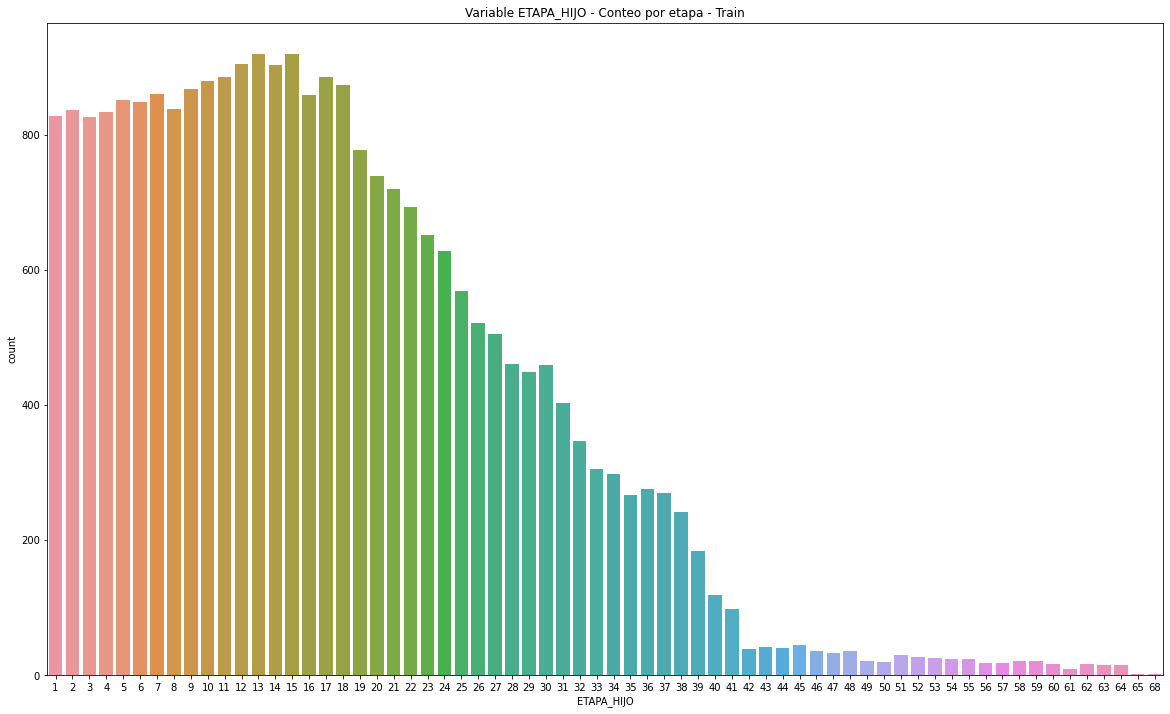

In [ ]:
#Grafico COUNTPLOT de conteo por etapa - Train

fig = plt.figure(figsize=(20,12))
sns.countplot(x=df_train["ETAPA_HIJO"])
plt.title('Variable ETAPA_HIJO - Conteo por etapa - Train')
plt.show()

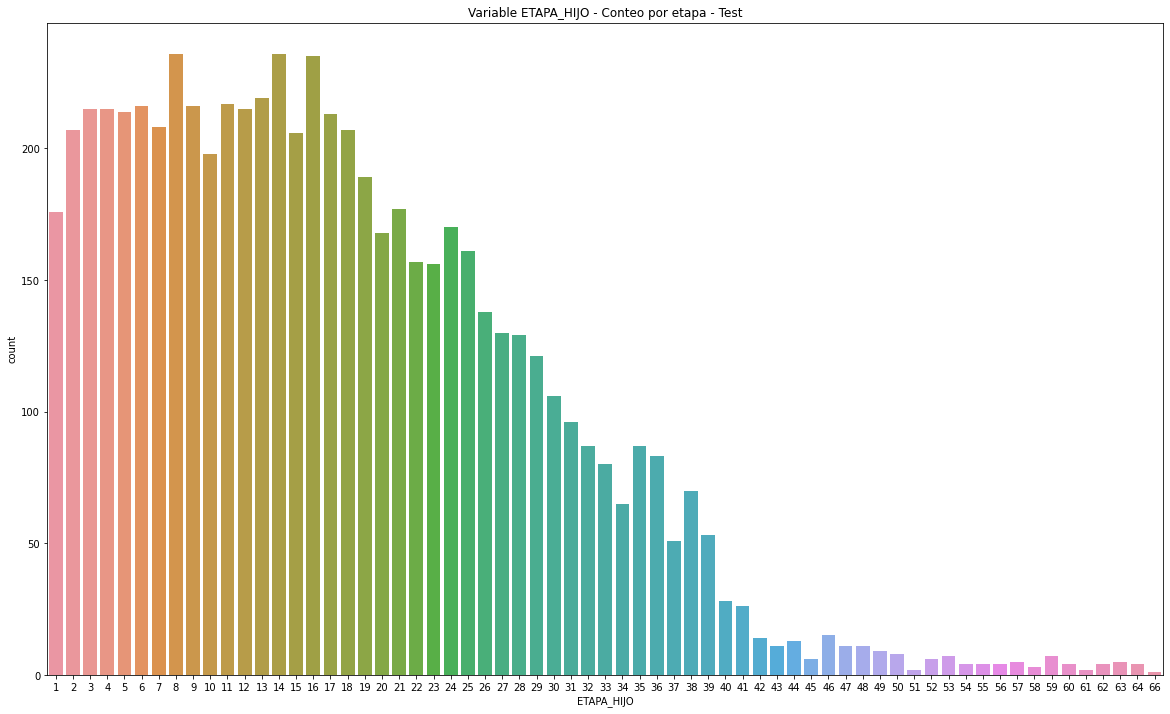

In [ ]:
#Grafico COUNTPLOT de conteo por etapa - Test

fig = plt.figure(figsize=(20,12))
sns.countplot(x=df_test["ETAPA_HIJO"])
plt.title('Variable ETAPA_HIJO - Conteo por etapa - Test')
plt.show()

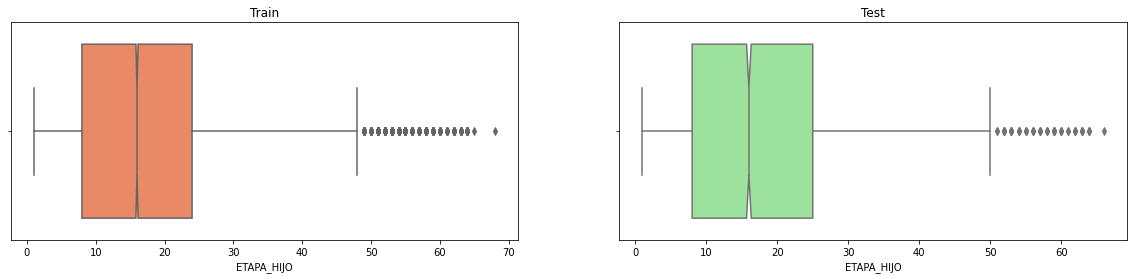

In [ ]:
#Grafico Boxplot - Etapas - Train y test

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.boxplot(data=df_train,x='ETAPA_HIJO',color='coral',notch=True,ax=axs[0])
sns.boxplot(data=df_test,x='ETAPA_HIJO',color='lightgreen',notch=True,ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

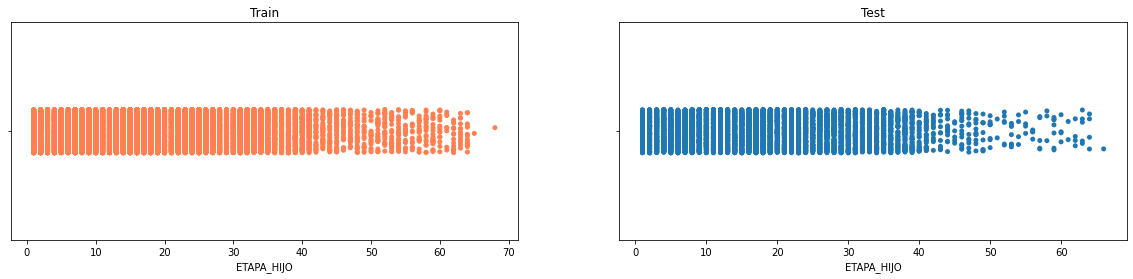

In [ ]:
#Grafico STRIPPLOT - Estapas - Train y test

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.stripplot(data=df_train, x="ETAPA_HIJO",ax=axs[0],color='coral')
sns.stripplot(data=df_test, x="ETAPA_HIJO",ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

### **1.1.7** Feature **PADRE**: Nombre del Pozo Padre

In [ ]:
#Train - Tipo de dato de la variable

df_train['PADRE'].dtype

dtype('O')

In [ ]:
#Test - Tipo de dato de la variable

df_test['PADRE'].dtype

dtype('O')


*   En ambos casos el tipo de datos corresponde a **object**



In [ ]:
#Train - Cantidad de PADRE distintos

padre_train = pd.Series(df_train['PADRE'].unique())
len(padre_train)

355

In [ ]:
#Test - Cantidad de PADRE distintos

padre_test = pd.Series(df_test['PADRE'].unique())
len(padre_test)

340

In [ ]:
#PADRE que se encuentran en Train y no se encuentran en test

padre_train[~padre_train.isin(padre_test)]

52     Pozo 381
70     Pozo 397
141    Pozo 199
174    Pozo 291
175    Pozo 346
177     Pozo 88
208    Pozo 439
213    Pozo 140
214    Pozo 373
250    Pozo 405
252    Pozo 142
269    Pozo 375
288    Pozo 196
323     Pozo 89
327     Pozo 49
329    Pozo 396
dtype: object

In [ ]:
len(padre_train[~padre_train.isin(padre_test)])

16



*   Existen 16 PADRE que que encuentran en train y no en test

In [ ]:
#PADRE que se encuentran en test y no en train

padre_test[~padre_test.isin(padre_train)]

204    Pozo 318
dtype: object



*   Existen 1 PADRE que se encuentra en test y no en train

In [ ]:
df_test[df_test['PADRE'] == 'Pozo 318']

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
2024,28203,Pozo 324-Pozo 318-2,Campo E,OIL,PAD-69,Pozo 324,2,Pozo 318,1459.995973,1458.781171,59.546089,289.246348,1.0,NO,45.5,Abierto
2032,28211,Pozo 527-Pozo 318-1,Campo E,OIL,PAD-69,Pozo 527,1,Pozo 318,1598.149811,1597.807863,33.058268,286.753910,2.0,NO,45.6,Abierto




*   El PADRE que se encuentra en test y no en train tiene asociado 2 registros

In [ ]:
#Train - Categorias y cantidad de registros por categoria 

df_train['PADRE'].value_counts()

Pozo 91     363
Pozo 61     288
Pozo 12     270
Pozo 227    265
Pozo 146    250
           ... 
Pozo 405      1
Pozo 385      1
Pozo 49       1
Pozo 390      1
Pozo 88       1
Name: PADRE, Length: 355, dtype: int64

In [ ]:
#Test - Categorias y cantidad de registros por categoria

df_test['PADRE'].value_counts()

Pozo 91     84
Pozo 115    76
Pozo 12     74
Pozo 272    71
Pozo 61     70
            ..
Pozo 98      1
Pozo 2       1
Pozo 367     1
Pozo 156     1
Pozo 144     1
Name: PADRE, Length: 340, dtype: int64

In [ ]:
#Proporciones entre Train y Test por conteo de categoria

hijo_proporciones = pd.DataFrame(data={'proporciones':df_train['HIJO'].value_counts() / df_test['HIJO'].value_counts()})

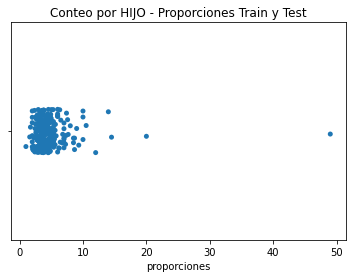

In [ ]:
#Grafico STRIPPLOT - Conteo por categorias - Train y test

sns.stripplot(data=hijo_proporciones,x='proporciones')
plt.title('Conteo por HIJO - Proporciones Train y Test')
plt.show()

### **1.1.8** Feature **D3D**: Distancia tridimensional entre la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre (DX^2+DY^2+DZ^2)/2

In [ ]:
#Train - Tipo de dato de la variable

df_train['D3D'].dtype

dtype('float64')

In [ ]:
#Test - Tipo de dato de la variable

df_test['D3D'].dtype

dtype('float64')



*   En ambos casos el tipo de datos corresponde a **float64**

In [ ]:
#Train - Valores de estadistica descriptiva

df_train['D3D'].describe()

count    2.617800e+04
mean     1.895747e+03
std      3.473443e+04
min      7.062635e+01
25%      7.125195e+02
50%      1.040079e+03
75%      1.312413e+03
max      1.596803e+06
Name: D3D, dtype: float64

In [ ]:
#Train - Primeros 20 registros ordenados de mayor a menor

df_train['D3D'].sort_values(ascending=False)[0:20]

24982    1.596803e+06
3573     1.528118e+06
18606    1.489298e+06
10950    1.467196e+06
23789    1.464684e+06
4034     1.434473e+06
15110    1.421505e+06
16358    1.332051e+06
5905     1.321943e+06
19022    1.317267e+06
16402    1.289196e+06
16325    1.284206e+06
8241     1.274278e+06
17199    1.228655e+06
6088     1.096844e+06
4044     1.092376e+06
1274     1.082138e+06
19969    9.476880e+05
4315     1.981235e+03
3219     1.901362e+03
Name: D3D, dtype: float64



*   Se observa un aumento sustancial en los valores de D3D luego del registro de indice **4315**



In [ ]:
#Test - Valores de estadistica descriptiva

df_test['D3D'].describe()

count    6537.000000
mean      997.210500
std       401.168230
min        75.549793
25%       720.116786
50%      1038.005791
75%      1319.845756
max      9999.000000
Name: D3D, dtype: float64

In [ ]:
#Test - Primeros 5 registros ordenados de mayor a menor
df_test['D3D'].sort_values(ascending=False)[0:5]

3688    9999.000000
1586    1956.263788
898     1856.374190
887     1834.162733
905     1786.209354
Name: D3D, dtype: float64

In [ ]:
#Observamos en particular el registro de indice 3688

df_test.loc[3688]

ID_FILA                     29867
ID_EVENTO      Pozo 463-Pozo 1-16
CAMPO                     Campo A
FLUIDO                        GAS
PAD_HIJO                    PAD-1
HIJO                     Pozo 463
ETAPA_HIJO                     16
PADRE                      Pozo 1
D3D                        9999.0
D2D                           0.0
DZ                            0.0
AZ                            0.0
#_BARRERAS                    0.0
LINEAMIENTO                    NO
WHP_i                       110.4
ESTADO                    Abierto
Name: 3688, dtype: object



*   El valor unico de 9999.0 en Test difiere mucho del siguiente valor cercano. Sumado a esto los valores en 0 de **D2D**,**DZ** y **AZ** podrian ser un indicio de un valor anomalo.

A continuacion se obtienen los registros en Train donde la distancia es mayor al valor del registro de indice **4315**

In [ ]:
#Registros en Train donde donde la distancia es mayor al valor del registro de indice 4315.

df_train_d3d_sup = df_train[df_train['D3D']>df_train.loc[4315]['D3D']]
df_train_d3d_sup

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
1274,1275,Pozo 551-Pozo 333-7,Campo E,OIL,PAD-84,Pozo 551,7,Pozo 333,1082138.0,1082.075464,11.633568,298.713364,0.0,NO,17.1,0.0,Abierto
3573,3574,Pozo 33-Pozo 65-51,Campo B,OIL,PAD-6,Pozo 33,51,Pozo 65,1528118.0,1528.065465,-12.671084,168.071909,1.0,NO,36.6,0.0,Abierto
4034,4035,Pozo 549-Pozo 377-8,Campo E,OIL,PAD-84,Pozo 549,8,Pozo 377,1434473.0,1434.417417,-12.627785,271.167793,0.0,NO,38.5,0.0,Abierto
4044,4045,Pozo 481-Pozo 117-16,Campo C,GAS,PAD-23,Pozo 481,16,Pozo 117,1092376.0,1092.341145,8.726281,237.825923,0.0,NO,38.6,0.0,Abierto
5905,5906,Pozo 357-Pozo 85-7,Campo F,OIL,PAD-81,Pozo 357,7,Pozo 85,1321943.0,1321.899136,-10.768827,47.091375,1.0,NO,44.3,0.0,Abierto
6088,6089,Pozo 32-Pozo 42-47,Campo B,OIL,PAD-6,Pozo 32,47,Pozo 42,1096844.0,1096.482940,28.141115,191.870777,0.0,NO,44.9,0.0,Abierto
8241,8242,Pozo 197-Pozo 188-6,Campo D,OIL,PAD-44,Pozo 197,6,Pozo 188,1274278.0,1273.105786,54.645029,178.905102,0.0,NO,55.5,0.0,Abierto
10950,10951,Pozo 480-Pozo 108-12,Campo C,GAS,PAD-21,Pozo 480,12,Pozo 108,1467196.0,1467.181845,6.444878,327.256270,1.0,NO,93.2,0.0,Abierto
15110,15111,Pozo 488-Pozo 137-4,Campo C,GAS,PAD-28,Pozo 488,4,Pozo 137,1421505.0,1420.350304,57.284192,28.352221,3.0,NO,317.8,0.0,Abierto
16325,16326,Pozo 489-Pozo 128-17,Campo C,GAS,PAD-28,Pozo 489,17,Pozo 128,1284206.0,1282.891842,58.082460,271.212328,5.0,NO,393.1,0.0,Abierto




*   Se observa que los valores de **D3D** en este subconjunto tienen distancias muy grandes. Observando los valores de **D2D** y **DZ** es de considerar que los valores de **D3D** sean anomalos por tener desplazado el punto decimal y sea necesario corregirlos.

In [ ]:
#Partiendo de Train se crea un nuevo dataframe sin considerar el subconjunto de registros observados anteriormente.

df_train_d3d = df_train[~df_train.index.isin(df_train_d3d_sup.index)]

#Valores de estadistica descriptiva

df_train_d3d['D3D'].describe()

count    26160.000000
mean       992.284256
std        387.164601
min         70.626349
25%        712.423268
50%       1039.712297
75%       1311.641056
max       1981.235356
Name: D3D, dtype: float64



*   Al excluir los registros con grandes valores de D3D los resultados de estadistica descriptiva se ven modificados y se asemejan a los valores en Test (salvo por el registro de indice 3688 con valor D3D 9999.0)



In [ ]:
#En test se excluye el valor de 9999.0 correspondiente al registro de indice 3688

df_test_d3d = df_test[~df_test.index.isin([3688])]

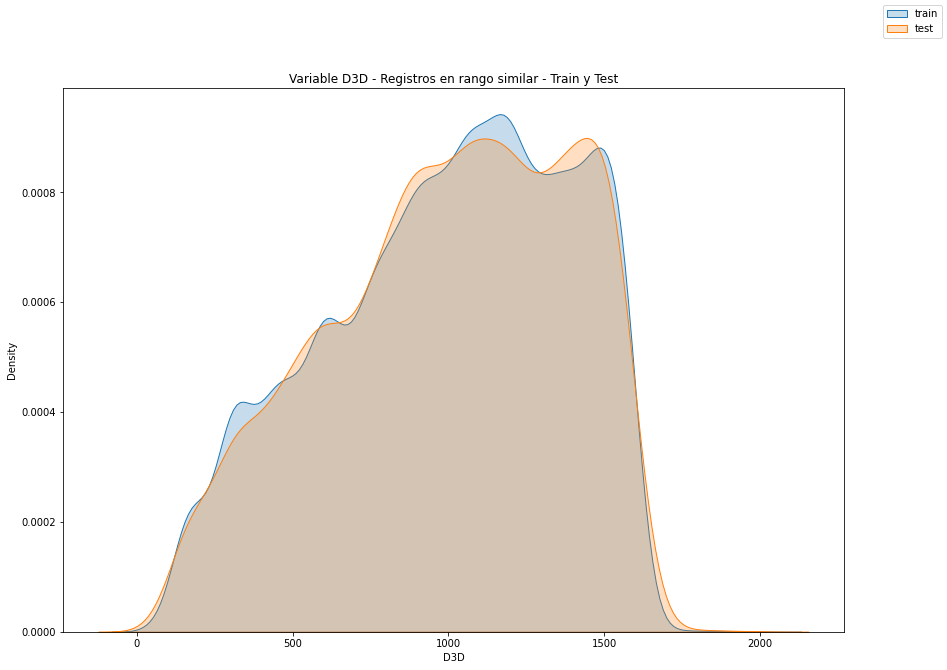

In [ ]:
#Grafico KDE - Train y test
#No se consideran los registros de Train y Test excluidos
#De esta forma consideramos los registros en ambos datasets con rangos de valores similares

fig = plt.figure(figsize=(14,10))
sns.kdeplot(data=df_train_d3d, x='D3D',fill=True)
sns.kdeplot(data=df_test_d3d, x='D3D',fill=True)
fig.legend(labels=['train','test'])
plt.title('Variable D3D - Registros en rango similar - Train y Test')
plt.show()

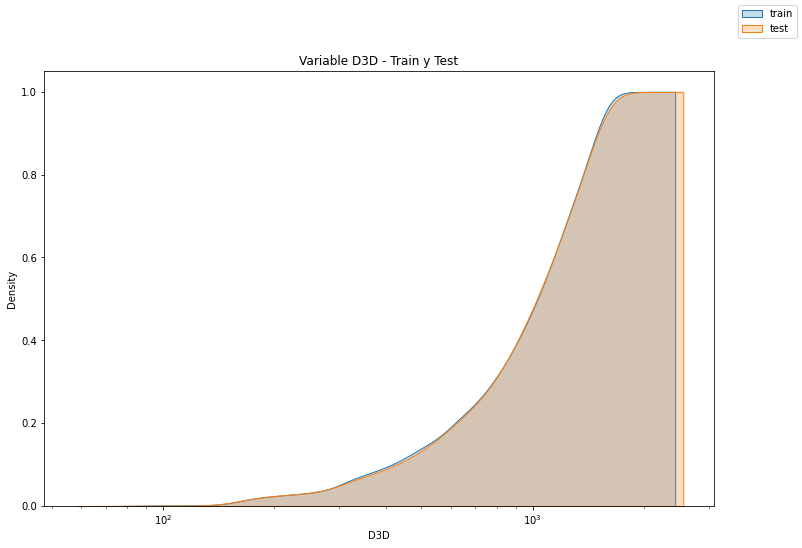

In [ ]:
#Grafico KDE acumulativo - Train y test - Escala logaritmica
#No se consideran los registros de Train y Test excluidos

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train_d3d, x='D3D',fill=True,log_scale=True,cumulative=True)
sns.kdeplot(data=df_test_d3d, x='D3D',fill=True,log_scale=True,cumulative=True)
fig.legend(labels=['train','test'])
plt.title('Variable D3D - Train y Test')
plt.show()

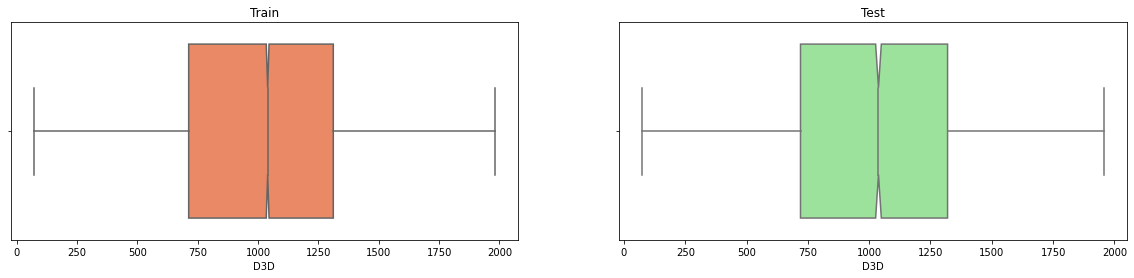

In [ ]:
#Grafico Boxplot - Train y test
#No se consideran los registros de Train y Test excluidos

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.boxplot(data=df_train_d3d, x="D3D",color='coral',notch=True,ax=axs[0])
sns.boxplot(data=df_test_d3d, x="D3D",color='lightgreen',notch=True,ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

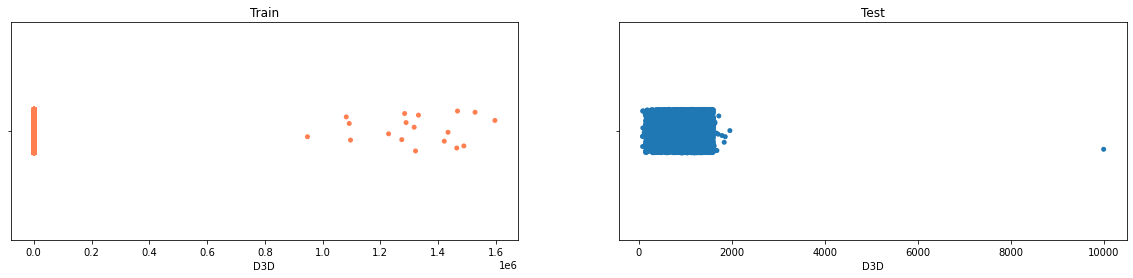

In [ ]:
#Grafico STRIPPLOT
#Train y Test con registros originales

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.stripplot(data=df_train, x="D3D",ax=axs[0],color='coral')
sns.stripplot(data=df_test, x="D3D",ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()



*   Se observa que considear los valores originales distorsiona fuertemente la distribucion



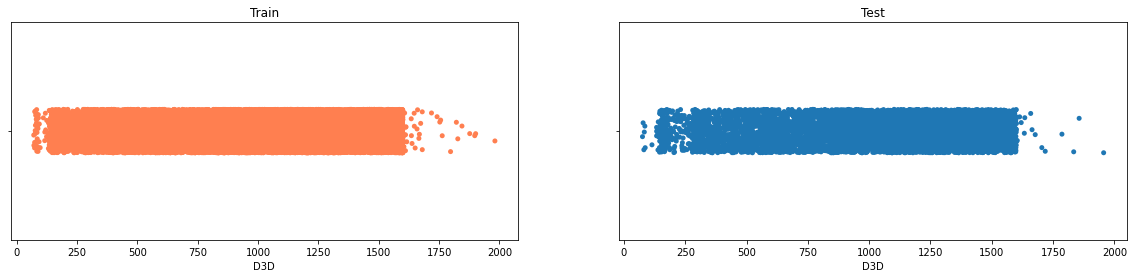

In [ ]:
#Grafico STRIPPLOT
#No se consideran los registros de Train y Test excluidos

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.stripplot(data=df_train_d3d, x="D3D",ax=axs[0],color='coral')
sns.stripplot(data=df_test_d3d, x="D3D",ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

### **1.1.9** Variable **D2D**:Distancia en planta (vista de pajaro - sin considerar distancia vertical) entre la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre (DX^2+DY^2)*(1/2)

In [ ]:
#Train - Tipo de dato de la variable

df_train['D2D'].dtype

dtype('float64')

In [ ]:
# Test - Tipo de dato de la variable

df_test['D2D'].dtype

dtype('float64')



*   En ambos casos el tipo de datos corresponde a **float64**

In [ ]:
#Train - Valores de estadistica descriptiva

df_train['D2D'].describe()

count    2.617800e+04
mean     1.581289e+03
std      2.784022e+04
min      2.021954e+01
25%      7.118214e+02
50%      1.039356e+03
75%      1.311902e+03
max      1.509322e+06
Name: D2D, dtype: float64

In [ ]:
#Train - Primeros 20 registros ordenados de mayor a menor

df_train['D2D'].sort_values(ascending=False)[0:20]

13329    1.509322e+06
13984    1.485008e+06
769      1.483978e+06
10522    1.472258e+06
6801     1.440382e+06
7786     1.391304e+06
23406    1.239607e+06
4458     1.210984e+06
6354     1.096278e+06
15457    1.084562e+06
12563    1.036657e+06
9568     1.002835e+06
4315     1.981186e+03
3219     1.901318e+03
5323     1.897626e+03
3202     1.876107e+03
306      1.844698e+03
18299    1.827425e+03
3876     1.821487e+03
4461     1.796744e+03
Name: D2D, dtype: float64


*   Se observa un aumento sustancial en los valores de D2D luego del registro de indice **4315**

In [ ]:
#Test - Valores de estadistica descriptiva

df_test['D2D'].describe()

count    6537.000000
mean      994.780254
std       386.429793
min         0.000000
25%       718.614244
50%      1037.749199
75%      1319.676501
max      1955.459950
Name: D2D, dtype: float64

A continuacion se obtienen los registros en Train donde la distancia es mayor al valor del registro de indice **4315**.

In [ ]:
#Registros en Train donde donde la distancia es mayor al valor del registro de indice 4315.

df_train_d2d_sup = df_train[df_train['D2D']>df_train.loc[4315]['D2D']]
df_train_d2d_sup

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
769,770,Pozo 554-Pozo 347-17,Campo E,OIL,PAD-85,Pozo 554,17,Pozo 347,1484.012631,1483978.0,10.138302,33.109146,2.0,NO,11.8,0.0,Abierto
4458,4459,Pozo 319-Pozo 310-16,Campo F,OIL,PAD-69,Pozo 319,16,Pozo 310,1211.041704,1210984.0,-11.822073,89.324574,0.0,NO,40.1,0.0,Abierto
6354,6355,Pozo 357-Pozo 85-12,Campo F,OIL,PAD-81,Pozo 357,12,Pozo 85,1096.280540,1096278.0,2.359945,62.845447,1.0,NO,45.6,0.0,Abierto
6801,6802,Pozo 557-Pozo 66-20,Campo E,OIL,PAD-85,Pozo 557,20,Pozo 66,1440.386296,1440382.0,-3.518088,298.522022,3.0,NO,47.1,0.0,Abierto
7786,7787,Pozo 315-Pozo 285-19,Campo E,OIL,PAD-72,Pozo 315,19,Pozo 285,1391.705080,1391304.0,33.409723,136.812237,2.0,NO,52.6,0.0,Abierto
9568,9569,Pozo 481-Pozo 109-22,Campo C,GAS,PAD-23,Pozo 481,22,Pozo 109,1002.839515,1002835.0,-3.009188,274.262599,1.0,NO,68.5,0.0,Abierto
10522,10523,Pozo 551-Pozo 402-13,Campo E,OIL,PAD-84,Pozo 551,13,Pozo 402,1472.272247,1472258.0,-6.476867,94.412389,2.0,NO,88.1,0.0,Abierto
12563,12564,Pozo 149-Pozo 147-6,Campo C,GAS,PAD-25,Pozo 149,6,Pozo 147,1037.062361,1036657.0,-28.993193,97.859924,1.0,NO,154.2,0.0,Abierto
13329,13330,Pozo 231-Pozo 82-3,Campo F,OIL,PAD-59,Pozo 231,3,Pozo 82,1509.531426,1509322.0,25.144129,164.403446,0.0,NO,203.7,0.0,Abierto
13984,13985,Pozo 136-Pozo 114-2,Campo C,GAS,PAD-24,Pozo 136,2,Pozo 114,1485.010299,1485008.0,-2.612696,288.093477,0.0,NO,248.2,0.0,Abierto


*   Se observa que los valores de **D2D** en este subconjunto tienen distancias muy grandes. Observando los valores de **D3D** y **DZ** es de considerar que los valores de **DD** sean anomalos por tener desplazado el punto decimal y sea necesario corregirlos.

In [ ]:
#Partiendo de Train se crea un nuevo dataframe sin considerar el subconjunto de registros observados anteriormente.

df_train_d2d = df_train[~df_train.index.isin(df_train_d2d_sup.index)]

#Valores de estadistica descriptiva

df_train_d2d['D2D'].describe()

count    26166.000000
mean       991.431473
std        388.049416
min         20.219536
25%        711.685976
50%       1039.216060
75%       1311.456120
max       1981.186446
Name: D2D, dtype: float64

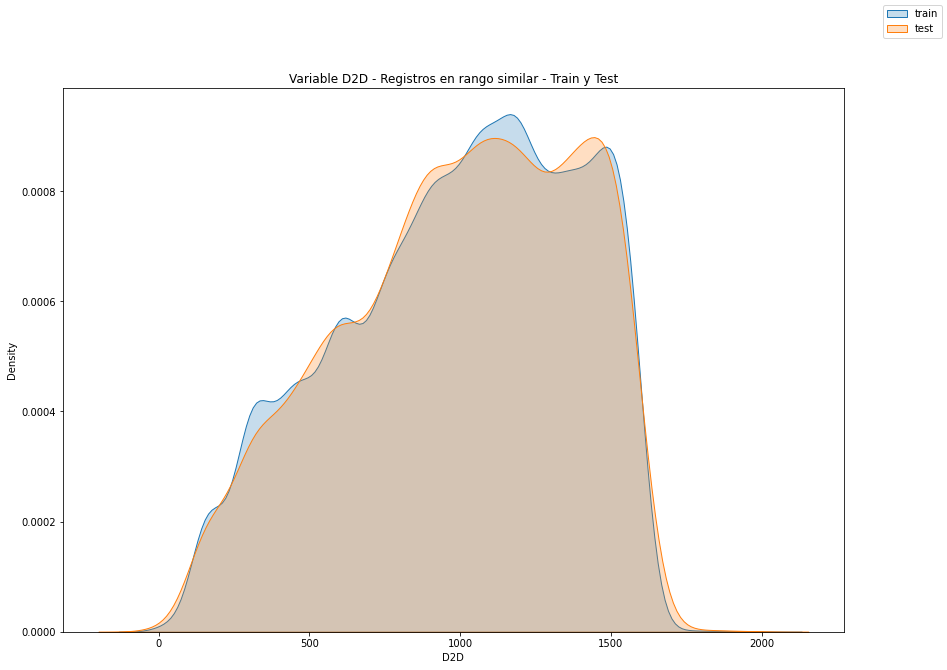

In [ ]:
#Grafico KDE - Train y test
#No se consideran los registros de Train excluidos
#De esta forma consideramos los registros en ambos datasets con rangos de valores similares

fig = plt.figure(figsize=(14,10))
sns.kdeplot(data=df_train_d2d, x='D2D',fill=True)
sns.kdeplot(data=df_test, x='D2D',fill=True)
fig.legend(labels=['train','test'])
plt.title('Variable D2D - Registros en rango similar - Train y Test')
plt.show()



*   En Test uno de los valores es igual a 0, por lo tanto para poder graficar el KDE acumulativo es necesario excluirlo

In [ ]:
#Registro de test donde D2D es igual a 0

df_test[df_test['D2D'] == 0]

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
3688,29867,Pozo 463-Pozo 1-16,Campo A,GAS,PAD-1,Pozo 463,16,Pozo 1,9999.0,0.0,0.0,0.0,0.0,NO,110.4,Abierto




*   Se observa nuevamente en Test el registro de indice **3688** que se observo cuando se analisis del feature **D3D**



In [ ]:
#Indices de aquelos valores D2Dque son 0

test_index_d2d = df_test[df_test['D2D']==0].index

#Se crea un nuevo dataframe sin las filas donde los valores de D2D son 0

df_test_d2d = df_test[~df_test.index.isin(test_index_d2d)]

#Valores de estadistica descriptiva

df_test_d2d['D2D'].describe()

count    6536.000000
mean      994.932454
std       386.263360
min        26.340308
25%       718.929912
50%      1037.750614
75%      1319.686238
max      1955.459950
Name: D2D, dtype: float64

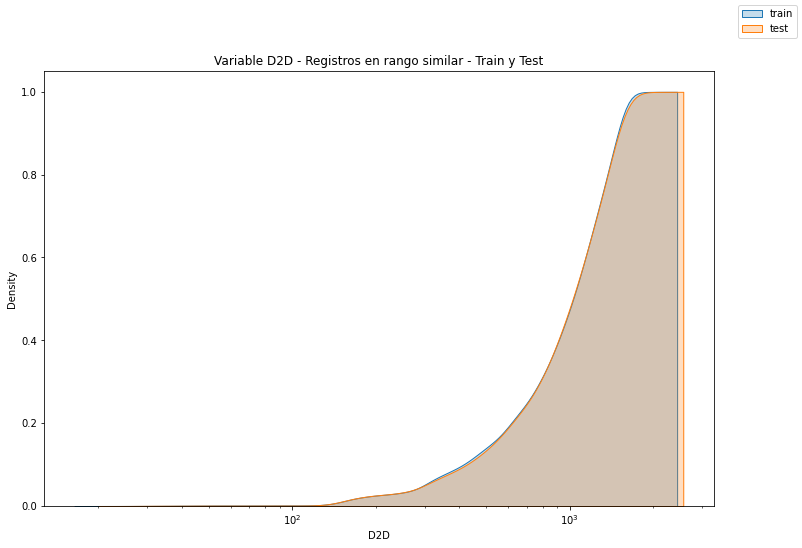

In [ ]:
#Grafico KDE acumulativo - Train y test - Escala logaritmica
#No se consideran los registros de Train y Test excluidos

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train_d2d, x='D2D',fill=True,log_scale=True,cumulative=True)
sns.kdeplot(data=df_test_d2d, x='D2D',fill=True,log_scale=True,cumulative=True)
fig.legend(labels=['train','test'])
plt.title('Variable D2D - Registros en rango similar - Train y Test')
plt.show()

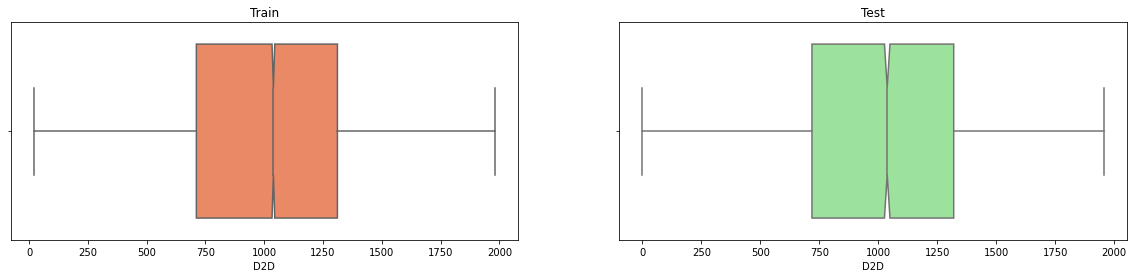

In [ ]:
#Grafico Boxplot - Train y test
#No se consideran los registros de Train

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.boxplot(data=df_train_d2d, x="D2D",color='coral',notch=True,ax=axs[0])
sns.boxplot(data=df_test, x="D2D",color='lightgreen',notch=True,ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

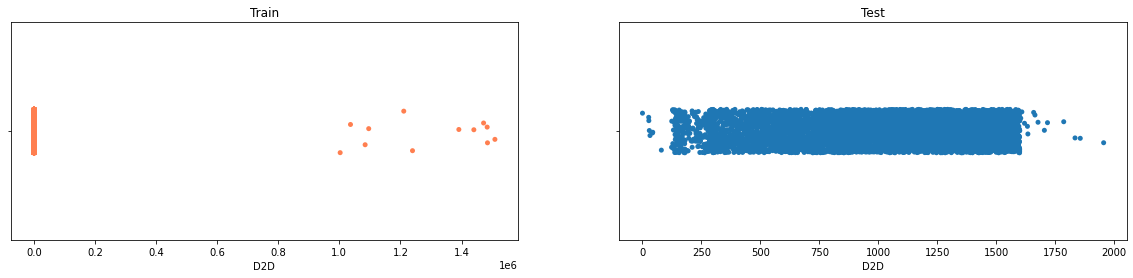

In [ ]:
#Grafico STRIPPLOT
#Train y test con registros originales

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.stripplot(data=df_train, x="D2D",ax=axs[0],color='coral')
sns.stripplot(data=df_test, x="D2D",ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

*   Se observa que considear los valores originales de D2D distorsiona fuertemente la distribucion


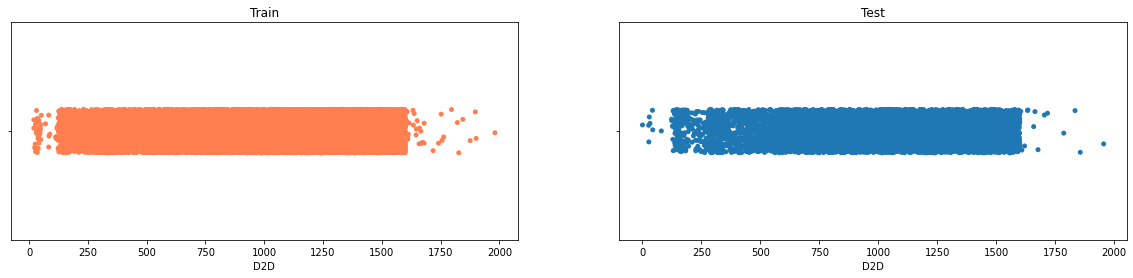

In [ ]:
#Grafico STRIPPLOT
#No se consideran los registros de Train y Test excluidos

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.stripplot(data=df_train_d2d, x="D2D",ax=axs[0],color='coral')
sns.stripplot(data=df_test, x="D2D",ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

### **1.1.10** Feature **DZ**: Distancia vertical (diferencia de altura) entre la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre

In [ ]:
#Train - Tipo de dato de la variable

df_train['DZ'].dtype

dtype('float64')

In [ ]:
#Test - Tipo de dato de la variable

df_test['DZ'].dtype

dtype('float64')


*   En ambos casos el tipo de datos corresponde a **float64**

In [ ]:
#Train - Valores de estadistica descriptiva

df_train['DZ'].describe()

count    26178.000000
mean        16.018874
std         30.351291
min        -59.984196
25%         -4.570704
50%         13.179981
75%         38.114759
max        196.058428
Name: DZ, dtype: float64

In [ ]:
#Test - Valores de estadistica descriptiva

df_test['DZ'].describe()

count    6537.000000
mean       15.446887
std        30.236933
min       -60.138335
25%        -5.510836
50%        12.635284
75%        37.906840
max       187.857935
Name: DZ, dtype: float64

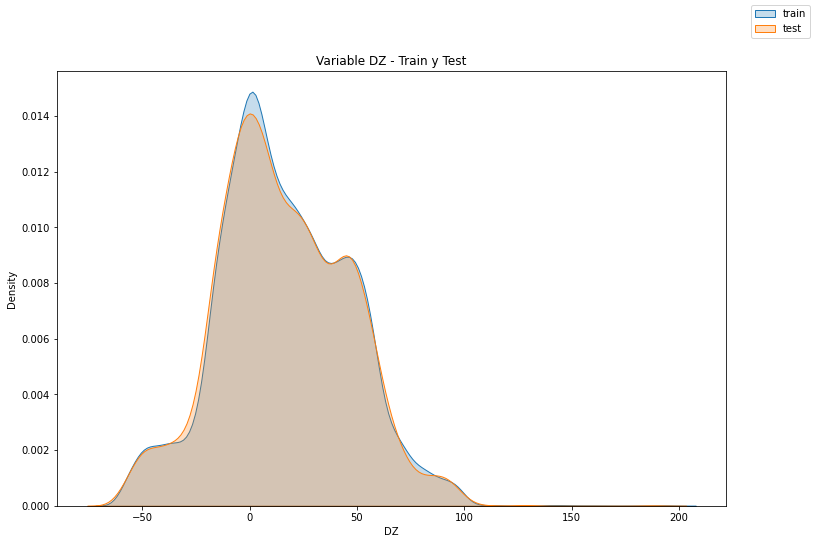

In [ ]:
#Grafico KDE - Train y Test

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train, x='DZ',fill=True)
sns.kdeplot(data=df_test, x='DZ',fill=True)
fig.legend(labels=['train','test'])
plt.title('Variable DZ - Train y Test')
plt.show()

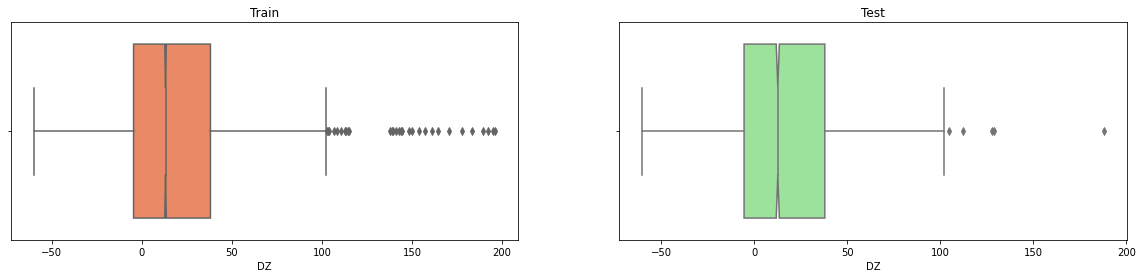

In [ ]:
#Grafico Boxplot - Train y Test

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.boxplot(data=df_train, x="DZ",color='coral',notch=True,ax=axs[0])
sns.boxplot(data=df_test, x="DZ",color='lightgreen',notch=True,ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

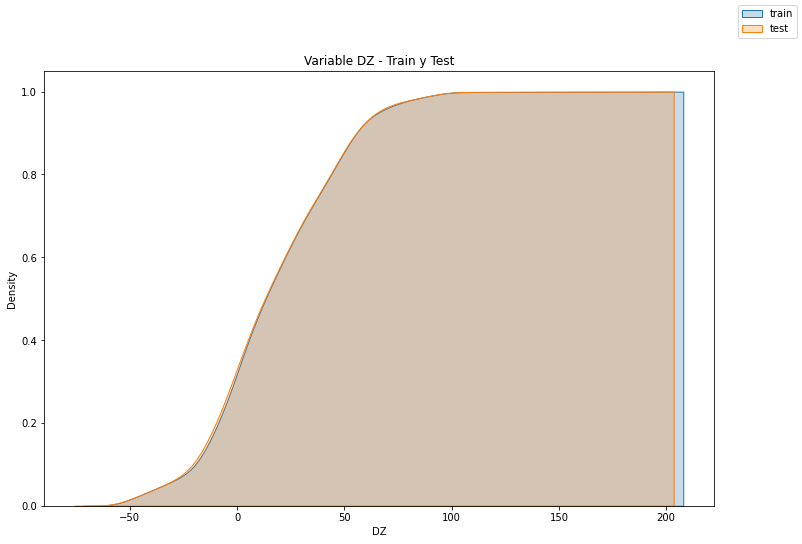

In [ ]:
#Grafico KDE acumulativo - Train y Test

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train, x='DZ',fill=True,cumulative=True)
sns.kdeplot(data=df_test, x='DZ',fill=True,cumulative=True)
fig.legend(labels=['train','test'])
plt.title('Variable DZ - Train y Test')
plt.show()

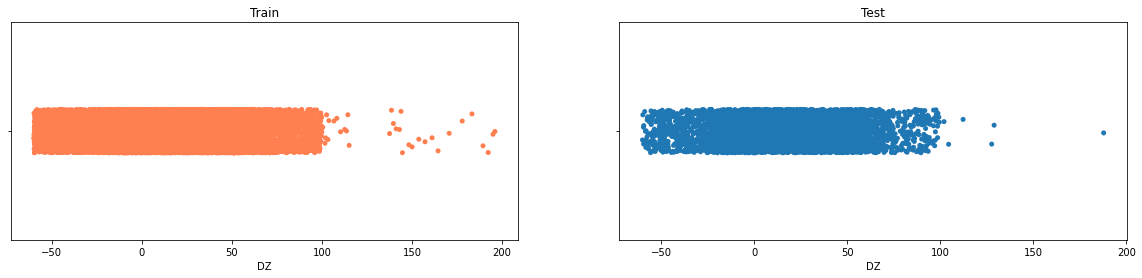

In [ ]:
#Grafico STRIPPLOT - Train y Test

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.stripplot(data=df_train, x="DZ",ax=axs[0],color='coral')
sns.stripplot(data=df_test, x="DZ",ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

### **1.1.11** Feature **AZ**: Angulo respecto al norte que forma la linea recta que une la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre

In [ ]:
#Train - Tipo de dato de la variable

df_train['AZ'].dtype

dtype('float64')

In [ ]:
#Test - Tipo de dato de la variable

df_test['AZ'].dtype

dtype('float64')



*   En ambos casos el tipo de datos corresponde a **float64**

In [ ]:
#Train - Valores de estadistica descriptiva

df_train['AZ'].describe()

count     26178.000000
mean        198.880267
std        1377.390169
min           0.029378
25%          90.467178
50%         201.270318
75%         271.383555
max      177932.000000
Name: AZ, dtype: float64

In [ ]:
#Test - Valores de estadistica descriptiva

df_test['AZ'].describe()

count    6537.000000
mean      189.022860
std       101.153112
min         0.000000
25%        90.718557
50%       205.623759
75%       272.247023
max       359.987171
Name: AZ, dtype: float64



*   Segun se observa en **Train** existen valores de **AZ** superiores a **360**, lo cual en principio  se supone corresponde a valores anomalos.

In [ ]:
#Train - Identificacion de registros donde AZ > 360

df_train[df_train['AZ']>360]

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
4387,4388,Pozo 406-Pozo 227-1,Campo F,OIL,PAD-60,Pozo 406,1,Pozo 227,1538.899524,1538.892309,-4.712397,177932.0,0.0,NO,39.9,0.0,Abierto
18708,18709,Pozo 553-Pozo 281-9,Campo E,OIL,PAD-85,Pozo 553,9,Pozo 281,616.114421,614.116615,49.575823,133633.0,0.0,NO,45.3,0.0,Cerrado


In [ ]:
#Train - Indices de aquelos valores donde AZ > 360

train_index_az = df_train[df_train['AZ']>360].index

#Se crea un nuevo dataframe sin los registros donde donde AZ > 360

df_train_az = df_train[~df_train.index.isin(train_index_az)]

#Valores de estadistica descriptiva

df_train_az['AZ'].describe()

count    26176.000000
mean       186.992766
std        100.747067
min          0.029378
25%         90.464636
50%        201.242563
75%        271.381673
max        359.998020
Name: AZ, dtype: float64

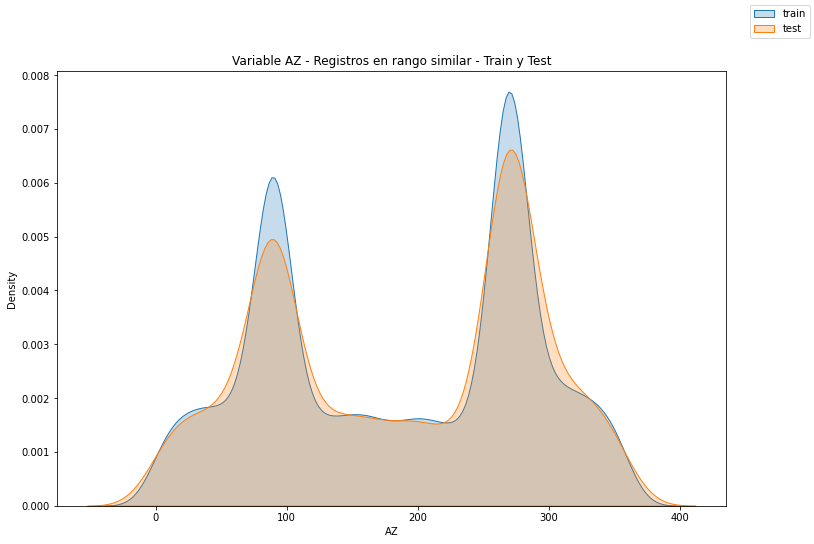

In [ ]:
#Grafico KDE - Train y test
#No se consideran los registros de Train excluidos

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train_az, x='AZ',fill=True)
sns.kdeplot(data=df_test, x='AZ',fill=True)
fig.legend(labels=['train','test'])
plt.title('Variable AZ - Registros en rango similar - Train y Test')
plt.show()

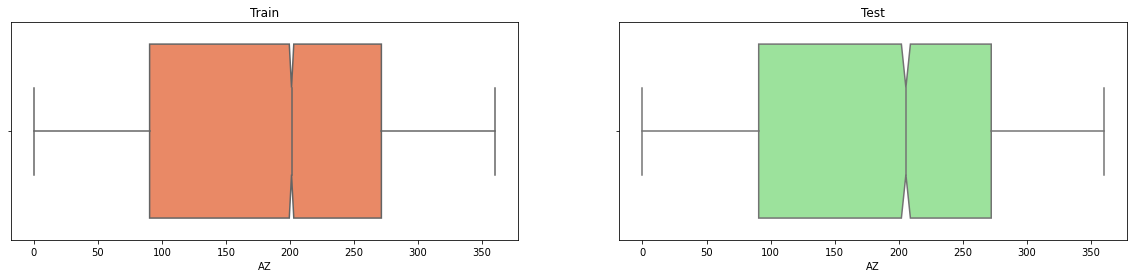

In [ ]:
#Grafico Boxplot - Train y test
#No se consideran los registros de Train excluidos

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.boxplot(data=df_train_az, x="AZ",color='coral',notch=True,ax=axs[0])
sns.boxplot(data=df_test, x="AZ",color='lightgreen',notch=True,ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

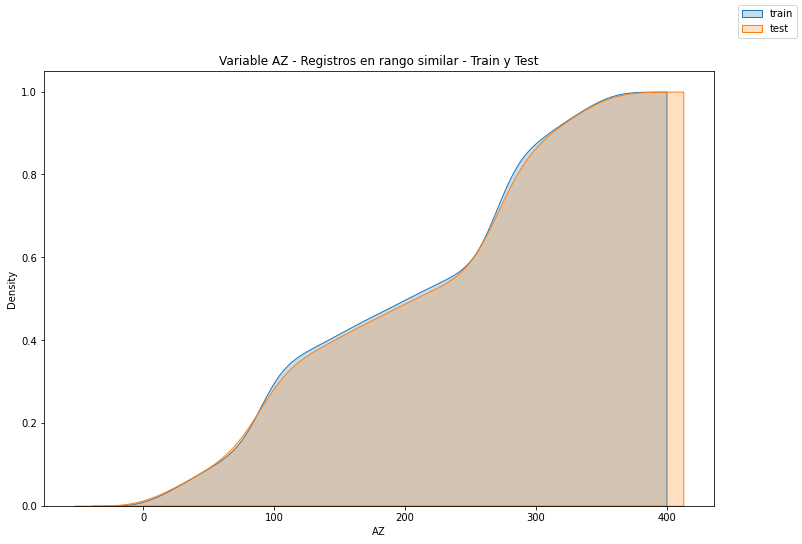

In [ ]:
#Grafico KDE acumulativo - Train y Test
#No se consideran los registros de train excluidos

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train_az, x='AZ',fill=True,cumulative=True)
sns.kdeplot(data=df_test, x='AZ',fill=True,cumulative=True)
fig.legend(labels=['train','test'])
plt.title('Variable AZ - Registros en rango similar - Train y Test')
plt.show()

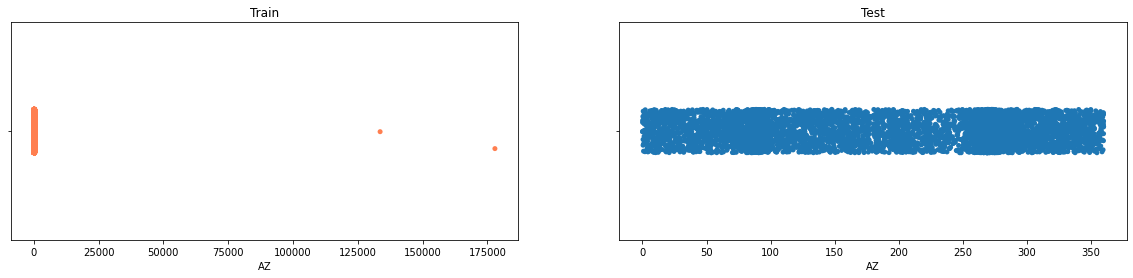

In [ ]:
#Grafico STRIPPLOT
#Train y Test con registros originales

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.stripplot(data=df_train, x="AZ",ax=axs[0],color='coral')
sns.stripplot(data=df_test, x="AZ",ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

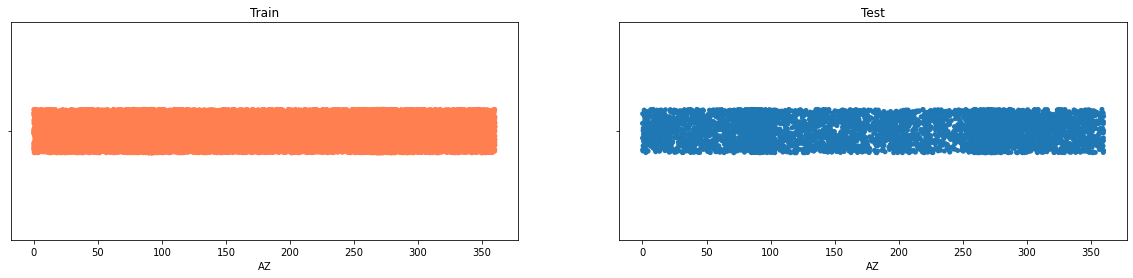

In [ ]:
#Grafico STRIPPLOT
#No se consideran los registros de Train excluidos

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.stripplot(data=df_train_az, x="AZ",ax=axs[0],color='coral')
sns.stripplot(data=df_test, x="AZ",ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

### **1.1.12** Feature **#_BARRERAS**: Cantidad de pozos padre entre el Pozo Hijo y el Pozo Padre considerado. Se consideran todos los pozos atravesados por la linea considerada en la D2D, y dentro de un espacio vertical que abarca toda la distancia vertical entre Pozo Hijo y Pozo Padre más 40m por encima y por debajo.

In [ ]:
#Train - Tipo de dato de la variable

df_train['#_BARRERAS'].dtype

dtype('float64')

In [ ]:
#Test - Tipo de dato de la variable

df_test['#_BARRERAS'].dtype

dtype('float64')



*   En ambos casos el tipo de dato corresponde a **float64**

In [ ]:
#Train - Cantidad de registros por valor

df_train['#_BARRERAS'].value_counts()

0.0    13449
1.0     6640
2.0     3106
3.0     1756
4.0      760
5.0      342
6.0       88
7.0       26
8.0        9
9.0        2
Name: #_BARRERAS, dtype: int64

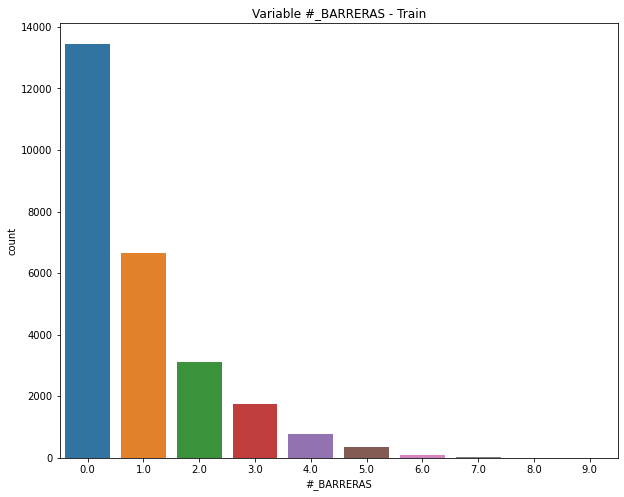

In [ ]:
#Grafico COUNTPLOT - Train

fig = plt.figure(figsize=(10,8))
sns.countplot(x=df_train["#_BARRERAS"])
plt.title('Variable #_BARRERAS - Train')
plt.show()

In [ ]:
#Test - Cantidad de registros por valor

df_test['#_BARRERAS'].value_counts()

0.0    3324
1.0    1675
2.0     787
3.0     432
4.0     167
5.0     112
6.0      28
7.0      10
8.0       2
Name: #_BARRERAS, dtype: int64

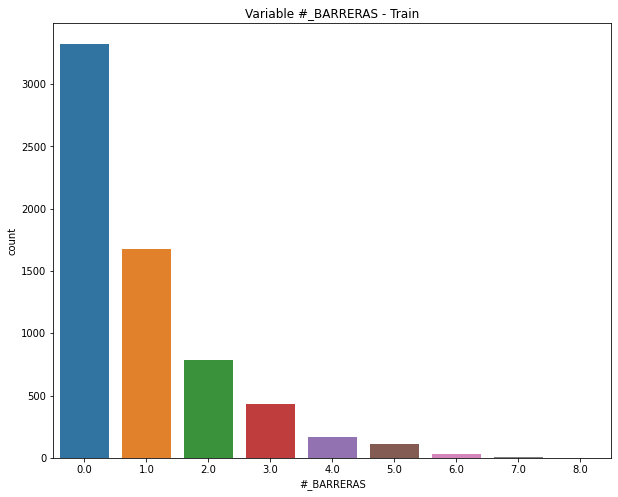

In [ ]:
#Grafico COUNTPLOT - Test

fig = plt.figure(figsize=(10,8))
sns.countplot(x=df_test["#_BARRERAS"])
plt.title('Variable #_BARRERAS - Train')
plt.show()

In [ ]:
#Proporciones entre Train y Test por conteo de categoria

barreras_proporciones = df_train['#_BARRERAS'].value_counts() / df_test['#_BARRERAS'].value_counts()
barreras_proporciones.sort_values(ascending=False)

4.0    4.550898
8.0    4.500000
3.0    4.064815
0.0    4.046029
1.0    3.964179
2.0    3.946633
6.0    3.142857
5.0    3.053571
7.0    2.600000
9.0         NaN
Name: #_BARRERAS, dtype: float64

### **1.1.13** Feature **LINEAMIENTO**: Anomalías geológicas que atraviesan al Pozo Hijo y Pozo Padre.

In [ ]:
#Train - Tipo de dato de la variable

df_train['LINEAMIENTO'].dtype

dtype('O')

In [ ]:
#Test - Tipo de dato de la variable

df_test['LINEAMIENTO'].dtype

dtype('O')



*   En ambos casos el tipo de datos corresponde a **object**

In [ ]:
#Train - Cantidad de registros por valor

df_train['LINEAMIENTO'].value_counts()

NO    25617
SI      561
Name: LINEAMIENTO, dtype: int64

In [ ]:
#Test - Cantidad de registros por valor

df_test['LINEAMIENTO'].value_counts()

NO    6374
SI     163
Name: LINEAMIENTO, dtype: int64

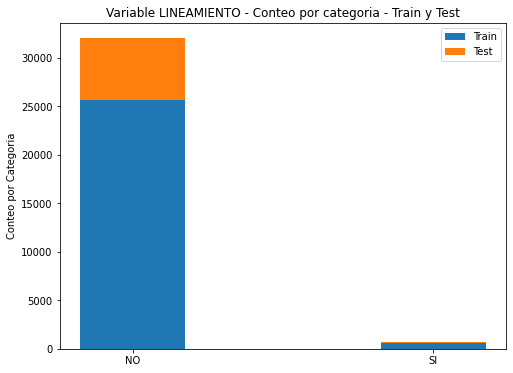

In [ ]:
#Grafico de conteo por categoria en Train y Test

labels = ['NO','SI']
lineamiento_train = df_train['LINEAMIENTO'].value_counts().values
lineamiento_test = df_test['LINEAMIENTO'].value_counts().values
width = 0.35

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(8)

ax.bar(labels, lineamiento_train, width,label='Train')
ax.bar(labels, lineamiento_test, width, bottom=lineamiento_train,label='Test')

ax.set_ylabel('Conteo por Categoria')
ax.set_title('Variable LINEAMIENTO - Conteo por categoria - Train y Test')
ax.legend()

plt.show()

In [ ]:
#Proporciones entre Train y Test por conteo de categoria

lineamiento_proporciones = df_train['LINEAMIENTO'].value_counts() / df_test['LINEAMIENTO'].value_counts()
lineamiento_proporciones.sort_values(ascending=False)

NO    4.018983
SI    3.441718
Name: LINEAMIENTO, dtype: float64

### **1.1.14** Feature **WHP_i**: Presión al inicio de la interferencia.



In [ ]:
#Train - Tipo de dato de la variable

df_train['WHP_i'].dtype

dtype('float64')

In [ ]:
#Test - Tipo de dato de la variable

df_test['WHP_i'].dtype

dtype('float64')



*   En ambos casos el tipo de datos corresponde a **float64**

In [ ]:
#Train - Valores de estadistica descriptiva

df_train['WHP_i'].describe()

count    26178.000000
mean       139.688731
std        128.197956
min         -0.400000
25%         41.100000
50%         84.200000
75%        236.300000
max        551.800000
Name: WHP_i, dtype: float64

In [ ]:
#Train - Registros donde WHP_i < 0

df_train[df_train['WHP_i'] < 0]['WHP_i'].describe()

count    97.000000
mean     -0.165979
std       0.081505
min      -0.400000
25%      -0.200000
50%      -0.100000
75%      -0.100000
max      -0.100000
Name: WHP_i, dtype: float64

In [ ]:
#Train - Registros donde WHP_i < 0

df_train[df_train['WHP_i'] < 0]

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
0,1,Pozo 81-Pozo 22-37,Campo D,OIL,PAD-47,Pozo 81,37,Pozo 22,1323.623144,1323.212672,32.961374,199.623188,0.0,NO,-0.2,0.0,Abierto
1,2,Pozo 132-Pozo 112-10,Campo C,GAS,PAD-19,Pozo 132,10,Pozo 112,1184.248919,1184.233308,6.080755,345.025732,0.0,NO,-0.1,0.0,Abierto
2,3,Pozo 133-Pozo 112-21,Campo C,GAS,PAD-19,Pozo 133,21,Pozo 112,847.811857,847.771101,8.312941,342.171963,0.0,NO,-0.1,0.0,Abierto
3,4,Pozo 478-Pozo 122-6,Campo C,GAS,PAD-21,Pozo 478,6,Pozo 122,625.328398,625.314697,4.139460,259.131395,1.0,NO,-0.1,0.0,Abierto
4,5,Pozo 405-Pozo 242-19,Campo F,OIL,PAD-60,Pozo 405,19,Pozo 242,1118.214531,1118.074170,17.716903,90.993004,3.0,NO,-0.1,0.0,Abierto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25935,25936,Pozo 407-Pozo 11-4,Campo F,OIL,PAD-60,Pozo 407,4,Pozo 11,728.956309,726.782489,56.254019,270.626167,1.0,SI,-0.1,0.0,Cerrado
25936,25937,Pozo 408-Pozo 241-14,Campo F,OIL,PAD-60,Pozo 408,14,Pozo 241,509.987540,507.440008,-50.910994,89.488533,1.0,SI,-0.1,0.0,Cerrado
25937,25938,Pozo 407-Pozo 241-32,Campo F,OIL,PAD-60,Pozo 407,32,Pozo 241,652.384153,651.945240,-23.926690,92.843846,2.0,SI,-0.1,0.0,Cerrado
25938,25939,Pozo 407-Pozo 241-35,Campo F,OIL,PAD-60,Pozo 407,35,Pozo 241,651.950775,651.472599,-24.965286,83.280695,2.0,SI,-0.1,0.0,Cerrado




*   En **Train** existen **97 registros** donde los valores de WHP_i son menores a 0. Estos valores de presion de estimulacion no tienen sentido fisico y es de suponer por los valores que se observan que corresponden a deriva en el instrumento de medicion


In [ ]:
#Test - Valores de estadistica descriptiva

df_test['WHP_i'].describe()

count    6537.000000
mean      137.991020
std       127.020354
min        -0.300000
25%        40.700000
50%        83.800000
75%       232.300000
max       536.800000
Name: WHP_i, dtype: float64

In [ ]:
#Test - Registros donde WHP_i < 0

df_test[df_test['WHP_i'] < 0]

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
0,26179,Pozo 27-Pozo 54-38,Campo B,OIL,PAD-13,Pozo 27,38,Pozo 54,1583.887656,1583.666853,-26.446264,143.640741,1.0,NO,-0.3,Cerrado
1,26180,Pozo 29-Pozo 54-39,Campo B,OIL,PAD-13,Pozo 29,39,Pozo 54,1477.040698,1476.930670,18.028312,147.363305,1.0,NO,-0.3,Cerrado
2,26181,Pozo 27-Pozo 54-41,Campo B,OIL,PAD-13,Pozo 27,41,Pozo 54,1445.963183,1445.750399,-24.805432,139.270555,1.0,NO,-0.3,Cerrado
3,26182,Pozo 555-Pozo 69-4,Campo E,OIL,PAD-85,Pozo 555,4,Pozo 69,672.288788,672.248439,7.365507,232.229747,0.0,NO,-0.3,Cerrado
4,26183,Pozo 555-Pozo 69-5,Campo E,OIL,PAD-85,Pozo 555,5,Pozo 69,642.817440,642.776548,7.250530,236.785609,0.0,NO,-0.3,Cerrado
5,26184,Pozo 555-Pozo 69-6,Campo E,OIL,PAD-85,Pozo 555,6,Pozo 69,616.040814,615.997726,7.286066,241.672900,1.0,NO,-0.2,Cerrado
6,26185,Pozo 557-Pozo 69-6,Campo E,OIL,PAD-85,Pozo 557,6,Pozo 69,896.154110,896.153105,-1.342111,249.274249,1.0,NO,-0.2,Cerrado
7,26186,Pozo 555-Pozo 69-7,Campo E,OIL,PAD-85,Pozo 555,7,Pozo 69,591.968936,591.901479,8.936463,246.886299,1.0,NO,-0.2,Cerrado
8,26187,Pozo 132-Pozo 112-15,Campo C,GAS,PAD-19,Pozo 132,15,Pozo 112,793.430284,793.204209,18.939333,341.872266,0.0,NO,-0.1,Abierto
9,26188,Pozo 133-Pozo 112-16,Campo C,GAS,PAD-19,Pozo 133,16,Pozo 112,1237.947445,1237.922328,-7.885896,344.911450,1.0,NO,-0.1,Abierto


In [ ]:
#Test - Registros donde WHP_i < 0

df_test[df_test['WHP_i'] < 0]['WHP_i'].describe()

count    25.000000
mean     -0.156000
std       0.082057
min      -0.300000
25%      -0.200000
50%      -0.100000
75%      -0.100000
max      -0.100000
Name: WHP_i, dtype: float64


*   Al igual que en Train en **Test** existen **25 registros** donde los valores de WHP_i son menores a 0. Estos valores de presion de estimulacion no tienen sentido fisico y es de suponer por los valores que se observan que corresponden a deriva en el instrumento de medicion


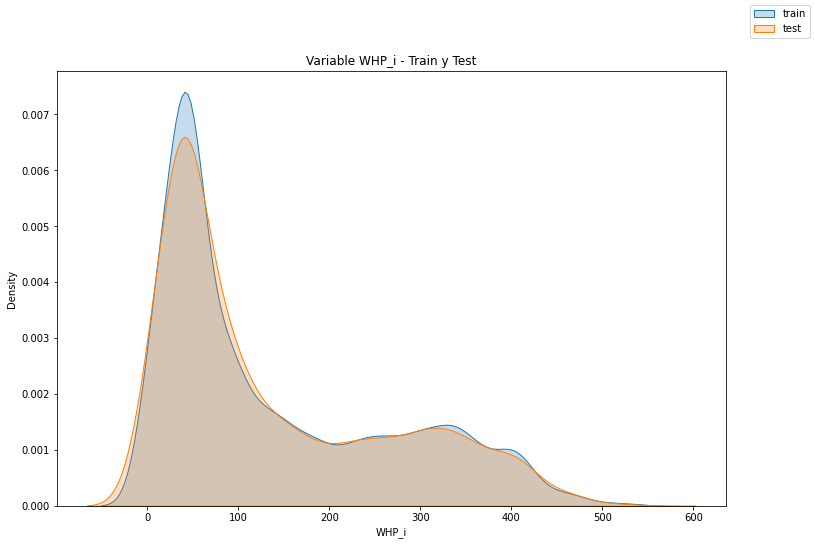

In [ ]:
#Grafico KDE - Train y test

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train, x='WHP_i',fill=True)
sns.kdeplot(data=df_test, x='WHP_i',fill=True)
fig.legend(labels=['train','test'])
plt.title('Variable WHP_i - Train y Test')
plt.show()

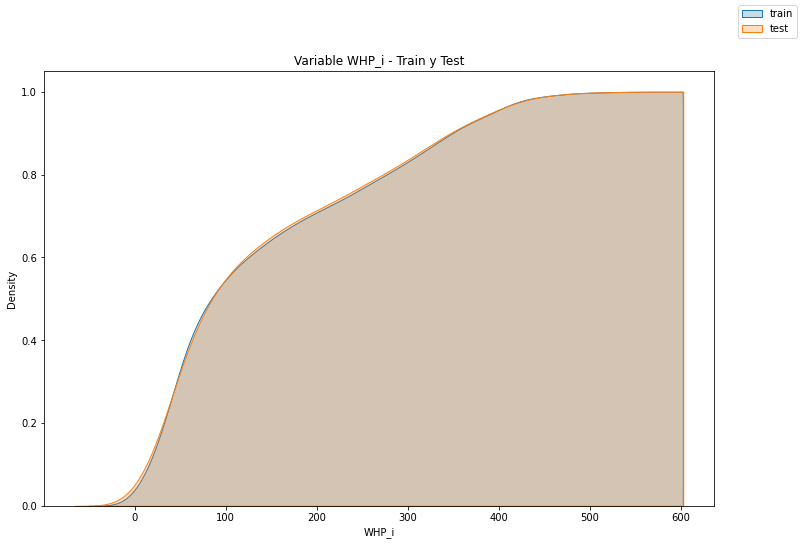

In [ ]:
#Grafico KDE acumulativo - Train y test

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train, x='WHP_i',fill=True,cumulative=True)
sns.kdeplot(data=df_test, x='WHP_i',fill=True,cumulative=True)
fig.legend(labels=['train','test'])
plt.title('Variable WHP_i - Train y Test')
plt.show()

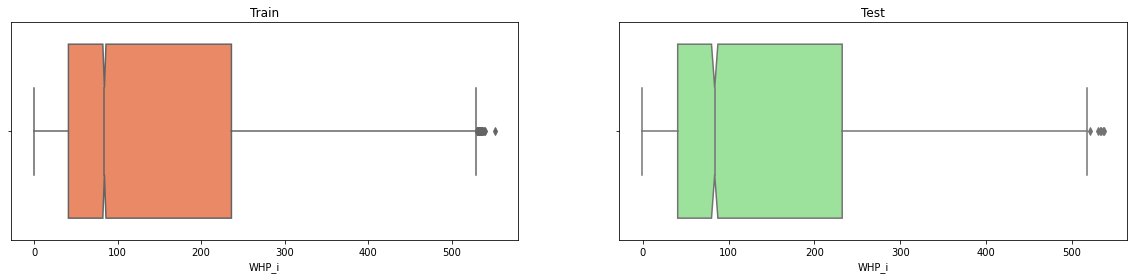

In [ ]:
#Grafico Boxplot - Train y test

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.boxplot(data=df_train_az, x="WHP_i",color='coral',notch=True,ax=axs[0])
sns.boxplot(data=df_test, x="WHP_i",color='lightgreen',notch=True,ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

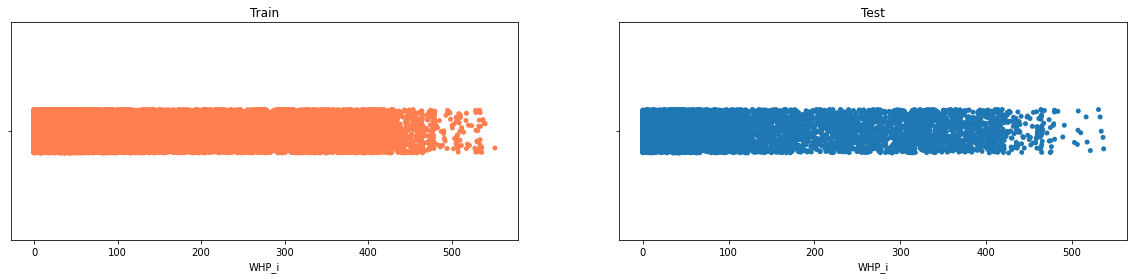

In [ ]:
#Grafico STRIPPLOT - Train y test

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.stripplot(data=df_train_az, x="WHP_i",ax=axs[0],color='coral')
sns.stripplot(data=df_test, x="WHP_i",ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Test')
plt.show()

### **1.1.15** Feature **ESTADO**: Estado del pozo al momento de la interferencia. Cerrado/Abierto.

In [ ]:
#Train - Tipo de dato de la variable

df_train['ESTADO'].dtype

dtype('O')

In [ ]:
#Test - Tipo de dato de la variable

df_test['ESTADO'].dtype

dtype('O')

En ambos casos el tipo de datos corresponde a **object**

In [ ]:
#Train - Cantidad de registros por valor

df_train['ESTADO'].value_counts()

Abierto    17280
Cerrado     8898
Name: ESTADO, dtype: int64

In [ ]:
#Test - Cantidad de registros por valor

df_test['ESTADO'].value_counts()

Abierto    4335
Cerrado    2202
Name: ESTADO, dtype: int64

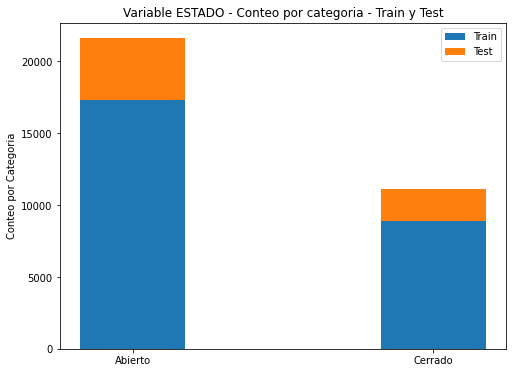

In [ ]:
#Grafico de conteo por categoria en Train y Test

labels = ['Abierto','Cerrado']
estado_train = df_train['ESTADO'].value_counts().values
estado_test = df_test['ESTADO'].value_counts().values
width = 0.35

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(8)

ax.bar(labels, estado_train, width,label='Train')
ax.bar(labels, estado_test, width, bottom=estado_train,label='Test')

ax.set_ylabel('Conteo por Categoria')
ax.set_title('Variable ESTADO - Conteo por categoria - Train y Test')
ax.legend()

plt.show()

In [ ]:
#Proporciones entre Train y Test por conteo de categoria

estado_proporciones = df_train['ESTADO'].value_counts() / df_test['ESTADO'].value_counts()
estado_proporciones.sort_values(ascending=False)

Cerrado    4.040872
Abierto    3.986159
Name: ESTADO, dtype: float64

## **1.1.16** Target **delta_WHP**: Salto de presión generado por la interferencia. Desde la presión inicial al punto máximo o mínimo del salto.

In [ ]:
#Train - Tipo de dato de la variable

df_train['delta_WHP'].dtype

dtype('float64')

In [ ]:
#Train - Valores de estadistica descriptiva

df_train['delta_WHP'].describe()

count    26178.000000
mean         1.375667
std          7.573975
min        -90.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        212.800000
Name: delta_WHP, dtype: float64

Con respecto a delta_WHP se identifican las siguientes opciones:


1.   delta_WHP < 0: Corresponde a eventos NO frac-hit. Esta condicion no es critica para la integridad del pozo padre tan como fue indicado en las meetings 
2.   delta_WHP = 0: Corresponde a eventos NO frac-hit
3.   delta_WHP > 0: Corresponde a eventos de frac-hit con criticidad de integridad para el pozo padre





In [ ]:
#Registros donde delta_WHP < 0

df_train_deltap_neg = df_train[df_train['delta_WHP']<0]
df_train_deltap_neg['delta_WHP'].describe() 

count    148.000000
mean      -6.388514
std       11.627194
min      -90.000000
25%       -6.500000
50%       -2.650000
75%       -1.100000
max       -0.200000
Name: delta_WHP, dtype: float64

In [ ]:
#Cantidad de registros donde delta_WHP < 0

df_train_deltap_neg['delta_WHP'].count() 

148

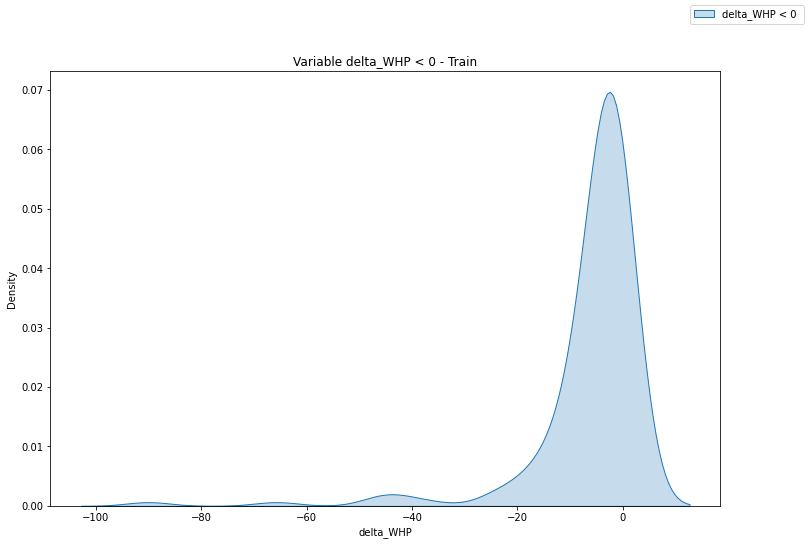

In [ ]:
#Grafico KDE - Registros donde delta_WHP < 0 - Train

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train_deltap_neg, x="delta_WHP",fill=True)
fig.legend(labels=['delta_WHP < 0 '])
plt.title('Variable delta_WHP < 0 - Train')
plt.show()

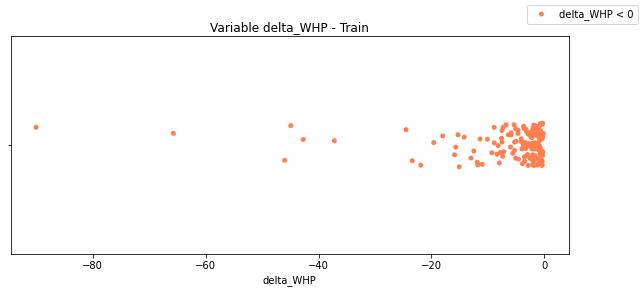

In [ ]:
#Grafico STRIPPLOT - Registros donde delta_WHP < 0 - Train

fig,axs = plt.subplots(figsize=(10,4))
sns.stripplot(data=df_train_deltap_neg, x="delta_WHP",color='coral')
fig.legend(labels=['delta_WHP < 0'])
plt.title('Variable delta_WHP - Train')
plt.show()

In [ ]:
#Registros donde delta_WHP = 0

df_train_deltap_cero = df_train[df_train['delta_WHP']==0]

#Cantidad de registros donde delta_WHP = 0

df_train_deltap_cero['delta_WHP'].count() 

23053

In [ ]:
#Registros donde delta_WHP > 0

df_train_deltap_pos = df_train[df_train['delta_WHP']>0]
df_train_deltap_pos['delta_WHP'].describe()

count    2977.000000
mean       12.414410
std        18.930275
min         0.100000
25%         2.200000
50%         5.600000
75%        14.000000
max       212.800000
Name: delta_WHP, dtype: float64

In [ ]:
#Cantidad de registros donde delta_WHP > 0

df_train_deltap_pos['delta_WHP'].count() 

2977

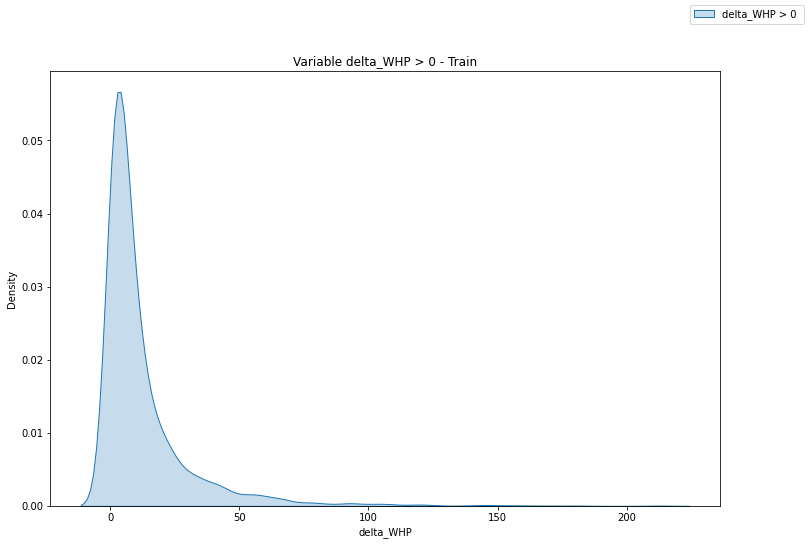

In [ ]:
#Grafico KDE - Registros donde delta_WHP > 0 - Train

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train_deltap_pos, x="delta_WHP",fill=True)
fig.legend(labels=['delta_WHP > 0 '])
plt.title('Variable delta_WHP > 0 - Train')
plt.show()

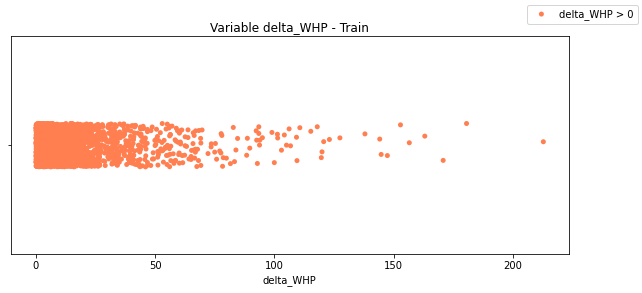

In [ ]:
#Grafico STRIPPLOT - Registros donde delta_WHP > 0 - Train

fig,axs = plt.subplots(figsize=(10,4))
sns.stripplot(data=df_train_deltap_pos, x="delta_WHP",color='coral')
fig.legend(labels=['delta_WHP > 0'])
plt.title('Variable delta_WHP - Train')
plt.show()

In [ ]:
#Porcentaje de registros donde delta_WHP=0 y por lo tanto no existe frac-hit

porcentaje_not_frachit = df_train_deltap_cero['delta_WHP'].count() / df_train.shape[0]
print(f'El {round(porcentaje_not_frachit*100,2)} de los registros no corresponde a eventos con frac-hit')

El 88.06 de los registros no corresponde a eventos con frac-hit


In [ ]:
#Relacion entre eventos no frachit y eventos frachit

r = df_train_deltap_cero['delta_WHP'].count() / df_train_deltap_pos['delta_WHP'].count() 

print(f'La relacion de cantidad de registros con eventos no frachit y eventos frachit es {round(r,2)}')

La relacion de cantidad de registros con eventos no frachit y eventos frachit es 7.74


## **1.2 Analisis Multivariado - Features y Target**

Para los analisis que se obsrvaran  a continuacion se utilizan los registros en los cuales corresponde delta_WHP > 0, los cuales son asociaciados a registros de eventos con ocurrencia de frac-hit.

### **1.2.1** Correlacion de Pearson

In [ ]:
#Selecciono las variables sobre las cuales voy a calcular la correlacion

df_corr = df_train_deltap_pos.loc[:, ~df_train_deltap_pos.columns.isin(['ID_FILA', 'ID_EVENTO'])]
df_corr.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
548,Campo D,OIL,PAD-49,Pozo 510,15,Pozo 189,1198.615385,1196.083088,77.872258,142.174987,1.0,NO,8.2,13.2,Abierto
605,Campo F,OIL,PAD-60,Pozo 407,5,Pozo 236,1594.612185,1594.359501,28.386659,117.367208,5.0,NO,9.2,3.2,Abierto
751,Campo D,OIL,PAD-48,Pozo 171,2,Pozo 169,1237.247363,1235.927751,57.128194,266.807448,1.0,NO,11.7,15.5,Abierto
770,Campo E,OIL,PAD-85,Pozo 552,25,Pozo 347,1227.389254,1227.378613,-5.110969,49.357384,1.0,NO,11.8,23.6,Abierto
815,Campo E,OIL,PAD-84,Pozo 550,28,Pozo 221,1439.145195,1439.137802,4.612872,101.406115,2.0,NO,12.3,1.8,Abierto


Text(0.5, 1.0, 'Correlation Heatmap')

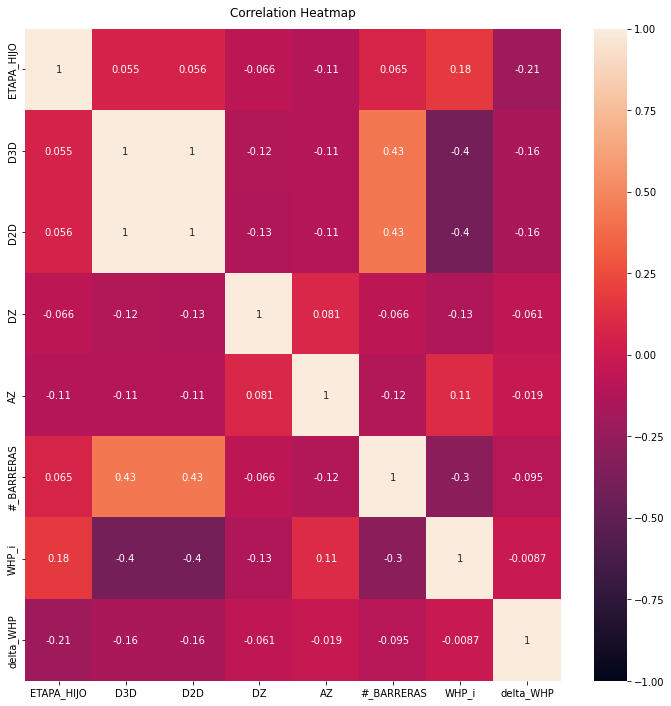

In [ ]:
#Grafico de correlacion

plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(df_corr.corr(method='pearson'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [ ]:
#Target  - Correlacion de Pearson con los Features

df_corr.corr()['delta_WHP'].sort_values(ascending=False)

delta_WHP     1.000000
WHP_i        -0.008682
AZ           -0.019016
DZ           -0.061250
#_BARRERAS   -0.095226
D2D          -0.158320
D3D          -0.160322
ETAPA_HIJO   -0.208527
Name: delta_WHP, dtype: float64



*   Con respecto al target **delta_WHP** no se observan fuertes correlaciones
*   Se destaca el valor de correlacion 1 entre **D2D** y **D3D** lo cual indica que son features fuertemente correlacionados



### **1.2.2** **CAMPO** y **delta_WHP**

In [ ]:
#Registros por CAMPO para eventos delta_WHP > 0 

df_train_deltap_pos['CAMPO'].value_counts()

Campo F    1254
Campo D     693
Campo E     356
Campo B     286
Campo C     210
Campo G     110
Campo A      40
Campo I      28
Name: CAMPO, dtype: int64

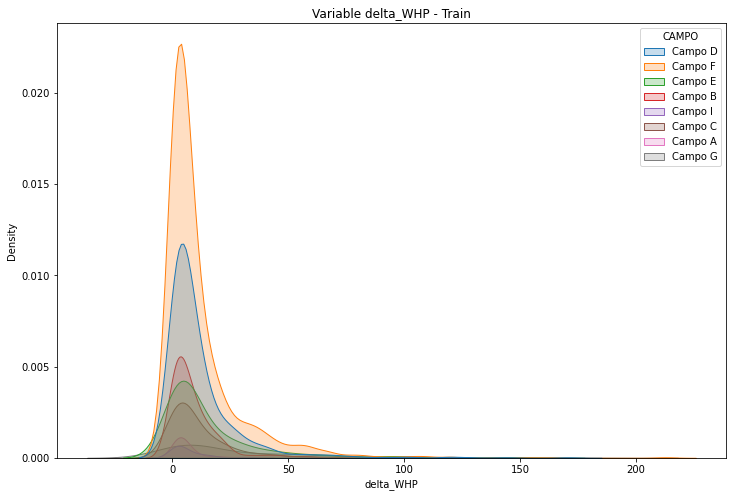

In [ ]:
#Grafico KDE - Eventos delta_WHP > 0

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train_deltap_pos, x="delta_WHP", hue="CAMPO",fill=True)
plt.title('Variable delta_WHP - Train')
plt.show()

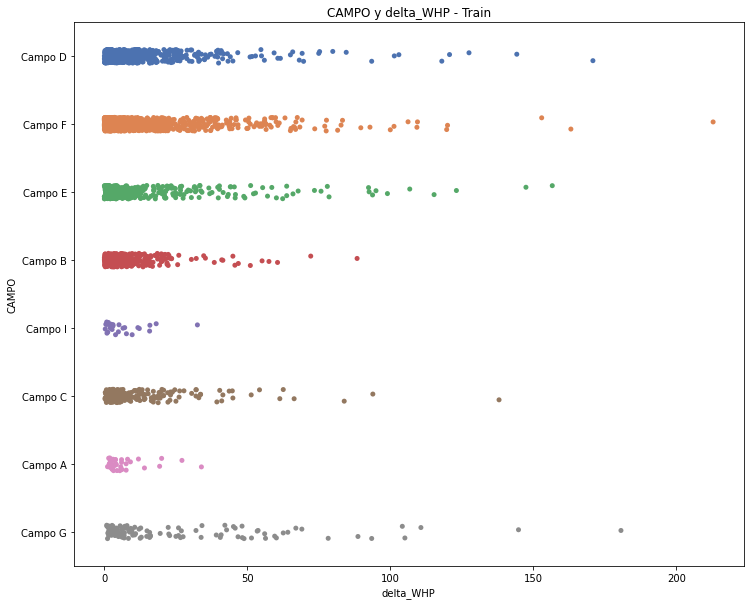

In [ ]:
#Grafico STRIPPLOT - Eventos delta_WHP > 0

fig = plt.figure(figsize=(12,10))
sns.stripplot(data=df_train_deltap_pos, x="delta_WHP", y="CAMPO", palette="deep")
plt.title('CAMPO y delta_WHP - Train')
plt.show()

### 1.2.3 FLUIDO y delta_WHP

In [ ]:
#Registros por FLUIDO - Eventos delta_WHP > 0 

df_train_deltap_pos['FLUIDO'].value_counts()

OIL    2589
GAS     388
Name: FLUIDO, dtype: int64

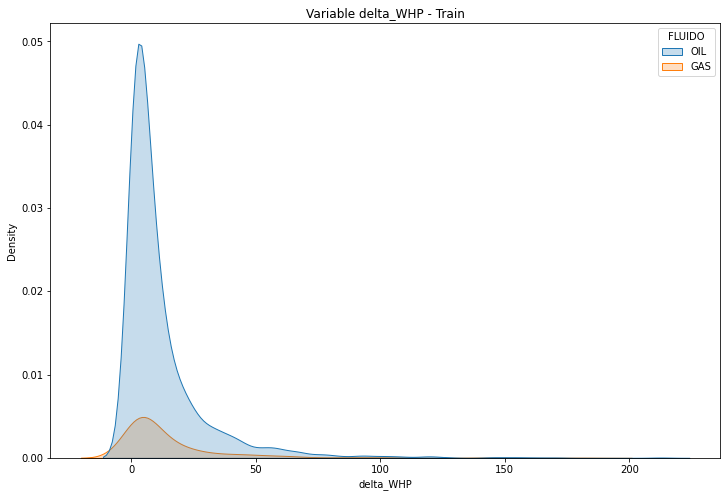

In [ ]:
#Grafico KDE - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train_deltap_pos, x="delta_WHP", hue="FLUIDO",fill=True)
plt.title('Variable delta_WHP - Train')
plt.show()

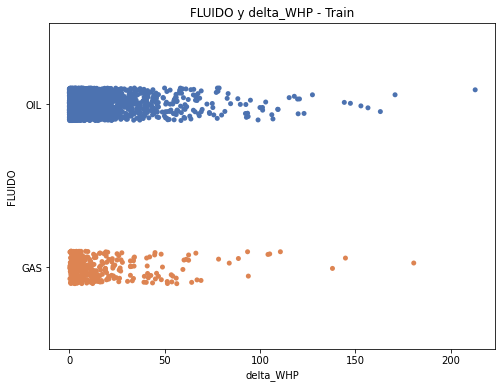

In [ ]:
#Grafico STRIPPLOT - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(8,6))
sns.stripplot(data=df_train_deltap_pos, x="delta_WHP", y="FLUIDO", palette="deep")
plt.title('FLUIDO y delta_WHP - Train')
plt.show()

### **1.2.4** **PAD_HIJO** y **delta_WHP**

In [ ]:
#Registros por PAD_HIJO para eventos delta_WHP > 0 

df_train_deltap_pos['PAD_HIJO'].value_counts()

PAD-83    239
PAD-80    140
PAD-70    124
PAD-5     122
PAD-85    120
         ... 
PAD-93      3
PAD-89      2
PAD-31      1
PAD-43      1
PAD-20      1
Name: PAD_HIJO, Length: 68, dtype: int64

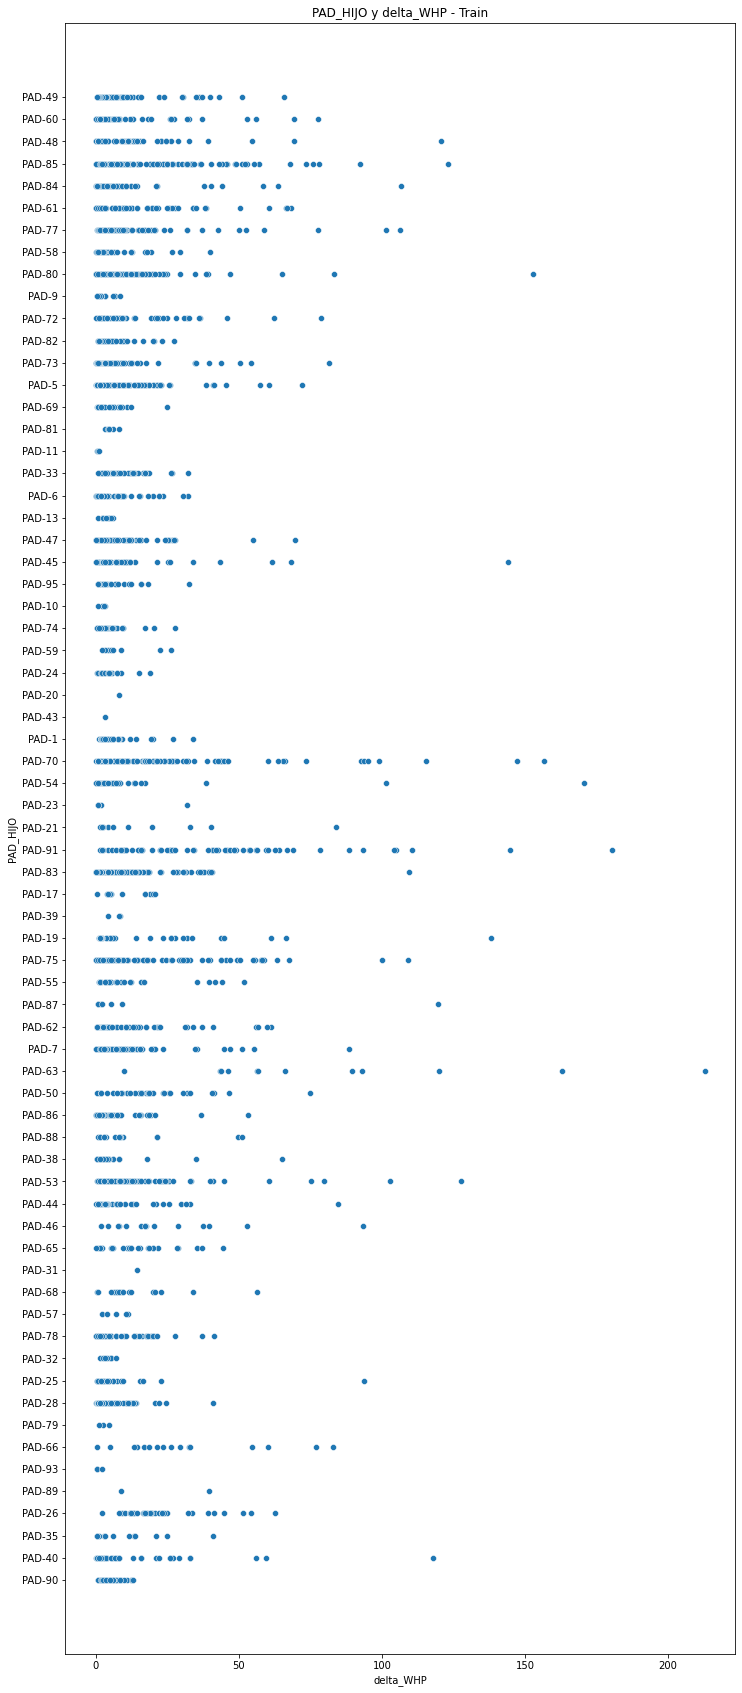

In [ ]:
#Grafico SCATTERPLOT - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(12,30))
sns.scatterplot(data=df_train_deltap_pos, x="delta_WHP", y="PAD_HIJO")
plt.title('PAD_HIJO y delta_WHP - Train')
plt.show()

### **1.2.5** **HIJO** y **delta_WHP**

In [ ]:
#Registros por HIJO para eventos delta_WHP > 0 

df_train_deltap_pos['HIJO'].value_counts()

Pozo 544    96
Pozo 546    75
Pozo 79     56
Pozo 466    54
Pozo 543    51
            ..
Pozo 541     1
Pozo 358     1
Pozo 86      1
Pozo 133     1
Pozo 558     1
Name: HIJO, Length: 216, dtype: int64

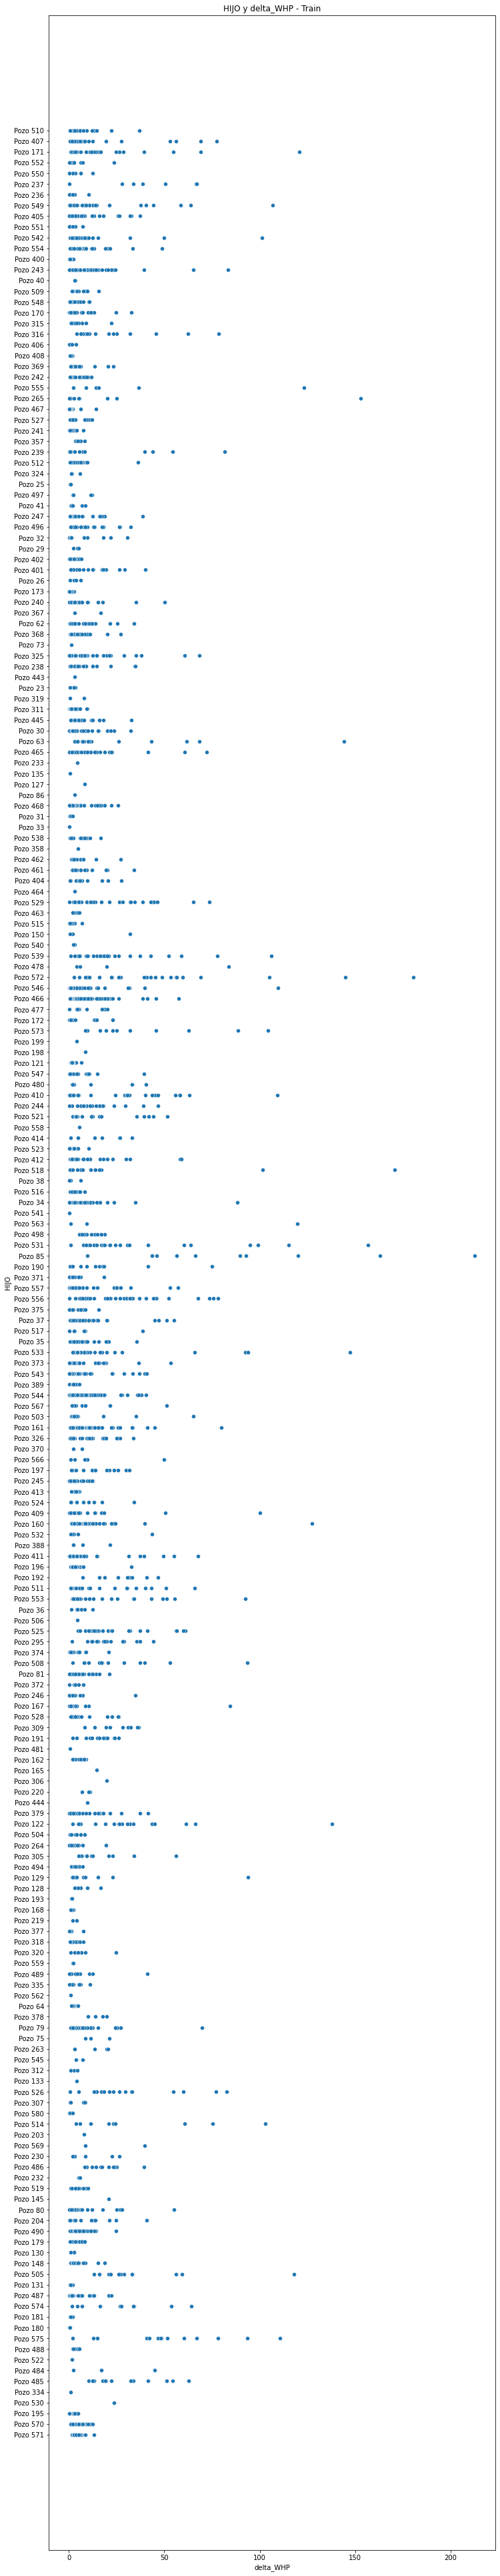

In [ ]:
#Grafico SCATTERPLOT - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(12,70))
sns.scatterplot(data=df_train_deltap_pos, x="delta_WHP", y="HIJO")
plt.title('HIJO y delta_WHP - Train')
plt.show()

### **1.2.6** **ETAPA_HIJO** y **delta_WHP**

In [ ]:
#Registros por ETAPA_HIJO para eventos delta_WHP > 0 

df_train_deltap_pos['ETAPA_HIJO'].value_counts()

15    113
10    109
9     104
8     104
14    103
     ... 
54      1
65      1
58      1
50      1
57      1
Name: ETAPA_HIJO, Length: 65, dtype: int64

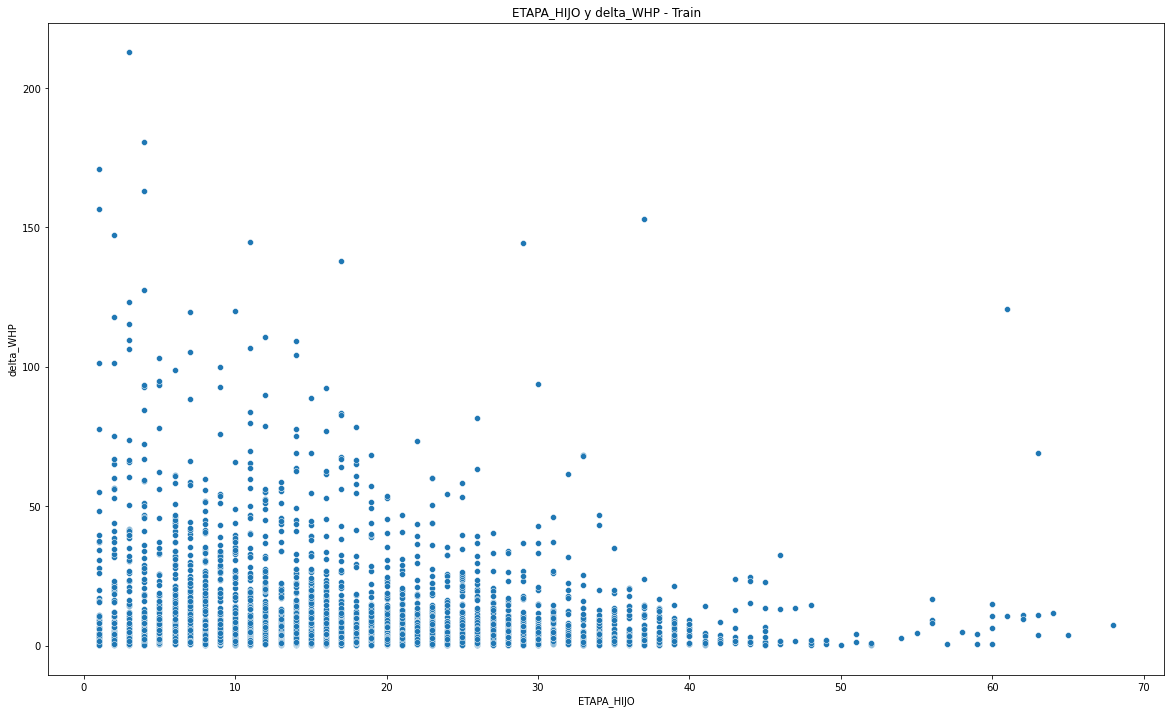

In [ ]:
#Grafico SCATTERPLOT - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(20,12))
sns.scatterplot(data=df_train_deltap_pos, x="ETAPA_HIJO", y="delta_WHP")
plt.title('ETAPA_HIJO y delta_WHP - Train')
plt.show()

### **1.2.6** **PADRE** y **delta_WHP**

In [ ]:
#Registros por PADRE para eventos delta_WHP > 0 

df_train_deltap_pos['PADRE'].value_counts()

Pozo 247    74
Pozo 77     72
Pozo 246    64
Pozo 436    49
Pozo 76     49
            ..
Pozo 156     1
Pozo 93      1
Pozo 116     1
Pozo 11      1
Pozo 230     1
Name: PADRE, Length: 192, dtype: int64

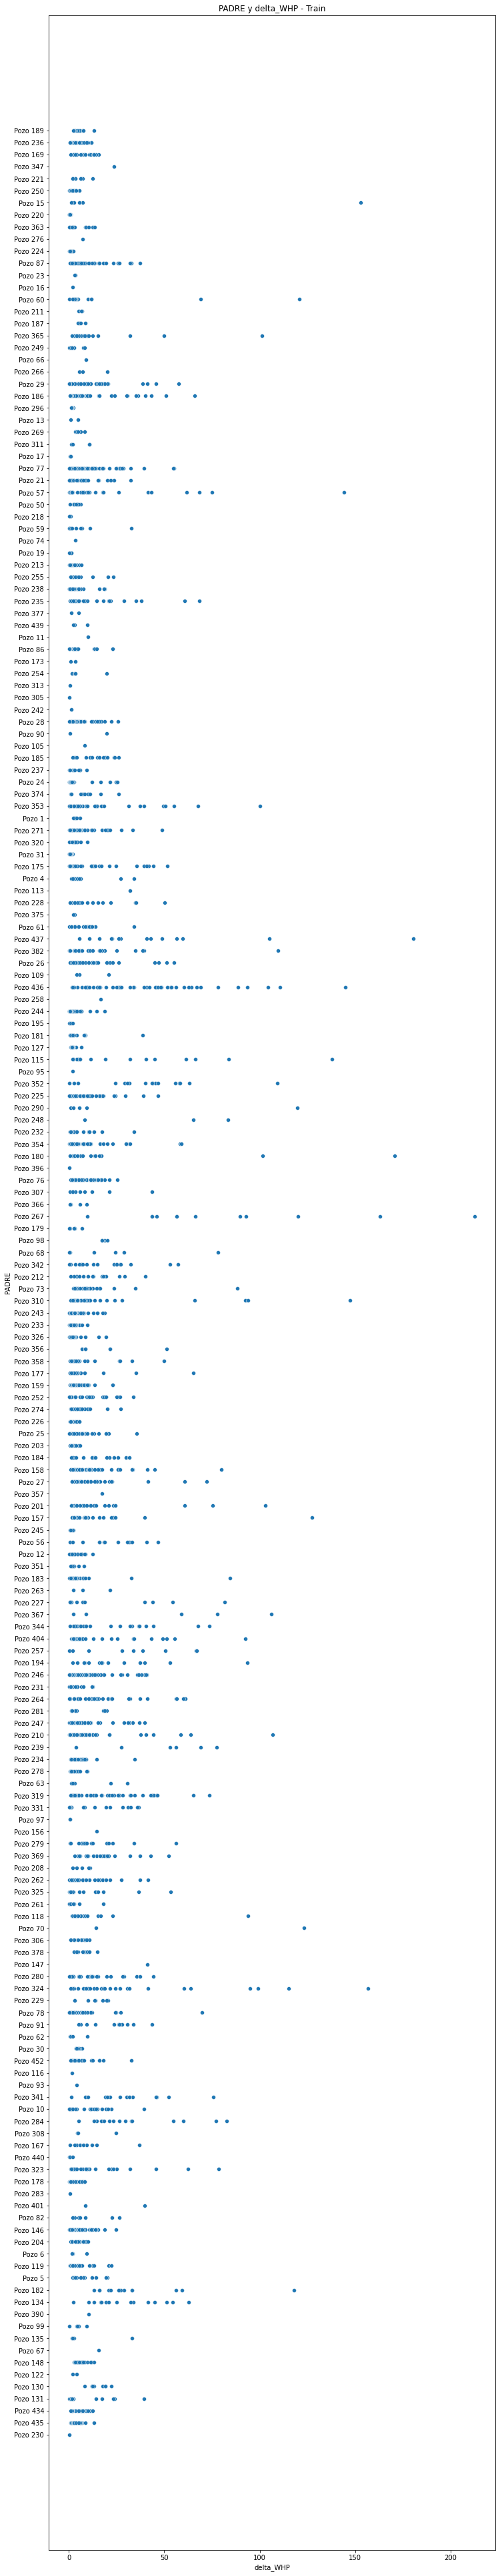

In [ ]:
#Grafico SCATTERPLOT - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(12,70))
sns.scatterplot(data=df_train_deltap_pos, x="delta_WHP", y="PADRE")
plt.title('PADRE y delta_WHP - Train')
plt.show()

### **1.2.7** **D3D** y **delta_WHP**

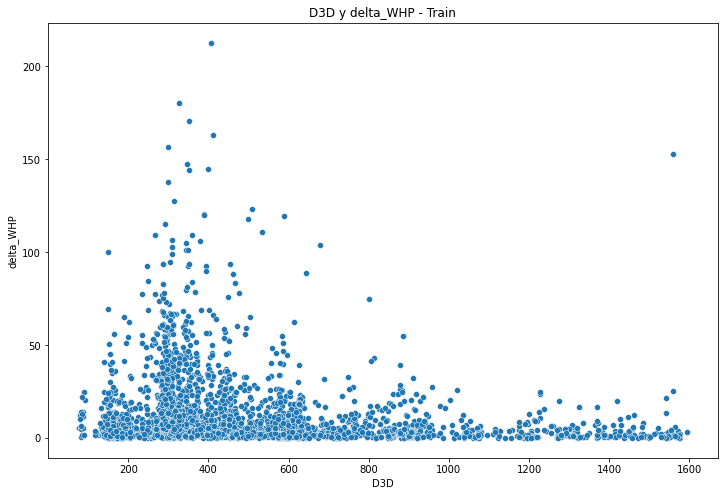

In [ ]:
#Grafico SCATTERPLOT - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data=df_train_deltap_pos, x='D3D', y='delta_WHP')
plt.title('D3D y delta_WHP - Train')
plt.show()

### **1.2.8** **D2D** y **delta_WHP**

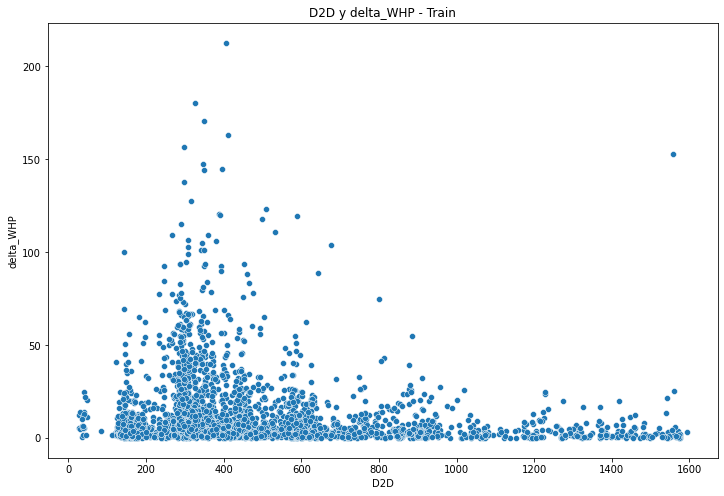

In [ ]:
#Grafico SCATTERPLOT - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data=df_train_deltap_pos, x='D2D', y='delta_WHP')
plt.title('D2D y delta_WHP - Train')
plt.show()

### **1.2.9** **DZ** y **delta_WHP**

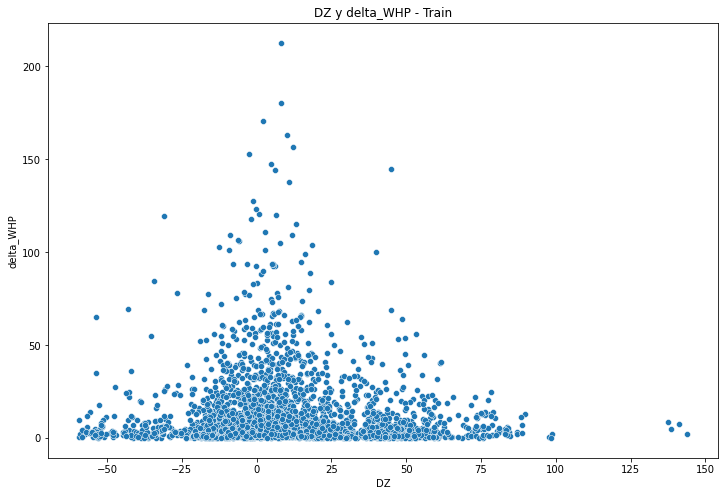

In [ ]:
#Grafico SCATTERPLOT  - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data=df_train_deltap_pos, x='DZ', y='delta_WHP')
plt.title('DZ y delta_WHP - Train')
plt.show()

### **1.2.9** **AZ** y **delta_WHP**

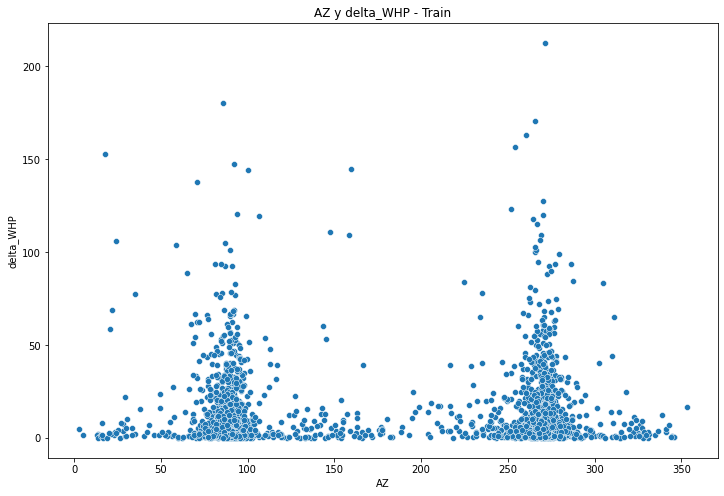

In [ ]:
#Grafico SCATTERPLOT  - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data=df_train_deltap_pos, x='AZ', y='delta_WHP')
plt.title('AZ y delta_WHP - Train')
plt.show()

### **1.2.10 #_BARRERAS** y **delta_WHP**

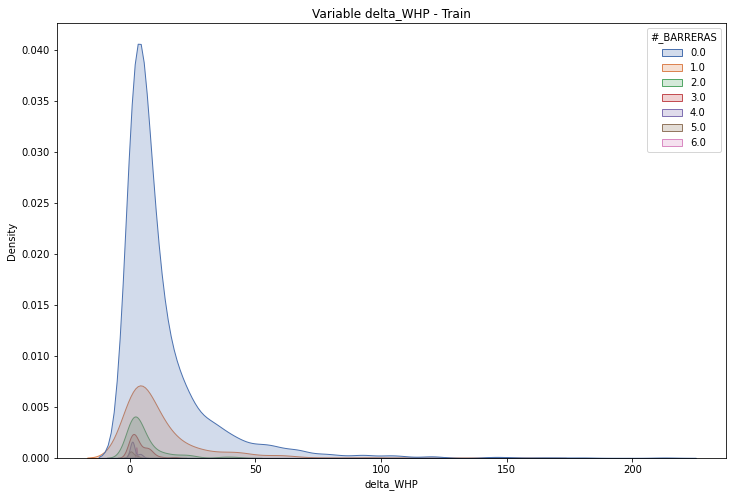

In [ ]:
#Grafico KDE - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train_deltap_pos, x="delta_WHP", hue="#_BARRERAS",fill=True,palette="deep")
plt.title('Variable delta_WHP - Train')
plt.show()

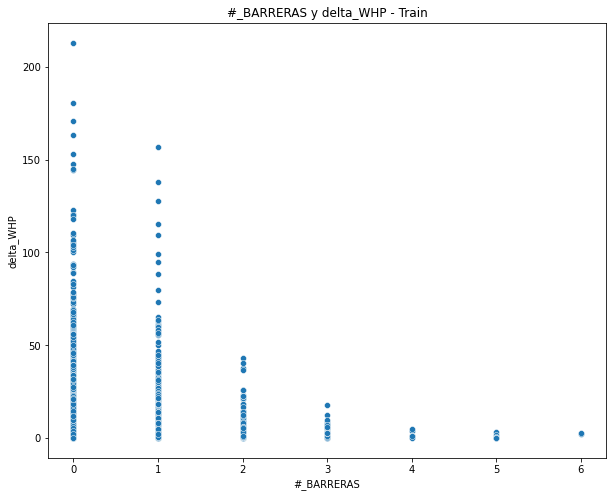

In [ ]:
#Grafico SCATTERPLOT - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=df_train_deltap_pos, x='#_BARRERAS', y='delta_WHP')
plt.title('#_BARRERAS y delta_WHP - Train')
plt.show()

### **1.2.11 LINEAMIENTO** y **delta_WHP**

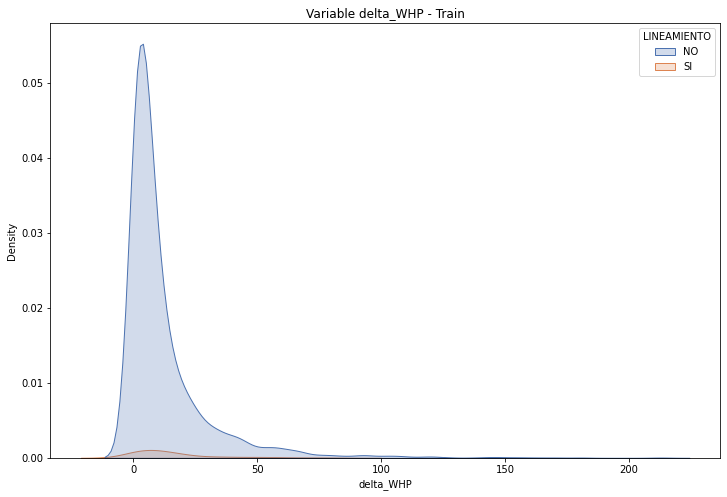

In [ ]:
#Grafico KDE - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train_deltap_pos, x="delta_WHP", hue="LINEAMIENTO",fill=True,palette="deep")
plt.title('Variable delta_WHP - Train')
plt.show()

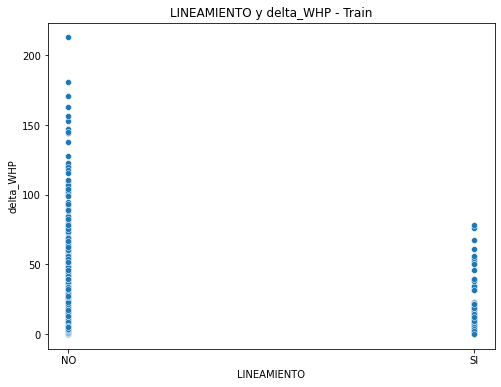

In [ ]:
#Grafico SCATTERPLOT - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_train_deltap_pos, x='LINEAMIENTO', y='delta_WHP')
plt.title('LINEAMIENTO y delta_WHP - Train')
plt.show()

### **1.2.12 ESTADO** y **delta_WHP**

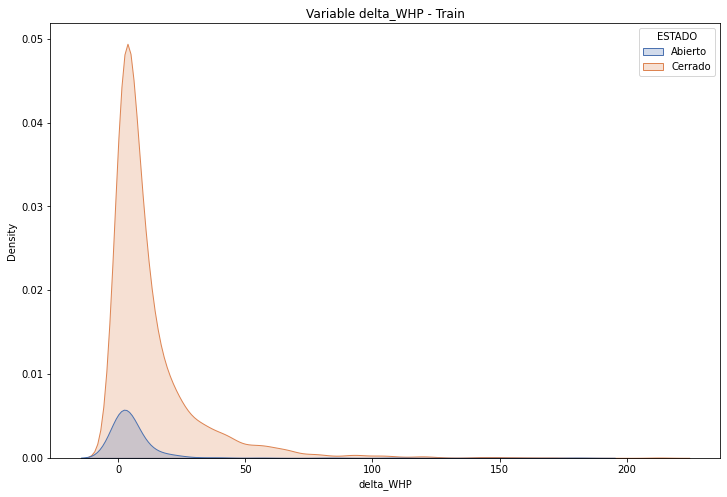

In [ ]:
#Grafico KDE - Eventos delta_WHP > 0

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train_deltap_pos, x="delta_WHP", hue="ESTADO",fill=True,palette="deep")
plt.title('Variable delta_WHP - Train')
plt.show()

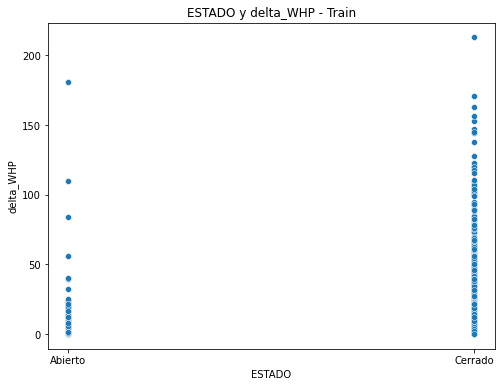

In [ ]:
#Grafico SCATTERPLOT - Eventos delta_WHP > 0 

fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_train_deltap_pos, x='ESTADO', y='delta_WHP')
plt.title('ESTADO y delta_WHP - Train')
plt.show()

### **1.2.13 WHP_i** y **delta_WHP**

Condicion de delta_WHP < 0 

In [ ]:
#Registros en Train donde WHP_i < 0 

WHP_i_menos_cero = df_train[df_train['WHP_i'] < 0]
WHP_i_menos_cero['delta_WHP'].describe()

count    97.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: delta_WHP, dtype: float64



*   Como era de esperar los valores WHP_i < 0 (valor 0 por deriva del instrumento) se corresponden con eventos delta_WHP = 0 (no frac-hit)



In [ ]:
#Registros en Train donde WHP_i = 0 

WHP_i_igual_cero = df_train[df_train['WHP_i'] == 0]
WHP_i_igual_cero['delta_WHP'].describe()

count    182.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: delta_WHP, dtype: float64

*   Como era de esperar los valores WHP_i = 0 se corresponden con eventos delta_WHP = 0 (no frac-hit)


In [ ]:
#Registros en Train donde WHP_i > 0 

WHP_i_mas_cero = df_train[df_train['WHP_i'] > 0]
WHP_i_mas_cero['delta_WHP'].describe()

count    25899.000000
mean         1.390486
std          7.613310
min        -90.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        212.800000
Name: delta_WHP, dtype: float64

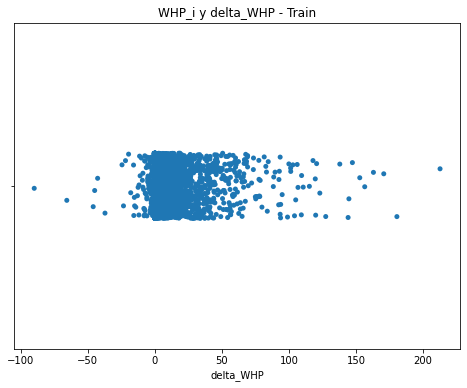

In [ ]:
#Grafico STRIPPLOT - Registros donde WHP_i > 0

fig = plt.figure(figsize=(8,6))
sns.stripplot(data=WHP_i_mas_cero, x="delta_WHP")
plt.title('WHP_i y delta_WHP - Train')
plt.show()

## **1.3 Analisis Multivariado - Features y Features**

### **1.3.1 CAMPO** y **FLUIDO**

In [ ]:
#Train - Fluido que produce cada campo

df_train[['CAMPO','FLUIDO']].drop_duplicates(subset=['CAMPO','FLUIDO']).sort_values(by='CAMPO').style.hide_index()

CAMPO,FLUIDO
Campo A,GAS
Campo B,OIL
Campo C,GAS
Campo D,OIL
Campo E,OIL
Campo F,OIL
Campo G,GAS
Campo H,OIL
Campo I,GAS


In [ ]:
#Test - Fluido que produce cada campo

df_test[['CAMPO','FLUIDO']].drop_duplicates(subset=['CAMPO','FLUIDO']).sort_values(by='CAMPO').style.hide_index()

CAMPO,FLUIDO
Campo A,GAS
Campo B,OIL
Campo C,GAS
Campo D,OIL
Campo E,OIL
Campo F,OIL
Campo G,GAS
Campo H,OIL
Campo I,GAS


### **1.3.2** Cantidad de **PAD_HIJO** por **CAMPO**

In [ ]:
#Train - Cantidad de PAD_HIJO por CAMPO

df_train[['CAMPO','PAD_HIJO']].drop_duplicates(subset=['CAMPO','PAD_HIJO']).groupby(by=['CAMPO']).count().sort_values(by='PAD_HIJO',ascending=False)

,PAD_HIJO
CAMPO,
Campo F,28
Campo D,21
Campo E,10
Campo B,9
Campo C,9
Campo I,3
Campo A,2
Campo G,2
Campo H,1


In [ ]:
#Test - Cantidad de PAD_HIJO por CAMPO

df_test[['CAMPO','PAD_HIJO']].drop_duplicates(subset=['CAMPO','PAD_HIJO']).groupby(by=['CAMPO']).count().sort_values(by='PAD_HIJO',ascending=False)['PAD_HIJO']

CAMPO
Campo F    27
Campo D    21
Campo C     9
Campo E     9
Campo B     8
Campo I     3
Campo A     2
Campo G     2
Campo H     1
Name: PAD_HIJO, dtype: int64

### **1.3.3** Pozos **HIJO** que luego son **PADRE**

### **Train**

In [ ]:
#Pozos que son PADRE
padre_unico_train = pd.Series(df_train['PADRE'].unique())

#Pozos que son PADRE que se encuentran en HIJO
df_train[df_train['HIJO'].isin(padre_unico_train)]['HIJO'].drop_duplicates()

1        Pozo 132
2        Pozo 133
4        Pozo 405
5        Pozo 325
6        Pozo 121
           ...   
21467    Pozo 156
22135    Pozo 204
22147    Pozo 180
22192    Pozo 179
22300    Pozo 181
Name: HIJO, Length: 150, dtype: object



*   Se observa 150 pozos HIJO que luego son pozos PADRE

In [ ]:
#Ejemplo - Pozo 132 que es HIJO

df_train[df_train['HIJO']=='Pozo 132']

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
1,2,Pozo 132-Pozo 112-10,Campo C,GAS,PAD-19,Pozo 132,10,Pozo 112,1184.248919,1184.233308,6.080755,345.025732,0.0,NO,-0.1,0.0,Abierto
16,17,Pozo 132-Pozo 112-5,Campo C,GAS,PAD-19,Pozo 132,5,Pozo 112,1574.224241,1574.224190,0.400792,346.996136,1.0,NO,0.0,0.0,Abierto
17,18,Pozo 132-Pozo 112-6,Campo C,GAS,PAD-19,Pozo 132,6,Pozo 112,1497.994834,1497.991459,3.180152,346.612531,0.0,NO,0.0,0.0,Abierto
18,19,Pozo 132-Pozo 112-8,Campo C,GAS,PAD-19,Pozo 132,8,Pozo 112,1341.138351,1341.133296,3.682205,345.856418,0.0,NO,0.0,0.0,Abierto
19,20,Pozo 132-Pozo 112-9,Campo C,GAS,PAD-19,Pozo 132,9,Pozo 112,1262.623745,1262.615958,4.434340,345.476034,0.0,NO,0.0,0.0,Abierto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20752,20753,Pozo 132-Pozo 91-6,Campo C,GAS,PAD-19,Pozo 132,6,Pozo 91,505.159286,505.159094,0.440318,78.053512,1.0,NO,141.1,0.0,Cerrado
21145,21146,Pozo 132-Pozo 93-2,Campo C,GAS,PAD-19,Pozo 132,2,Pozo 93,484.708737,483.818188,29.368697,179.266513,0.0,NO,161.7,0.0,Cerrado
21251,21252,Pozo 132-Pozo 93-3,Campo C,GAS,PAD-19,Pozo 132,3,Pozo 93,562.598971,561.712000,31.578968,177.851884,0.0,NO,168.3,0.0,Cerrado
24341,24342,Pozo 132-Pozo 126-1,Campo C,GAS,PAD-19,Pozo 132,1,Pozo 126,485.060300,485.036588,4.796159,267.151460,1.0,NO,348.8,0.0,Cerrado


In [ ]:
#Ejemplo - Pozo 132 que es PADRE

df_train[df_train['PADRE']=='Pozo 132']

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
13458,13459,Pozo 483-Pozo 132-16,Campo C,GAS,PAD-26,Pozo 483,16,Pozo 132,1112.945461,1112.891724,10.936614,264.913880,2.0,NO,214.7,0.0,Abierto
13459,13460,Pozo 483-Pozo 132-17,Campo C,GAS,PAD-26,Pozo 483,17,Pozo 132,1105.809320,1105.735099,12.811822,260.798728,2.0,NO,214.7,0.0,Abierto
13460,13461,Pozo 483-Pozo 132-18,Campo C,GAS,PAD-26,Pozo 483,18,Pozo 132,1106.585604,1106.481168,15.202813,256.656261,2.0,NO,214.8,0.0,Abierto
13464,13465,Pozo 483-Pozo 132-15,Campo C,GAS,PAD-26,Pozo 483,15,Pozo 132,1127.277153,1127.241459,8.970695,268.939174,2.0,NO,215.0,0.0,Abierto
13465,13466,Pozo 483-Pozo 132-13,Campo C,GAS,PAD-26,Pozo 483,13,Pozo 132,1171.178930,1171.166732,5.345232,276.606689,2.0,NO,215.1,0.0,Abierto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22670,22671,Pozo 485-Pozo 132-13,Campo C,GAS,PAD-26,Pozo 485,13,Pozo 132,1365.011515,1364.133565,48.949489,273.979556,3.0,NO,260.4,0.0,Cerrado
22683,22684,Pozo 486-Pozo 132-11,Campo C,GAS,PAD-26,Pozo 486,11,Pozo 132,1184.623867,1184.057608,36.623588,281.796746,3.0,NO,261.2,0.0,Cerrado
22689,22690,Pozo 485-Pozo 132-14,Campo C,GAS,PAD-26,Pozo 485,14,Pozo 132,1350.784055,1349.815659,51.139534,270.658634,3.0,NO,261.7,0.0,Cerrado
22739,22740,Pozo 485-Pozo 132-15,Campo C,GAS,PAD-26,Pozo 485,15,Pozo 132,1338.910621,1337.843746,53.439337,267.287949,4.0,NO,264.5,0.0,Cerrado


### **Test**

In [ ]:
#Pozos que son PADRE
padre_unico_test = pd.Series(df_test['PADRE'].unique())

#Pozos que son PADRE que se encuentran en HIJO
df_test[df_test['HIJO'].isin(padre_unico_test)]['HIJO'].drop_duplicates()

0        Pozo 27
1        Pozo 29
8       Pozo 132
9       Pozo 133
11      Pozo 408
          ...   
4824      Pozo 5
4971    Pozo 179
5092    Pozo 181
5610    Pozo 204
6208    Pozo 143
Name: HIJO, Length: 144, dtype: object



*   Se observa 144 pozos HIJO que luego son pozos PADRE

In [ ]:
#Ejemplo - Pozo 27 que es HIJO

df_test[df_test['HIJO']=='Pozo 27']

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
0,26179,Pozo 27-Pozo 54-38,Campo B,OIL,PAD-13,Pozo 27,38,Pozo 54,1583.887656,1583.666853,-26.446264,143.640741,1.0,NO,-0.3,Cerrado
2,26181,Pozo 27-Pozo 54-41,Campo B,OIL,PAD-13,Pozo 27,41,Pozo 54,1445.963183,1445.750399,-24.805432,139.270555,1.0,NO,-0.3,Cerrado
1165,27344,Pozo 27-Pozo 42-39,Campo B,OIL,PAD-13,Pozo 27,39,Pozo 42,1590.467149,1590.385187,-16.146522,113.801458,1.0,NO,35.0,Abierto
1417,27596,Pozo 27-Pozo 19-34,Campo B,OIL,PAD-13,Pozo 27,34,Pozo 19,1598.299177,1598.283345,-7.113748,221.998458,0.0,NO,38.9,Abierto
1438,27617,Pozo 27-Pozo 19-35,Campo B,OIL,PAD-13,Pozo 27,35,Pozo 19,1556.642097,1556.642096,-0.038576,223.546276,0.0,NO,39.2,Abierto
1506,27685,Pozo 27-Pozo 46-40,Campo B,OIL,PAD-13,Pozo 27,40,Pozo 46,1322.523565,1322.191719,29.624968,171.912257,0.0,NO,39.9,Abierto
1633,27812,Pozo 27-Pozo 46-37,Campo B,OIL,PAD-13,Pozo 27,37,Pozo 46,1500.772883,1500.415739,32.739247,172.915308,0.0,NO,41.3,Abierto
1719,27898,Pozo 27-Pozo 50-39,Campo B,OIL,PAD-13,Pozo 27,39,Pozo 50,1029.686190,1028.729450,-44.377553,168.445783,0.0,NO,42.3,Abierto
2006,28185,Pozo 27-Pozo 46-39,Campo B,OIL,PAD-13,Pozo 27,39,Pozo 46,1381.675975,1381.336081,30.645221,172.335754,0.0,NO,45.3,Abierto
2138,28317,Pozo 27-Pozo 51-33,Campo B,OIL,PAD-13,Pozo 27,33,Pozo 51,1553.195818,1553.064993,-20.158784,182.174624,0.0,NO,47.0,Abierto


In [ ]:
#Ejemplo - Pozo 27 que es PADRE

df_test[df_test['PADRE']=='Pozo 27']

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
2221,28400,Pozo 30-Pozo 27-62,Campo B,OIL,PAD-6,Pozo 30,62,Pozo 27,1357.320738,1356.343541,51.495467,269.765677,1.0,NO,48.3,Abierto
2309,28488,Pozo 30-Pozo 27-23,Campo B,OIL,PAD-6,Pozo 30,23,Pozo 27,1391.171138,1390.410378,46.001272,258.616028,1.0,NO,50.1,Abierto
2334,28513,Pozo 30-Pozo 27-48,Campo B,OIL,PAD-6,Pozo 30,48,Pozo 27,1346.051833,1345.426759,41.016741,273.982474,1.0,NO,50.9,Abierto
2345,28524,Pozo 31-Pozo 27-45,Campo B,OIL,PAD-6,Pozo 31,45,Pozo 27,1498.496134,1498.495981,-0.678096,275.201489,0.0,NO,51.2,Abierto
2348,28527,Pozo 31-Pozo 27-55,Campo B,OIL,PAD-6,Pozo 31,55,Pozo 27,1506.190203,1506.182736,-4.742490,268.336755,0.0,NO,51.3,Abierto
2361,28540,Pozo 30-Pozo 27-21,Campo B,OIL,PAD-6,Pozo 30,21,Pozo 27,1435.512296,1434.778975,45.878586,254.092607,1.0,NO,51.6,Abierto
2379,28558,Pozo 31-Pozo 27-32,Campo B,OIL,PAD-6,Pozo 31,32,Pozo 27,1479.284994,1479.270024,6.654851,268.346482,0.0,NO,52.1,Abierto
2389,28568,Pozo 30-Pozo 27-41,Campo B,OIL,PAD-6,Pozo 30,41,Pozo 27,1352.634071,1351.849913,46.051534,269.299607,1.0,NO,52.4,Abierto
2444,28623,Pozo 31-Pozo 27-23,Campo B,OIL,PAD-6,Pozo 31,23,Pozo 27,1519.474203,1519.446445,9.184464,268.470960,1.0,NO,53.9,Abierto
2493,28672,Pozo 31-Pozo 27-33,Campo B,OIL,PAD-6,Pozo 31,33,Pozo 27,1479.572539,1479.561259,5.777507,268.345979,0.0,NO,55.2,Abierto


### **1.3.4** Cantidad de pozo **HIJO** por **PAD_HIJO**

### **Train**

In [ ]:
df_train[['PAD_HIJO','HIJO']].drop_duplicates(subset=['PAD_HIJO','HIJO']).groupby(by=['PAD_HIJO']).count().sort_values(by='HIJO',ascending=False)

,HIJO
PAD_HIJO,
PAD-75,6
PAD-24,6
PAD-70,6
PAD-72,6
PAD-85,6
...,...
PAD-32,1
PAD-89,1
PAD-93,1


### **Test**

In [ ]:
df_test[['PAD_HIJO','HIJO']].drop_duplicates(subset=['PAD_HIJO','HIJO']).groupby(by=['PAD_HIJO']).count().sort_values(by='HIJO',ascending=False)

,HIJO
PAD_HIJO,
PAD-24,6
PAD-85,6
PAD-80,6
PAD-75,6
PAD-72,6
...,...
PAD-88,1
PAD-9,1
PAD-93,1


## **1.3.5** Cantidad de **ETAPA** por pozo **HIJO**

### **Train**

In [ ]:
df_train[['HIJO','ETAPA_HIJO']].drop_duplicates(subset=['HIJO','ETAPA_HIJO']).groupby(by=['HIJO']).count().sort_values(by='ETAPA_HIJO',ascending=False)

,ETAPA_HIJO
HIJO,
Pozo 30,63
Pozo 171,56
Pozo 31,54
Pozo 32,50
Pozo 170,47
...,...
Pozo 530,1
Pozo 444,1
Pozo 474,1


### **Test**

In [ ]:
df_test[['HIJO','ETAPA_HIJO']].drop_duplicates(subset=['HIJO','ETAPA_HIJO']).groupby(by=['HIJO']).count().sort_values(by='ETAPA_HIJO',ascending=False)

,ETAPA_HIJO
HIJO,
Pozo 30,48
Pozo 171,41
Pozo 555,39
Pozo 32,39
Pozo 407,38
...,...
Pozo 541,1
Pozo 143,1
Pozo 142,1


## **1.3.6** Cantidad de **HIJO** por **PADRE**

### **Train**

In [ ]:
df_train[['HIJO','PADRE']].drop_duplicates(subset=['HIJO','PADRE']).groupby(by=['HIJO']).count().sort_values(by='PADRE',ascending=False)

,PADRE
HIJO,
Pozo 478,32
Pozo 407,30
Pozo 405,30
Pozo 406,28
Pozo 404,27
...,...
Pozo 444,1
Pozo 530,1
Pozo 457,1


### **Test**

In [ ]:
df_test[['HIJO','PADRE']].drop_duplicates(subset=['HIJO','PADRE']).groupby(by=['HIJO']).count().sort_values(by='PADRE',ascending=False)

,PADRE
HIJO,
Pozo 407,29
Pozo 478,29
Pozo 408,24
Pozo 405,24
Pozo 555,23
...,...
Pozo 494,1
Pozo 191,1
Pozo 186,1


# **2. Preparacion de datos para Modelado**

## **2.1** Acciones

Sobre el conjunto de datos de entrenamiento (df_train) se realizan las siguientes acciones:

1. No se utilizaran los features **ID_FILA** y **ID_EVENTO** por carecer de informacion relevante para el modelado
2. No se utilizara el feature: **D3D** por su fuerte correlacion con **D2D**
3. Feature **D2D**: Se corregiran los valores en punto decimal para aquellos valores mayores al registro de indice 4315.
4. Feature **AZ**: Se corregiran valor en el punto decimal para aquellos valores mayores a 360
5. Feature **WHP_i**: Los valores de WHP_i < 0 se colocaran en 0 ya que valores negativos carecen de sentido fisico.
6. Se aplocara el siguiente labeling sobre cada registro:
  *   Valores de delta_WHP < 0 corresponde a label -1 
  *   Valores de delta_WHP = 0 corresponde a label 0 
  *   Valores de delta_WHP > 0 corresponde a label 1

### **2.1.1** Eliminacion de Features no relevantes y correlacionado

In [ ]:
#Eliminacion de Features ID_FILA, ID_EVENTO y D3D

columnas = ['ID_FILA', 'ID_EVENTO','D3D']
df_train_final = df_train.loc[:, ~df_train.columns.isin(columnas)]
df_train_final.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
0,Campo D,OIL,PAD-47,Pozo 81,37,Pozo 22,1323.212672,32.961374,199.623188,0.0,NO,-0.2,0.0,Abierto
1,Campo C,GAS,PAD-19,Pozo 132,10,Pozo 112,1184.233308,6.080755,345.025732,0.0,NO,-0.1,0.0,Abierto
2,Campo C,GAS,PAD-19,Pozo 133,21,Pozo 112,847.771101,8.312941,342.171963,0.0,NO,-0.1,0.0,Abierto
3,Campo C,GAS,PAD-21,Pozo 478,6,Pozo 122,625.314697,4.139460,259.131395,1.0,NO,-0.1,0.0,Abierto
4,Campo F,OIL,PAD-60,Pozo 405,19,Pozo 242,1118.074170,17.716903,90.993004,3.0,NO,-0.1,0.0,Abierto


### **2.1.2** Correccion en valores de Feature **D2D**

In [ ]:
#Feature D2D - Registros a corregir

df_to_replace_d2d = df_train_final[df_train_final['D2D'] > df_train_final.iloc[4315]['D2D']]
df_to_replace_d2d

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
769,Campo E,OIL,PAD-85,Pozo 554,17,Pozo 347,1483978.0,10.138302,33.109146,2.0,NO,11.8,0.0,Abierto
4458,Campo F,OIL,PAD-69,Pozo 319,16,Pozo 310,1210984.0,-11.822073,89.324574,0.0,NO,40.1,0.0,Abierto
6354,Campo F,OIL,PAD-81,Pozo 357,12,Pozo 85,1096278.0,2.359945,62.845447,1.0,NO,45.6,0.0,Abierto
6801,Campo E,OIL,PAD-85,Pozo 557,20,Pozo 66,1440382.0,-3.518088,298.522022,3.0,NO,47.1,0.0,Abierto
7786,Campo E,OIL,PAD-72,Pozo 315,19,Pozo 285,1391304.0,33.409723,136.812237,2.0,NO,52.6,0.0,Abierto
9568,Campo C,GAS,PAD-23,Pozo 481,22,Pozo 109,1002835.0,-3.009188,274.262599,1.0,NO,68.5,0.0,Abierto
10522,Campo E,OIL,PAD-84,Pozo 551,13,Pozo 402,1472258.0,-6.476867,94.412389,2.0,NO,88.1,0.0,Abierto
12563,Campo C,GAS,PAD-25,Pozo 149,6,Pozo 147,1036657.0,-28.993193,97.859924,1.0,NO,154.2,0.0,Abierto
13329,Campo F,OIL,PAD-59,Pozo 231,3,Pozo 82,1509322.0,25.144129,164.403446,0.0,NO,203.7,0.0,Abierto
13984,Campo C,GAS,PAD-24,Pozo 136,2,Pozo 114,1485008.0,-2.612696,288.093477,0.0,NO,248.2,0.0,Abierto


In [ ]:
#Feature D2D - Aplico la correccion

for i in df_to_replace_d2d.index:
  df_train_final.loc[i,'D2D']  = df_train_final.loc[i,'D2D'] / 1000

In [ ]:
#Feature D2D - Observo un registro ejemplo corregido

df_train_final.loc[769,'D2D']

1483.978

In [ ]:
#Feature D2D - Estadistica descriptiva luego de la correccion

df_train_final['D2D'].describe()

count    26178.000000
mean       991.567312
std        388.033233
min         20.219536
25%        711.821353
50%       1039.317981
75%       1311.552139
max       1981.186446
Name: D2D, dtype: float64

### **2.1.3** Correccion en valores de Feature **AZ**

In [ ]:
#Feature AZ - Registros a corregir

df_to_replace_az = df_train_final[df_train_final['AZ'] > 360]
df_to_replace_az

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
4387,Campo F,OIL,PAD-60,Pozo 406,1,Pozo 227,1538.892309,-4.712397,177932.0,0.0,NO,39.9,0.0,Abierto
18708,Campo E,OIL,PAD-85,Pozo 553,9,Pozo 281,614.116615,49.575823,133633.0,0.0,NO,45.3,0.0,Cerrado


In [ ]:
#Feature AZ - Aplico la correccion

for j in df_to_replace_az.index:
  df_train_final.loc[j,'AZ']  = df_train_final.loc[j,'AZ'] / 1000

In [ ]:
#Feature AZ - Observo un registro ejemplo corregido

df_train_final.loc[4387,'AZ']

177.932

In [ ]:
#Feature AZ - Estadistica descriptiva luego de la correccion

df_train_final['AZ'].describe()

count    26178.000000
mean       186.990381
std        100.743774
min          0.029378
25%         90.467178
50%        201.234030
75%        271.381243
max        359.998020
Name: AZ, dtype: float64

### **2.1.4** Modificacion de valores del feature **WHP_i** negativos

In [ ]:
#Feature WHP_i - Aplico la correccion

train_index_presion_neg = df_train_final[df_train_final['WHP_i'] <= 0].index
df_train_final.loc[train_index_presion_neg,'WHP_i'] = 0

In [ ]:
#Feature WHP_i - Verifico que el minimo valor sea 0 

df_train_final['WHP_i'].min()

0.0

### **2.1.5** Labeling del feature **delta_WHP**

In [ ]:
#Genero un nuevo Feature denominado label

df_train_final['label'] = df_train_final['delta_WHP']
df_train_final.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO,label
0,Campo D,OIL,PAD-47,Pozo 81,37,Pozo 22,1323.212672,32.961374,199.623188,0.0,NO,0.0,0.0,Abierto,0.0
1,Campo C,GAS,PAD-19,Pozo 132,10,Pozo 112,1184.233308,6.080755,345.025732,0.0,NO,0.0,0.0,Abierto,0.0
2,Campo C,GAS,PAD-19,Pozo 133,21,Pozo 112,847.771101,8.312941,342.171963,0.0,NO,0.0,0.0,Abierto,0.0
3,Campo C,GAS,PAD-21,Pozo 478,6,Pozo 122,625.314697,4.139460,259.131395,1.0,NO,0.0,0.0,Abierto,0.0
4,Campo F,OIL,PAD-60,Pozo 405,19,Pozo 242,1118.074170,17.716903,90.993004,3.0,NO,0.0,0.0,Abierto,0.0


In [ ]:
#Labeling de delta_WHP < 0

label_neg_index = df_train_final[df_train_final['delta_WHP'] < 0].index
df_train_final.loc[label_neg_index,'label'] = -1

In [ ]:
#Labeling de delta_WHP = 0

label_cero_index = df_train_final[df_train_final['delta_WHP'] == 0].index
df_train_final.loc[label_cero_index,'label'] = 0

In [ ]:
#Labeling de delta_WHP > 0

label_pos_index = df_train_final[df_train_final['delta_WHP'] > 0].index
df_train_final.loc[label_pos_index,'label'] = 1

In [ ]:
#Chequeo de labeling

df_train_final['label'].value_counts()

 0.0    23053
 1.0     2977
-1.0      148
Name: label, dtype: int64

In [ ]:
df_train_final.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO,label
0,Campo D,OIL,PAD-47,Pozo 81,37,Pozo 22,1323.212672,32.961374,199.623188,0.0,NO,0.0,0.0,Abierto,0.0
1,Campo C,GAS,PAD-19,Pozo 132,10,Pozo 112,1184.233308,6.080755,345.025732,0.0,NO,0.0,0.0,Abierto,0.0
2,Campo C,GAS,PAD-19,Pozo 133,21,Pozo 112,847.771101,8.312941,342.171963,0.0,NO,0.0,0.0,Abierto,0.0
3,Campo C,GAS,PAD-21,Pozo 478,6,Pozo 122,625.314697,4.139460,259.131395,1.0,NO,0.0,0.0,Abierto,0.0
4,Campo F,OIL,PAD-60,Pozo 405,19,Pozo 242,1118.074170,17.716903,90.993004,3.0,NO,0.0,0.0,Abierto,0.0


### **2.1.6** Typecasting

In [ ]:
# Typecasting en label
df_train_final['label'] = df_train_final['label'].astype(int)

#Typecasting en #_BARRERAS
df_train_final['#_BARRERAS'] = df_train_final['#_BARRERAS'].astype(int)

In [ ]:
#Observo los primeros 5 registros del dataset

df_train_final.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO,label
0,Campo D,OIL,PAD-47,Pozo 81,37,Pozo 22,1323.212672,32.961374,199.623188,0,NO,0.0,0.0,Abierto,0
1,Campo C,GAS,PAD-19,Pozo 132,10,Pozo 112,1184.233308,6.080755,345.025732,0,NO,0.0,0.0,Abierto,0
2,Campo C,GAS,PAD-19,Pozo 133,21,Pozo 112,847.771101,8.312941,342.171963,0,NO,0.0,0.0,Abierto,0
3,Campo C,GAS,PAD-21,Pozo 478,6,Pozo 122,625.314697,4.139460,259.131395,1,NO,0.0,0.0,Abierto,0
4,Campo F,OIL,PAD-60,Pozo 405,19,Pozo 242,1118.074170,17.716903,90.993004,3,NO,0.0,0.0,Abierto,0


In [ ]:
df_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26178 entries, 0 to 26177
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CAMPO        26178 non-null  object 
 1   FLUIDO       26178 non-null  object 
 2   PAD_HIJO     26178 non-null  object 
 3   HIJO         26178 non-null  object 
 4   ETAPA_HIJO   26178 non-null  int64  
 5   PADRE        26178 non-null  object 
 6   D2D          26178 non-null  float64
 7   DZ           26178 non-null  float64
 8   AZ           26178 non-null  float64
 9   #_BARRERAS   26178 non-null  int64  
 10  LINEAMIENTO  26178 non-null  object 
 11  WHP_i        26178 non-null  float64
 12  delta_WHP    26178 non-null  float64
 13  ESTADO       26178 non-null  object 
 14  label        26178 non-null  int64  
dtypes: float64(5), int64(3), object(7)
memory usage: 3.0+ MB


## **2.2** Modelo de Regresion - Features y Target

In [ ]:
#Modelo de Regresion - Features sin realizar separacion de Train / Validacion

X_reg = df_train_final.loc[:, ~df_train_final.columns.isin(['delta_WHP','label'])]
X_reg.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
0,Campo D,OIL,PAD-47,Pozo 81,37,Pozo 22,1323.212672,32.961374,199.623188,0,NO,0.0,Abierto
1,Campo C,GAS,PAD-19,Pozo 132,10,Pozo 112,1184.233308,6.080755,345.025732,0,NO,0.0,Abierto
2,Campo C,GAS,PAD-19,Pozo 133,21,Pozo 112,847.771101,8.312941,342.171963,0,NO,0.0,Abierto
3,Campo C,GAS,PAD-21,Pozo 478,6,Pozo 122,625.314697,4.139460,259.131395,1,NO,0.0,Abierto
4,Campo F,OIL,PAD-60,Pozo 405,19,Pozo 242,1118.074170,17.716903,90.993004,3,NO,0.0,Abierto


In [ ]:
#Modelo de Regresion - Target sin realizar separacion de Train / Validacion

y_reg = df_train_final['delta_WHP']
y_reg.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: delta_WHP, dtype: float64

In [ ]:
#Modelo de Regresion - Realizo la separacion en Train / Validation

X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_reg,y_reg, test_size=0.20, random_state=42)

In [ ]:
#Modelo de Regresion - Features de Train

X_train_reg.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
4291,Campo F,OIL,PAD-68,Pozo 307,7,Pozo 297,904.589387,25.527898,39.487494,0,NO,39.5,Abierto
13042,Campo C,GAS,PAD-25,Pozo 130,14,Pozo 119,413.481430,-2.257414,107.254682,0,NO,181.7,Abierto
25655,Campo F,OIL,PAD-60,Pozo 407,17,Pozo 250,1392.517388,-2.530483,60.729933,3,SI,17.7,Abierto
8048,Campo I,GAS,PAD-95,Pozo 443,28,Pozo 439,1007.852575,-37.714954,89.489678,1,NO,54.2,Abierto
18325,Campo E,OIL,PAD-56,Pozo 212,16,Pozo 205,1184.530954,1.550687,270.882570,0,NO,25.2,Cerrado


In [ ]:
X_train_reg.shape

(20942, 13)

In [ ]:
#Modelo de Regresion - Features de Validation

X_val_reg.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
1968,Campo F,OIL,PAD-82,Pozo 370,31,Pozo 272,1200.392212,31.605965,95.384658,2,NO,25.6,Abierto
17678,Campo B,OIL,PAD-6,Pozo 31,56,Pozo 70,1410.679497,25.929818,137.725877,0,NO,7.8,Cerrado
5923,Campo E,OIL,PAD-72,Pozo 315,11,Pozo 332,753.401143,33.561660,95.244530,1,NO,44.4,Abierto
1087,Campo E,OIL,PAD-84,Pozo 551,4,Pozo 399,1165.006790,1.156037,305.805163,1,NO,14.9,Abierto
7172,Campo F,OIL,PAD-86,Pozo 372,17,Pozo 84,1385.355045,35.456833,274.862058,5,NO,48.7,Abierto


In [ ]:
X_val_reg.shape

(5236, 13)

In [ ]:
#Modelo de Regresion - Target de Train

y_train_reg.head()

4291     0.0
13042    0.0
25655    0.0
8048     3.1
18325    0.0
Name: delta_WHP, dtype: float64

In [ ]:
y_train_reg.shape

(20942,)

In [ ]:
#Modelo de Regresion - Target de Validation

y_train_reg.head()

4291     0.0
13042    0.0
25655    0.0
8048     3.1
18325    0.0
Name: delta_WHP, dtype: float64

In [ ]:
y_train_reg.shape

(20942,)

## **2.3** Modelo de Clasificacion - Features y Target

Se realiza la separacion en forma estratificada por las categorias creadas en el feature **label**

In [ ]:
#Modelo de Clasificacion - Features + Target

X_clf_inicial = df_train_final.loc[:, ~df_train_final.columns.isin(['label'])]
X_clf_inicial.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
0,Campo D,OIL,PAD-47,Pozo 81,37,Pozo 22,1323.212672,32.961374,199.623188,0,NO,0.0,0.0,Abierto
1,Campo C,GAS,PAD-19,Pozo 132,10,Pozo 112,1184.233308,6.080755,345.025732,0,NO,0.0,0.0,Abierto
2,Campo C,GAS,PAD-19,Pozo 133,21,Pozo 112,847.771101,8.312941,342.171963,0,NO,0.0,0.0,Abierto
3,Campo C,GAS,PAD-21,Pozo 478,6,Pozo 122,625.314697,4.139460,259.131395,1,NO,0.0,0.0,Abierto
4,Campo F,OIL,PAD-60,Pozo 405,19,Pozo 242,1118.074170,17.716903,90.993004,3,NO,0.0,0.0,Abierto


In [ ]:
#Modelo de Clasificacion - Target correspondiente a label

y_clf_label = df_train_final['label']
y_clf_label.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [ ]:
#Realizo la separacion en Train / Validation en forma estratificada con respecto a la variable label

X_clf_train_inicial, X_clf_val_inicial, y_clf_train_label, y_clf_val_label = train_test_split(X_clf_inicial,y_clf_label, test_size=0.20, random_state=42,stratify=y_clf_label)

In [ ]:
#Modelo de Clasificacion - Feature de Train y Target delta_WHP

X_clf_train_inicial.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
14081,Campo F,OIL,PAD-80,Pozo 247,32,Pozo 378,830.603034,14.385283,269.738226,0,NO,253.0,0.0,Abierto
14042,Campo C,GAS,PAD-19,Pozo 122,22,Pozo 100,1150.804960,-44.215764,295.959467,3,NO,250.9,0.0,Abierto
10977,Campo C,GAS,PAD-23,Pozo 482,25,Pozo 144,1252.164115,49.381678,308.716926,0,NO,93.7,0.0,Abierto
13099,Campo F,OIL,PAD-80,Pozo 246,29,Pozo 263,1138.027036,20.156941,264.458680,1,NO,184.9,0.0,Abierto
8216,Campo F,OIL,PAD-71,Pozo 366,29,Pozo 255,748.095339,8.808944,324.970309,0,NO,55.4,0.0,Abierto


In [ ]:
#Modelo de Clasificacion - Features de Validacion y Target delta_WHP

X_clf_val_inicial.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
14298,Campo C,GAS,PAD-21,Pozo 478,18,Pozo 125,1392.486342,21.986289,248.221100,6,NO,265.8,0.0,Abierto
352,Campo E,OIL,PAD-85,Pozo 554,24,Pozo 280,1430.600911,-0.786902,168.731266,0,NO,5.8,0.0,Abierto
24065,Campo D,OIL,PAD-45,Pozo 64,25,Pozo 61,865.773497,7.781193,276.525258,0,NO,334.7,0.0,Cerrado
18196,Campo F,OIL,PAD-80,Pozo 243,29,Pozo 15,1125.567154,-10.258253,23.265788,2,NO,19.6,0.0,Cerrado
17419,Campo D,OIL,PAD-45,Pozo 64,13,Pozo 56,1249.112052,-6.664993,143.888690,0,NO,3.6,0.0,Cerrado


In [ ]:
#Modelo de Clasificacion - Target label de Train - Conteo por clase

y_clf_train_label.value_counts()

 0    18442
 1     2382
-1      118
Name: label, dtype: int64

In [ ]:
#Modelo de Clasificacion - Target label de Validation - Conteo por clase

y_clf_val_label.value_counts()

 0    4611
 1     595
-1      30
Name: label, dtype: int64

A continuacion se obtienen los Dataset finales

In [ ]:
#Modelo de Clasificacion - Features sin realizar separacion de Train / Validacion

X_clf = X_clf_inicial.loc[:, ~X_clf_inicial.columns.isin(['delta_WHP'])]
X_clf.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
0,Campo D,OIL,PAD-47,Pozo 81,37,Pozo 22,1323.212672,32.961374,199.623188,0,NO,0.0,Abierto
1,Campo C,GAS,PAD-19,Pozo 132,10,Pozo 112,1184.233308,6.080755,345.025732,0,NO,0.0,Abierto
2,Campo C,GAS,PAD-19,Pozo 133,21,Pozo 112,847.771101,8.312941,342.171963,0,NO,0.0,Abierto
3,Campo C,GAS,PAD-21,Pozo 478,6,Pozo 122,625.314697,4.139460,259.131395,1,NO,0.0,Abierto
4,Campo F,OIL,PAD-60,Pozo 405,19,Pozo 242,1118.074170,17.716903,90.993004,3,NO,0.0,Abierto


In [ ]:
X_clf.shape

(26178, 13)

In [ ]:
#Modelo de Clasificacion - Target sin realizar separacion de Train / Validacion

y_clf = y_clf_label
y_clf.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [ ]:
y_clf.shape

(26178,)

In [ ]:
#Modelo de Clasificacion - Features de Train finales

X_clf_train = X_clf_train_inicial.loc[:, ~X_clf_train_inicial.columns.isin(['delta_WHP'])]
X_clf_train.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
14081,Campo F,OIL,PAD-80,Pozo 247,32,Pozo 378,830.603034,14.385283,269.738226,0,NO,253.0,Abierto
14042,Campo C,GAS,PAD-19,Pozo 122,22,Pozo 100,1150.804960,-44.215764,295.959467,3,NO,250.9,Abierto
10977,Campo C,GAS,PAD-23,Pozo 482,25,Pozo 144,1252.164115,49.381678,308.716926,0,NO,93.7,Abierto
13099,Campo F,OIL,PAD-80,Pozo 246,29,Pozo 263,1138.027036,20.156941,264.458680,1,NO,184.9,Abierto
8216,Campo F,OIL,PAD-71,Pozo 366,29,Pozo 255,748.095339,8.808944,324.970309,0,NO,55.4,Abierto


In [ ]:
X_clf_train.shape

(20942, 13)

In [ ]:
#Modelo de Clasificacion - Features de Validation finales

X_clf_val = X_clf_val_inicial.loc[:, ~X_clf_val_inicial.columns.isin(['delta_WHP'])]
X_clf_val.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
14298,Campo C,GAS,PAD-21,Pozo 478,18,Pozo 125,1392.486342,21.986289,248.221100,6,NO,265.8,Abierto
352,Campo E,OIL,PAD-85,Pozo 554,24,Pozo 280,1430.600911,-0.786902,168.731266,0,NO,5.8,Abierto
24065,Campo D,OIL,PAD-45,Pozo 64,25,Pozo 61,865.773497,7.781193,276.525258,0,NO,334.7,Cerrado
18196,Campo F,OIL,PAD-80,Pozo 243,29,Pozo 15,1125.567154,-10.258253,23.265788,2,NO,19.6,Cerrado
17419,Campo D,OIL,PAD-45,Pozo 64,13,Pozo 56,1249.112052,-6.664993,143.888690,0,NO,3.6,Cerrado


In [ ]:
X_clf_val.shape

(5236, 13)

In [ ]:
#Modelo de Clasificacion - Target de Train final

y_clf_train = df_train_final.loc[y_clf_train_label.index]['label']
y_clf_train.head()

14081    0
14042    0
10977    0
13099    0
8216     0
Name: label, dtype: int64

In [ ]:
y_clf_train.shape

(20942,)

In [ ]:
#Modelo de Clasificacion - Target de Validation final

y_clf_val = df_train_final.loc[y_clf_val_label.index]['label']
y_clf_val.head()

14298    0
352      0
24065    0
18196    0
17419    0
Name: label, dtype: int64

In [ ]:
y_clf_val.shape

(5236,)

## **2.4** Datos de Test

In [ ]:
#Features de Test

X_test = df_test.loc[:, ~df_test.columns.isin(['ID_FILA','ID_EVENTO','D3D'])]
X_test['#_BARRERAS'] = X_test['#_BARRERAS'].astype(int)
X_test.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
0,Campo B,OIL,PAD-13,Pozo 27,38,Pozo 54,1583.666853,-26.446264,143.640741,1,NO,-0.3,Cerrado
1,Campo B,OIL,PAD-13,Pozo 29,39,Pozo 54,1476.930670,18.028312,147.363305,1,NO,-0.3,Cerrado
2,Campo B,OIL,PAD-13,Pozo 27,41,Pozo 54,1445.750399,-24.805432,139.270555,1,NO,-0.3,Cerrado
3,Campo E,OIL,PAD-85,Pozo 555,4,Pozo 69,672.248439,7.365507,232.229747,0,NO,-0.3,Cerrado
4,Campo E,OIL,PAD-85,Pozo 555,5,Pozo 69,642.776548,7.250530,236.785609,0,NO,-0.3,Cerrado


## **2.5** Variables Categoricas

In [ ]:
#Listado de variables Categoricas

categorical_features = list(X_reg.select_dtypes(include=['object']).columns)
categorical_features

['CAMPO', 'FLUIDO', 'PAD_HIJO', 'HIJO', 'PADRE', 'LINEAMIENTO', 'ESTADO']

# **3. Modelado**

El enfoque de modelado para la solucion del problema planteado consiste en 2 etapa:



1.   Modelo de Regresion: Utilizando un modelo de Regresion se obtiene para cada registros el valor de Target **delta_WHP**. El valor del target se calcula para todos los regitros sabiendo de antemano que existen eventos **frac-hit (delta_WHP > 0)** y eventos no **frac-hit (delta_WHP <= 0)**.
2.   Modelo de Clasificacion: Utilizando un modelo de Clasificacion se obtiene para cada registro la clase dentro del conjunto segun se definio en **2.1.5 Labeling del feature delta_WHP**. La idea de utilizar un modelo de Clasificacion esta relacionado con que la proporcion mayoritaria de los registros corresponde a eventos **no frac-hit (delta_WHP <= 0)** y con este modelo se pretende descartar aquellos registros donde no sucede este fenomeno critico para valores de **delta_WHP = 0**

Para el desarrollo de los modelos utilizo la libreria Catboost https://catboost.ai/en/docs/ la cual implementa **gradient boosting on decision trees** y cuenta con ciertas ventajas iniciales como el manejo de variables categoricas sin la necesidad de su transformacion (encoding) previa al antrenamiento de los modelos.





A continuacion se realiza la instalacion de la libreria **Catboost**

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.9 MB/s 


## **3.1 Modelo de Regresion**

In [ ]:
#Modelo de Regresion - Importo la clase de Catboost

from catboost import CatBoostRegressor

Luego de la busqueda de **Hiperparametros** (GridsearchCv + Pruebas Puntuales) utilizando los conjuntos de datos **X_train_reg, X_val_reg, y_train_reg, y_val_reg** el siguiente listado de hiperparametros son los utilizados para el entrenamiento del **Modelo de Regresion** con la totalidad de los datos de Train **X_reg** e **y_reg**

In [ ]:
#Modelo de Regresion - Hiperparametros - Entrenamiento

catboost_params_reg = {'iterations' : 5000,
                       'learning_rate' : 0.008,
                       'depth': 16,
                       'bootstrap_type' : 'Bernoulli',
                       'random_strength': 1,
                       'min_data_in_leaf': 1,
                       'l2_leaf_reg': 3,
                       'loss_function' : 'RMSE', 
                       'eval_metric' : 'RMSE',
                       'grow_policy' : 'Depthwise',
                       'max_bin' : 1024, 
                       'model_size_reg' : 0,
                       'task_type' : 'GPU',
                       'od_type' : 'IncToDec',
                       'od_wait' : 100,
                       'metric_period' : 50,
                       'verbose' : 50,
                       'subsample' : 0.86,
                       'od_pval' : 1e-10,
                       'max_ctr_complexity' : 5,
                       'has_time': False,
                       'simple_ctr' : 'FeatureFreq',
                       'combinations_ctr': 'FeatureFreq',
                       'random_seed' : 0}

In [ ]:
#Instanciamos el modelo con los hiperparametros definidos previamente
modelo_reg = CatBoostRegressor(**catboost_params_reg)

#Realizamos en entrenamiento final del Modelo de Regresion
modelo_reg.fit(X_reg, y_reg,cat_features=categorical_features)

0:	learn: 7.5529253	total: 158ms	remaining: 13m 8s
50:	learn: 6.6237882	total: 6.32s	remaining: 10m 13s
100:	learn: 5.8445414	total: 17.1s	remaining: 13m 47s
150:	learn: 5.1736695	total: 35.3s	remaining: 18m 53s
200:	learn: 4.5898961	total: 49.7s	remaining: 19m 46s
250:	learn: 4.0847649	total: 58.9s	remaining: 18m 34s
300:	learn: 3.6406847	total: 1m 7s	remaining: 17m 26s
350:	learn: 3.2519171	total: 1m 15s	remaining: 16m 39s
400:	learn: 2.9148595	total: 1m 21s	remaining: 15m 32s
450:	learn: 2.6168900	total: 1m 27s	remaining: 14m 39s
500:	learn: 2.3535138	total: 1m 34s	remaining: 14m 11s
550:	learn: 2.1228140	total: 1m 41s	remaining: 13m 38s
600:	learn: 1.9198960	total: 1m 49s	remaining: 13m 20s
650:	learn: 1.7402844	total: 1m 55s	remaining: 12m 50s
700:	learn: 1.5806584	total: 2m 1s	remaining: 12m 26s
750:	learn: 1.4402907	total: 2m 7s	remaining: 11m 59s
800:	learn: 1.3148749	total: 2m 13s	remaining: 11m 38s
850:	learn: 1.2017349	total: 2m 21s	remaining: 11m 31s
900:	learn: 1.1013655	t

In [ ]:
#Modelo de Regresion - Predicciones

predicciones_reg = modelo_reg.predict(X_test)
predicciones_reg = pd.Series(predicciones_reg)
predicciones_reg.rename('delta_WHP',inplace=True)
predicciones_reg_submmit = pd.concat([df_test['ID_FILA'],predicciones_reg],axis=1)

In [ ]:
#Modelo de Regresion - 5 primeras predicciones

predicciones_reg_submmit.head()

,ID_FILA,delta_WHP
0,26179,15.517604
1,26180,0.171347
2,26181,-0.057844
3,26182,0.314225
4,26183,0.775089


In [ ]:
#Modelo de Regresion - Estadistica descriptiva de las predicciones

predicciones_reg.describe()

count    6537.000000
mean        1.374934
std         5.570226
min       -42.078363
25%        -0.008060
50%         0.014293
75%         0.184104
max        85.422582
Name: delta_WHP, dtype: float64

## **3.2 Modelo de Clasificacion**

In [ ]:
#Modelo de Clasificacion - Importo la clase de Catboost

from catboost import CatBoostClassifier

Luego de la busqueda de **Hiperparametros** (GridsearchCv + Pruebas Puntuales) utilizando los conjuntos de datos **X_clf_train, X_clf_train, y_clf_train, y_clf_val** el siguiente listado de hiperparametros son los utilizados para el entrenamiento del **Modelo de Clasificacion** con la totalidad de los datos de Train **X_clf** e **y_clf**

In [ ]:
#Modelo de Clasificacion - Hiperparametros - Entrenamiento

catboost_params_clf = {'iterations' : 310,
                       'learning_rate' : 0.06,
                       'depth': 16,
                       'bootstrap_type' : 'Bernoulli',
                       'random_strength': 2,
                       'min_data_in_leaf': 50,
                       'l2_leaf_reg': 3,
                       'grow_policy' : 'Depthwise',
                       'metric_period' : 50,
                       'verbose' : 50,
                       'subsample' : 0.8,
                       'random_seed' : 0,
                       'early_stopping_rounds':20}

In [ ]:
#Instanciamos el modelo con los hiperparametros definidos previamente

catboost_clf = CatBoostClassifier(**catboost_params_clf,loss_function='MultiClass')

#Realizamos en entrenamiento final del Modelo de Clasificacion
catboost_clf.fit(X_clf,y_clf,cat_features=categorical_features)

0:	learn: 1.0032931	total: 161ms	remaining: 49.8s
50:	learn: 0.1627330	total: 8.93s	remaining: 45.4s
100:	learn: 0.1135710	total: 27.8s	remaining: 57.5s
150:	learn: 0.0974258	total: 34.7s	remaining: 36.5s
200:	learn: 0.0816414	total: 41.4s	remaining: 22.5s
250:	learn: 0.0689599	total: 48.4s	remaining: 11.4s
300:	learn: 0.0591938	total: 54.5s	remaining: 1.63s
309:	learn: 0.0578001	total: 55.7s	remaining: 0us


In [ ]:
#Modelo de Clasificacion - Feature Importance

pd.DataFrame([catboost_clf.feature_names_,catboost_clf.feature_importances_]).T

,0,1
0,CAMPO,4.872276
1,FLUIDO,1.497449
2,PAD_HIJO,19.260333
3,HIJO,11.094234
4,ETAPA_HIJO,3.229274
5,PADRE,14.777959
6,D2D,16.521933
7,DZ,6.572477
8,AZ,7.321332
9,#_BARRERAS,2.054291


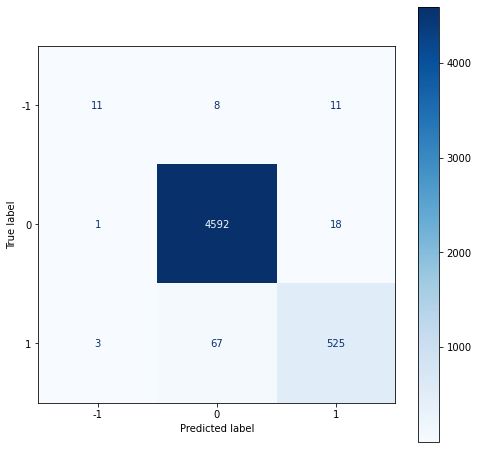

In [ ]:
#Modelo de Clasificacion - Matriz de confusion multiclase

catboost_clf.set_probability_threshold(0.5)
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(catboost_clf, X_clf_val, y_clf_val, cmap=plt.cm.Blues, ax=ax);

In [ ]:
#Modelo de Clasificacion - Probabilidades por Clase

catboost_clf.predict_proba(X_test)

array([[2.29452672e-03, 9.90844177e-01, 6.86129625e-03],
       [9.17255851e-04, 9.94207915e-01, 4.87482938e-03],
       [2.08762625e-03, 9.90663627e-01, 7.24874644e-03],
       ...,
       [4.43540145e-04, 1.16506350e-02, 9.87905825e-01],
       [1.54504159e-03, 5.57194330e-02, 9.42735525e-01],
       [1.06280584e-03, 9.24970717e-01, 7.39664771e-02]])

In [ ]:
#Modelo de Clasificacion - Clases predichas por el modelo

clases_clf = pd.Series(list(catboost_clf.predict(X_test)))
clases_clf.rename('clase',inplace=True)

0       [0]
1       [0]
2       [0]
3       [0]
4       [0]
       ... 
6532    [0]
6533    [1]
6534    [1]
6535    [1]
6536    [0]
Name: clase, Length: 6537, dtype: object

In [ ]:
#Concateno las predicciones de clase del Modelo de Clasificacion con las predicciones de delta_WHP del Modelo de Regresion

df_final = pd.concat([clases_clf,predicciones_reg_submmit],axis=1)

#Los registros que el modelo que Clasificacion indica que son de la clase 0 le corresponde valor delta_WHP=0
label_cero_index = df_final[df_final['clase'] == 0].index
df_final.loc[label_cero_index,'delta_WHP'] = 0

#Readondeamos el valor de delta_WHP a 1 cifra decimal
df_final = df_final.round({'delta_WHP':1})
df_final.head()

,clase,ID_FILA,delta_WHP
0,[0],26179,0.0
1,[0],26180,0.0
2,[0],26181,0.0
3,[0],26182,0.0
4,[0],26183,0.0


In [ ]:
#Se guarda la prediccion para el Scoring de la plataforma Meta-Data

predicciones = pd.concat([df_test['ID_FILA'],df_final['delta_WHP']],axis=1)
predicciones.to_csv('predicciones.csv',header=False,index=False)

# **4. Analisis de la prediccion**

A continuacion se realiza un analisis de las predicciones

Tal como fue indicado al comienzo de la Notebooks la lectura de las predicciones se realiza directamente desde mi repositorio de acceso publico en Github: https://github.com/ccollado7/metadata_ypf. Las predicciones corresponden al ultimo envio realizado a la plataforma Meta-Data antes del cierre de la competencia obteniendo un Score Publico de 0.76773

In [283]:
#Prediccion - Direccion
url_prediccion = 'https://raw.githubusercontent.com/ccollado7/metadata_ypf/main/predicciones.csv'

#Prediccion - Valores
df_pred = pd.read_csv(url_prediccion)
df_pred = df_pred.set_axis(['ID_FILA', 'delta_WHP'], axis=1, inplace=False)
df_pred.head()

,ID_FILA,delta_WHP
0,26180,0.0
1,26181,0.0
2,26182,0.0
3,26183,0.0
4,26184,0.0


Analisis de registros con **delta_WHP < 0**

In [284]:
#Registros donde delta_WHP < 0

df_pred_deltap_neg = df_pred[df_pred['delta_WHP']<0]
df_pred_deltap_neg['delta_WHP'].describe() 

count    14.000000
mean     -5.450000
std      11.849294
min     -41.800000
25%      -2.425000
50%      -0.900000
75%      -0.475000
max      -0.100000
Name: delta_WHP, dtype: float64

In [285]:
#Cantidad de registros donde delta_WHP < 0

df_pred_deltap_neg['delta_WHP'].count() 

14

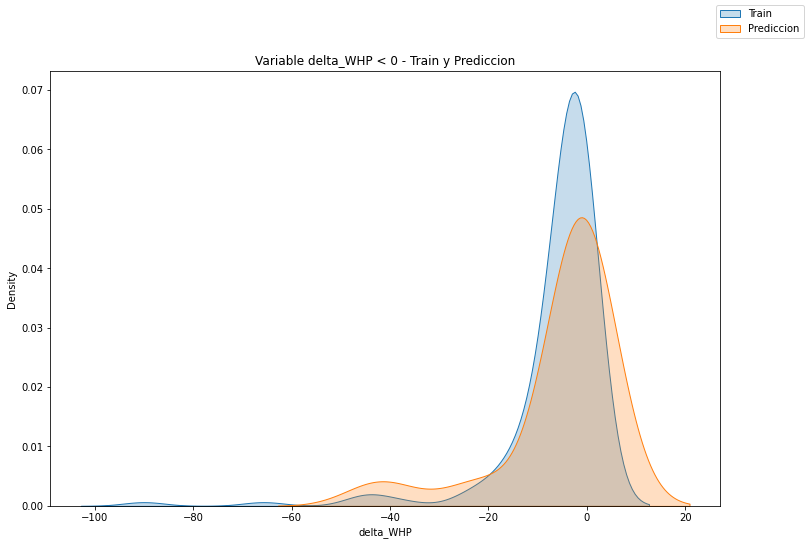

In [288]:
#Grafico KDE - Registros donde delta_WHP < 0 - Train y Prediccion

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train_deltap_neg, x="delta_WHP",fill=True)
sns.kdeplot(data=df_pred_deltap_neg, x="delta_WHP",fill=True)
fig.legend(labels=['Train','Prediccion'])
plt.title('Variable delta_WHP < 0 - Train y Prediccion')
plt.show()

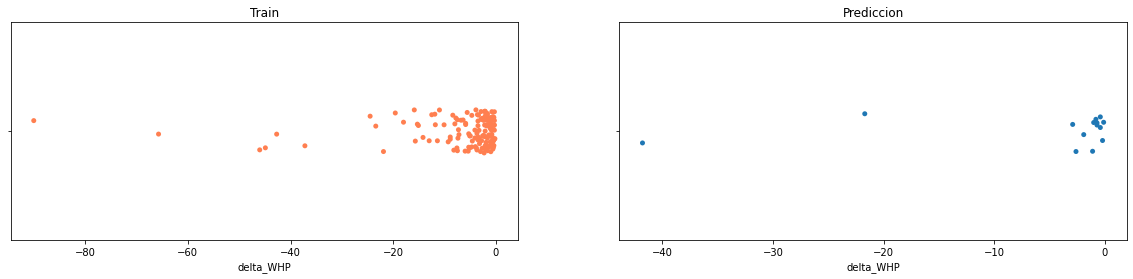

In [289]:
#Grafico STRIPPLOT - Registros donde delta_WHP < 0 - Train y Prediccion

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.stripplot(data=df_train_deltap_neg, x="delta_WHP",ax=axs[0],color='coral')
sns.stripplot(data=df_pred_deltap_neg, x="delta_WHP",ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Prediccion')
plt.show()

Analisis de registros con **delta_WHP = 0**

In [290]:
#Registros donde delta_WHP = 0

df_pred_deltap_cero = df_pred[df_pred['delta_WHP']==0]

#Cantidad de registros donde delta_WHP = 0

df_pred_deltap_cero['delta_WHP'].count() 

5864

Analisis de registros con **delta_WHP > 0**

In [291]:
#Registros donde delta_WHP > 0

df_pred_deltap_pos = df_pred[df_pred['delta_WHP']>0]
df_pred_deltap_pos['delta_WHP'].describe() 

count    658.000000
mean      11.237538
std       12.853038
min        0.100000
25%        3.225000
50%        6.500000
75%       13.875000
max       86.500000
Name: delta_WHP, dtype: float64

In [292]:
#Cantidad de registros donde delta_WHP > 0

df_pred_deltap_pos['delta_WHP'].count() 

658

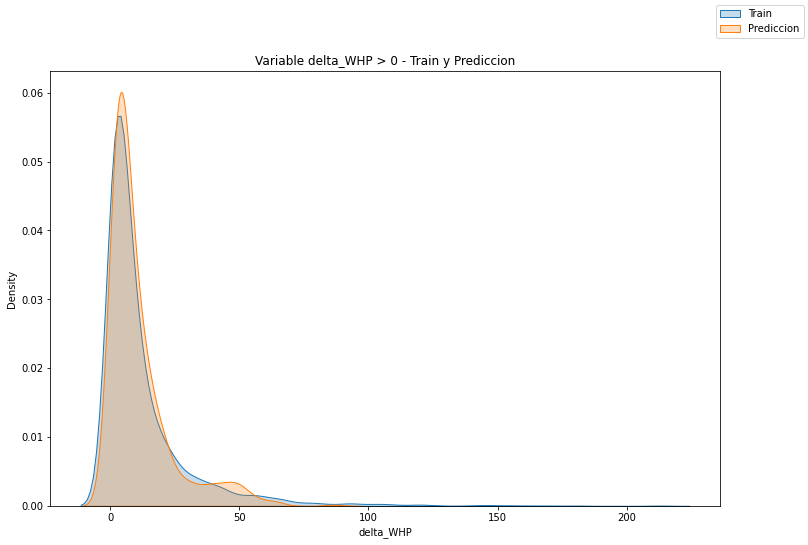

In [293]:
#Grafico KDE - Registros donde delta_WHP > 0 - Train y Prediccion

fig = plt.figure(figsize=(12,8))
sns.kdeplot(data=df_train_deltap_pos, x="delta_WHP",fill=True)
sns.kdeplot(data=df_pred_deltap_pos, x="delta_WHP",fill=True)
fig.legend(labels=['Train','Prediccion'])
plt.title('Variable delta_WHP > 0 - Train y Prediccion')
plt.show()

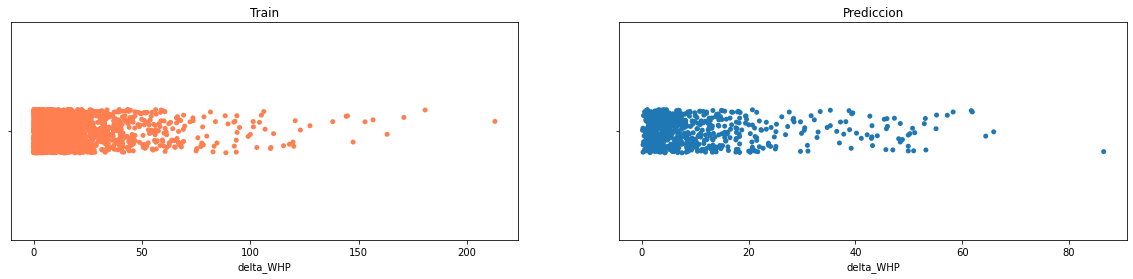

In [294]:
#Grafico STRIPPLOT - Registros donde delta_WHP > 0 - Train y Prediccion

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
sns.stripplot(data=df_train_deltap_pos, x="delta_WHP",ax=axs[0],color='coral')
sns.stripplot(data=df_pred_deltap_pos, x="delta_WHP",ax=axs[1])
axs[0].title.set_text('Train')
axs[1].title.set_text('Prediccion')
plt.show()

# **5. Reflexion Final**

La competencia fue muy interesante y desafiante.

Gracias por la organizacion, predisposicion a resolver consultas y la posibilidad de participar.